# Import data and libraries

In [1]:
quick_run = False

numero_de_experimento = 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from data_experts.learning_functions import *

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cleaning for trainning

In [3]:
df = pd.read_csv("../data/electronics_features_to_analyze.csv").drop("Unnamed: 0", axis = 1)

In [4]:
# Añadir columnas aleatorias
I, J = 1, 1
df = add_categorical_random(df, num_random_columns=I)
df = add_numerical_random(df, num_random_columns=J)

In [5]:
# Definir las características categóricas y numéricas
# Columnas numéricas
target = "sold_quantity"
numerical_features = [
    'price', 
    #'initial_quantity',
    #'available_quantity', 
    'sold_quantity', 
    'installment_quantity', 
    'installment_rate', 
    'days_until_discount_end', 
    'msi', 
    'discount'
]+ [f'num_random_{i}' for i in range(J)]

numerical_features.remove(target)

# Columnas categóricas
categorical_features = [
    'buying_mode', 
    'query', 
    'condition', 
    'brand', 
    'domain_id', 
    'listing_type_id', 
    'is_official_store', 
    'free_shipping', 
    'store_pick_up', 
] +  [f'cat_random_{i}' for i in range(I)]


In [6]:
quasinormal_features, non_normal_features = partition_numerical_features(df, numerical_features)
print(quasinormal_features, non_normal_features)

['num_random_0'] ['price', 'installment_quantity', 'installment_rate', 'days_until_discount_end', 'msi', 'discount']


In [7]:
df_clean = remove_outliers(df, numerical_features, exclude = ["days_until_discount_end"])
print(len(df_clean)/len(df), " from data left after outlier removing")

0.9784226190476191  from data left after outlier removing


In [8]:
df = df_clean

In [9]:
X = df[numerical_features + categorical_features]  # Aquí asegúrate de que las nuevas columnas estén incluidas
y = df[target]

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom metrics

In [10]:
normalized_rmse_scorer = make_scorer(normalized_rmse, greater_is_better=False)

# Training Pipelines

In [11]:
best_models = {}

In [12]:
# Random Forest
rf_pipeline = build_pipeline(
    RandomForestRegressor(random_state=42),
    categorical_features,
    quasinormal_features,
    non_normal_features,
    one_hot=True
)
rf_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}
rf_best_model, rf_grid_search = run_grid_search(
    rf_pipeline,
    rf_param_grid,
    X_train,
    y_train,
    scoring = normalized_rmse_scorer
)
rf_results_df = calculate_and_compile_metrics("Random Forest", rf_best_model, X_train, X_test, y_train, y_test, rf_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [13]:
rf_results_df

train_MSE  train_RMSE  train_MAE  train_R2       test_MSE  test_RMSE  \
0 19,186,641.61    4,380.26   1,311.77      0.78 164,639,643.45  12,831.20   

   test_MAE  test_R2          Model  \
0  2,793.18     0.01  Random Forest   

                                         Best_Params  
0  {'model__max_depth': 20, 'model__min_samples_s...

In [14]:
# XGBoost
xgb_pipeline = build_pipeline(
    XGBRegressor(random_state=42),
    categorical_features,
    quasinormal_features,
    non_normal_features,
    one_hot=True
)
xgb_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 6, 9]
}
xgb_best_model, xgb_grid_search = run_grid_search(xgb_pipeline, xgb_param_grid, X_train, y_train)
xgb_results_df = calculate_and_compile_metrics("XGBoost", xgb_best_model, X_train, X_test, y_train, y_test, xgb_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [15]:
# LightGBM
lgbm_pipeline = build_pipeline(
    LGBMRegressor(random_state=42, verbose=-1),
    categorical_features,
    quasinormal_features,
    non_normal_features,
    one_hot=True
)
lgbm_param_grid = {
    'model__num_leaves': [31, 50, 100],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 200, 300]
}
lgbm_best_model, lgbm_grid_search = run_grid_search(lgbm_pipeline, lgbm_param_grid, X_train, y_train)
lgbm_results_df = calculate_and_compile_metrics("LightGBM", lgbm_best_model, X_train, X_test, y_train, y_test, lgbm_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Buscar outliers en el training set pues no tiene sentido que el error se dispare para el trainingset

In [16]:
#guardar los mejores resultados
best_models["rf_gr"] =   {"result":rf_best_model, "method": "grid", "r2_train":rf_results_df["train_R2"].iloc[0], "r2_test":rf_results_df["test_R2"].iloc[0]}
best_models["xgb_gr"] =  {"result":xgb_best_model, "method": "grid", "r2_train":xgb_results_df["train_R2"].iloc[0], "r2_test":xgb_results_df["test_R2"].iloc[0]}
best_models["lgbm_gr"] = {"result":lgbm_best_model, "method": "grid", "r2_train":lgbm_results_df["train_R2"].iloc[0], "r2_test":lgbm_results_df["test_R2"].iloc[0]}


# Results and choosing the best model

### Random Forest

In [17]:
#for bayesian models

best_score_test = lambda test_scores: max(test_scores)
best_score_train = lambda train_scores, test_scores: train_scores[test_scores.index(max(test_scores))]


In [18]:
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [19]:
rf_results_df

train_MSE  train_RMSE  train_MAE  train_R2       test_MSE  test_RMSE  \
0 19,186,641.61    4,380.26   1,311.77      0.78 164,639,643.45  12,831.20   

   test_MAE  test_R2          Model  \
0  2,793.18     0.01  Random Forest   

                                         Best_Params  
0  {'model__max_depth': 20, 'model__min_samples_s...

In [20]:
rf_param_bounds = {
    'n_estimators': (100, 300),
    'max_depth': (10, 30),
    'min_samples_split': (2, 10)
}

best_params_rf, train_scores_rf, test_scores_rf = bayesian_optimization2(
    RandomForestRegressor, 
    rf_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features,
    quasinormal_features,
    non_normal_features
)


|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.03315   | 17.49     | 9.606     | 246.4     |
| 2         | 0.02674   | 21.97     | 3.248     | 131.2     |
| 3         | 0.02491   | 11.16     | 8.929     | 220.2     |
| 4         | 0.02058   | 24.16     | 2.165     | 294.0     |
| 5         | 0.02412   | 26.65     | 3.699     | 136.4     |
| 6         | 0.02809   | 25.0      | 9.266     | 251.7     |
| 7         | 0.01578   | 27.24     | 6.222     | 126.2     |
| 8         | 0.005286  | 10.72     | 6.518     | 250.5     |
| 9         | 0.01178   | 26.79     | 7.607     | 141.8     |
| 10        | 0.03382   | 19.67     | 9.28      | 108.2     |
| 11        | 0.01261   | 28.56     | 5.077     | 177.3     |
| 12        | 0.01931   | 25.98     | 2.752     | 240.4     |
| 13        | 0.02601   | 16.35     | 9.128     | 127.3     |
| 14        | 0.0131    | 26.39     | 3.742     | 136.6     |
| 15    

In [21]:
show_training(train_scores_rf, test_scores_rf).loc[[5, 18, 26]]

train  test
5    0.76  0.03
18   0.78  0.03
26   0.88  0.01

Se muestra un valor bastante inusual pues en los parametros que se obtuvo menor error para el training set, el test set tuvo errores muy pequeños 

In [22]:
best_params_rf

{'max_depth': 20, 'min_samples_split': 9, 'n_estimators': 108}

In [23]:
rf_best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, min_samples_split=5,
                                       n_estimators=200, random_state=42))])

In [24]:
best_model_r2_train =best_score_train(train_scores_rf, test_scores_rf),
best_model_r2_test = best_score_test(test_scores_rf)
best_models["rf_bayes"] = {"result":best_params_rf, "method": "bayes_rs42",
                           "r2_train":best_model_r2_train,
                           "r2_test": best_model_r2_test
                          }



In [25]:
best_models

{'rf_gr': {'result': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num_quasinormal',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('scaler',
                                                                     StandardScaler(with_mean=False))]),
                                                    ['num_random_0']),
                                                   ('num_non_normal',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('scaler',
                                                                     MinMaxScaler())]),
               

### XGB

In [26]:
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'installment_quantity',
                                                   'ins...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [27]:
xgb_results_df

train_MSE  train_RMSE  train_MAE  train_R2       test_MSE  test_RMSE  \
0 14,700,550.02    3,834.13   1,555.63      0.83 154,803,028.30  12,441.99   

   test_MAE  test_R2    Model  \
0  2,784.14     0.07  XGBoost   

                                         Best_Params  
0  {'model__learning_rate': 0.1, 'model__max_dept...

In [28]:
xgb_results_df["Best_Params"].iloc[0]

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

In [29]:
xgb_param_bounds = {
    'n_estimators': (100, 400),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (1, 6)
}

best_params_xgb, train_scores_xgb, test_scores_xgb = bayesian_optimization2(
    XGBRegressor,
    xgb_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features,
    quasinormal_features,
    non_normal_features
)


|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.01      | 0.1186    | 14.41     | 4.66      | 279.6     |
| 2         | 0.02648   | 0.05525   | 4.872     | 1.29      | 359.9     |
| 3         | 0.02229   | 0.1843    | 11.5      | 1.103     | 391.0     |
| 4         | 0.001528  | 0.2514    | 5.548     | 1.909     | 155.0     |
| 5         | -0.1054   | 0.09823   | 9.297     | 3.16      | 187.4     |
| 6         | 0.06377   | 0.01      | 3.0       | 6.0       | 376.0     |
| 7         | -0.04268  | 0.1324    | 3.547     | 5.454     | 378.7     |
| 8         | -0.003731 | 0.29      | 8.713     | 4.426     | 387.2     |
| 9         | -0.003649 | 0.161     | 9.634     | 5.989     | 200.3     |
| 10        | -0.05228  | 0.175     | 7.354     | 3.268     | 107.8     |
| 11        | -0.05462  | 0.2817    | 12.01     | 2.449     | 361.0     |
| 12        | 0.02927   | 0.04786   | 

In [30]:
show_training(train_scores_xgb, test_scores_xgb).loc[[5,7]]

train  test
5   0.46  0.06
7   1.00 -0.00

In [31]:
best_model_r2_train =best_score_train(train_scores_xgb, test_scores_xgb),
best_model_r2_test = best_score_test(test_scores_xgb)
best_models["xgb_bayes"] = {"result":best_params_xgb, "method": "bayes_rs42",
                           "r2_train":best_model_r2_train,
                           "r2_test": best_model_r2_test
                          }



### LGBM

In [32]:
lgbm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model', LGBMRegressor(random_state=42, verbose=-1))])

In [33]:
lgbm_results_df

train_MSE  train_RMSE  train_MAE  train_R2       test_MSE  test_RMSE  \
0 66,969,646.71    8,183.50   2,208.76      0.23 154,773,346.35  12,440.79   

   test_MAE  test_R2     Model  \
0  3,258.94     0.07  LightGBM   

                                         Best_Params  
0  {'model__learning_rate': 0.01, 'model__n_estim...

In [34]:
lgbm_results_df["Best_Params"].iloc[0]

{'model__learning_rate': 0.01,
 'model__n_estimators': 200,
 'model__num_leaves': 31}

In [35]:
lgb_param_bounds = {
    'n_estimators': (100, 300),
    'num_leaves': (20, 100),
    'learning_rate': (0.01, 0.2)
}
best_params_lgb, train_scores_lgb, test_scores_lgb = bayesian_optimization2(
    LGBMRegressor, 
    lgb_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features,
    quasinormal_features,
    non_normal_features
)


|   iter    |  target   | learni... | n_esti... | num_le... |
-------------------------------------------------------------
| 1         | 0.04157   | 0.08116   | 290.1     | 78.56     |
| 2         | 0.06129   | 0.1237    | 131.2     | 32.48     |
| 3         | 0.07763   | 0.02104   | 273.2     | 68.09     |
| 4         | 0.05354   | 0.1445    | 104.1     | 97.59     |
| 5         | 0.04203   | 0.1682    | 142.5     | 34.55     |
| 6         | 0.07076   | 0.03409   | 273.3     | 67.49     |
| 7         | 0.07515   | 0.01548   | 274.1     | 69.44     |
| 8         | 0.07886   | 0.01      | 271.6     | 69.56     |
| 9         | 0.005453  | 0.2       | 268.9     | 67.79     |
| 10        | 0.07886   | 0.01      | 272.3     | 72.01     |
| 11        | 0.07901   | 0.01      | 270.7     | 75.11     |
| 12        | 0.07882   | 0.01      | 273.9     | 75.57     |
| 13        | 0.02349   | 0.198     | 271.8     | 78.47     |
| 14        | 0.07862   | 0.01      | 275.3     | 73.36     |
| 15    

In [36]:
show_training(train_scores_lgb, test_scores_lgb).loc[[1, 2, 3]]

train  test
1   0.67  0.06
2   0.41  0.08
3   0.66  0.05

In [37]:
best_model_r2_train =best_score_train(train_scores_lgb, test_scores_lgb),
best_model_r2_test = best_score_test(test_scores_lgb)
best_models["lgb_bayes"] = {"result":best_params_lgb, "method": "bayes",
                           "r2_train":best_model_r2_train,
                           "r2_test": best_model_r2_test
                          }



### Red neuronal (un solo set de parámetros)

In [38]:
# Preprocesamiento: Separamos esta parte del ajuste del modelo para calcular input_dim
pipeline_preprocessor = build_pipeline(
    None,  # Aquí no pasamos el modelo porque solo queremos preprocesar
    categorical_features,
    quasinormal_features,
    non_normal_features
)

# Ajuste del preprocesador para calcular input_dim
pipeline_preprocessor.fit(X_train, y_train)  # Ajuste completo del preprocesador
input_dim = pipeline_preprocessor.named_steps['preprocessor'].transform(X_train[:1]).shape[1]

# Ahora que sabemos input_dim, creamos el modelo y el pipeline completo
pipeline0 = build_pipeline(
    create_keras_model(input_dim=input_dim),
    categorical_features,
    quasinormal_features,
    non_normal_features
)

# Entrenar el modelo con el pipeline completo
pipeline0.fit(X_train, y_train)

# Evaluar el modelo
train_score = pipeline0.score(X_train, y_train)
test_score = pipeline0.score(X_test, y_test)

print(f"Train R2 Score: {train_score:.4f}")
print(f"Test R2 Score: {test_score:.4f}")


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 81934080.0000 - r2_score: -0.0571
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 79643936.0000 - r2_score: -0.0686
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 97236032.0000 - r2_score: -0.0533
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 63679628.0000 - r2_score: -0.0594
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 57594088.0000 - r2_score: -0.0576
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 66715232.0000 - r2_score: -0.0449
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 136360480.0000 - r2_score: -0.0342
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 92969104.0000 - r2_score: -0.0311
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 142751936.0000 - r2_score: -0.0210
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 58580944.0000 - r2_score: -0.0051
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 613u

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 56403824.0000 - r2_score: 0.1183
Epoch 65/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 79724288.0000 - r2_score: 0.1080
Epoch 66/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 71197752.0000 - r2_score: 0.1697
Epoch 67/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 52311992.0000 - r2_score: 0.2074
Epoch 68/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 95964200.0000 - r2_score: 0.2222
Epoch 69/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 54132412.0000 - r2_score: 0.2586
Epoch 70/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 95149424.0000 - r2_score: 0.2049
Epoch 71/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 71625408.0000 - r2_score: 0.2571
Epoch 72/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 79748464.0000 - r2_score: 0.2278
Epoch 73/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 64276948.0000 - r2_score: 0.1918
Epoch 74/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 3

In [39]:
pipeline0

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model',
                 KerasRegressor(build_fn=<function create_keras_model.<locals>.<lambda> at 0x28f07dc60>))])

In [40]:
best_models["nn"] = {"result":pipeline0, "method": "fix_params",
                           "r2_train":pipeline0.score(X_train, y_train),
                           "r2_test": pipeline0.score(X_test, y_test)
                          }



33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step


### Red Neuronal (Gridsearch)

In [41]:
if quick_run == False:
    # Preprocesamiento: Separamos esta parte del ajuste del modelo para calcular input_dim
    pipeline_preprocessor = build_pipeline(
        None,  # Aquí no pasamos el modelo porque solo queremos preprocesar
        [],
        quasinormal_features,
        non_normal_features
    )

    X_train_n = X_train[numerical_features]
    X_test_n = X_test[numerical_features]
    # Ajuste del preprocesador para calcular input_dim
    pipeline_preprocessor.fit(X_train_n, y_train)  # Ajuste completo del preprocesador
    input_dim = pipeline_preprocessor.named_steps['preprocessor'].transform(X_train[:1]).shape[1]

    # Ahora que sabemos input_dim, creamos el pipeline completo
    pipeline = build_pipeline(
        MyKerasRegressor(input_dim=input_dim),
        [],
        quasinormal_features,
        non_normal_features,
        one_hot= False
    )

    # Definir los parámetros para el grid search
    param_grid = {
        'model__layers': [1, 2, 3],
        'model__units': [32, 64, 128],
        'model__activation': ['relu', 'tanh'],
        'model__optimizer': ['adam', 'rmsprop'],
        'model__epochs': [50, 100],  # Aquí agregamos epochs directamente al estimador
        'model__batch_size': [16, 32],
    }

    # Configurar GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)

    # Ejecutar GridSearchCV
    grid_search.fit(X_train, y_train)

    # Imprimir los mejores parámetros y el mejor score
    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor score (R2):", grid_search.best_score_)

    # Evaluar el modelo en el conjunto de prueba
    test_score = grid_search.score(X_test_n, y_test)
    print(f"Test R2 Score: {test_score:.4f}")
    
    best_models["nn_gridsearch"] = {"result":grid_search.best_params_,
                                "method": "grid_search",
                           "r2_train":grid_search.best_score_,
                           "r2_test": grid_search.score(X_test_n, y_test)
                          }


Fitting 3 folds for each of 144 candidates, totalling 432 fits
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 46460828.0000 - r2_score: -0.0749
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 24967402.0000 - r2_score: -0.1269
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 32801920.0000 - r2_score: -0.1009
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 71029960.0000 - r2_score: -0.0741
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 47840660.0000 - r2_score: -0.0677
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 158967792.0000 - r2_score: -0.0354
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 123558040.0000 - r2_score: -0.0585
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 55998576.0000 - r2_score: -0.0949
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 91703360.0000 - r2_score: -0.0582
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 30195598.0000 - r2_score: -0

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 57142888.0000 - r2_score: -0.0878
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 114604312.0000 - r2_score: -0.0600
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 67645192.0000 - r2_score: -0.1164
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 132066144.0000 - r2_score: -0.0558
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 74489576.0000 - r2_score: -0.0644
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 143217472.0000 - r2_score: -0.0522
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 104146800.0000 - r2_score: -0.0611
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 76331808.0000 - r2_score: -0.0684
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 141172576.0000 - r2_score: -0.0516
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 121650432.0000 - r2_score: -0.0485
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - l

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 103037176.0000 - r2_score: -0.0588
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 177312048.0000 - r2_score: -0.0384
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 97421256.0000 - r2_score: -0.0456
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 116019192.0000 - r2_score: -0.0465
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 207042048.0000 - r2_score: -0.0341
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 106192920.0000 - r2_score: -0.0491
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 167927072.0000 - r2_score: -0.0439
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 160555760.0000 - r2_score: -0.0342
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 73908104.0000 - r2_score: -0.0477
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 82612920.0000 - r2_score: -0.0476
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - 

Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 141257888.0000 - r2_score: -0.0316
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 124651672.0000 - r2_score: -0.0348
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 190093744.0000 - r2_score: -0.0278
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 246330096.0000 - r2_score: -0.0309
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 192291072.0000 - r2_score: -0.0278
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 54019860.0000 - r2_score: -0.0514
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 73009792.0000 - r2_score: -0.0345
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 99565128.0000 - r2_score: -0.0423
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 89127976.0000 - r2_score: -0.0346
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 72336424.0000 - r2_score: -0.0295
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 183129664.0000 - r2_score: -0.0411
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 131650016.0000 - r2_score: -0.0570
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 59949464.0000 - r2_score: -0.0736
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 117036400.0000 - r2_score: -0.0469
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 134802080.0000 - r2_score: -0.0460
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 121134008.0000 - r2_score: -0.0468
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 66584964.0000 - r2_score: -0.0647
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 66635548.0000 - r2_score: -0.0701
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 89168096.0000 - r2_score: -0.0674
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 87706264.0000 - r2_score: -0.0548
Epoch 10/50
44/44 ━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 133188624.0000 - r2_score: -0.0510
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 39025400.0000 - r2_score: -0.0664
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 116974008.0000 - r2_score: -0.0515
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 24812480.0000 - r2_score: -0.0926
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 80292488.0000 - r2_score: -0.0503
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 63953744.0000 - r2_score: -0.0623
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 125632888.0000 - r2_score: -0.0444
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 112121824.0000 - r2_score: -0.0382
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 187836064.0000 - r2_score: -0.0384
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 85624872.0000 - r2_score: -0.0466
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - lo

Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 54966916.0000 - r2_score: -0.0555
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 64414232.0000 - r2_score: -0.0801
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 92136704.0000 - r2_score: -0.0616
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 91889072.0000 - r2_score: -0.0448
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 65522516.0000 - r2_score: -0.0497
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 117656352.0000 - r2_score: -0.0426
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 108032408.0000 - r2_score: -0.0426
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 83327504.0000 - r2_score: -0.0302
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 68515848.0000 - r2_score: -0.0427
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 107029104.0000 - r2_score: -0.0503
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 140294960.0000 - r2_score: -0.0250
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 86022976.0000 - r2_score: -0.0347
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 272980704.0000 - r2_score: -0.0272
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 81058376.0000 - r2_score: -0.0315
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 129781976.0000 - r2_score: -0.0179
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 102300968.0000 - r2_score: -0.0284
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 106690696.0000 - r2_score: -0.0319
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 61289904.0000 - r2_score: -0.0320
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 98091712.0000 - r2_score: -0.0316
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 49587148.0000 - r2_score: -0.0298
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - lo

Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 45819592.0000 - r2_score: -0.0717
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 108011712.0000 - r2_score: -0.0726
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 125827792.0000 - r2_score: -0.0759
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 58011488.0000 - r2_score: -0.0806
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 101665664.0000 - r2_score: -0.0781
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 80959024.0000 - r2_score: -0.0560
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 133569976.0000 - r2_score: -0.0627
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 69888256.0000 - r2_score: -0.0716
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 109259840.0000 - r2_score: -0.0543
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 129011520.0000 - r2_score: -0.0655
Epoch 10/50
4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 109102944.0000 - r2_score: -0.0410
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 76029512.0000 - r2_score: -0.0516
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 83275672.0000 - r2_score: -0.1118
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 83068216.0000 - r2_score: -0.0936
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 22165772.0000 - r2_score: -0.1374
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 105671104.0000 - r2_score: -0.0738
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 62611816.0000 - r2_score: -0.0631
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 87866464.0000 - r2_score: -0.0662
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 57418380.0000 - r2_score: -0.0836
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 96098008.0000 - r2_score: -0.0623
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss:

Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 107606368.0000 - r2_score: -0.0447
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 54413064.0000 - r2_score: -0.0542
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 53970304.0000 - r2_score: -0.0747
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 172809616.0000 - r2_score: -0.0589
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 95904200.0000 - r2_score: -0.0471
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 169814928.0000 - r2_score: -0.0443
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 69302408.0000 - r2_score: -0.0678
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 98435208.0000 - r2_score: -0.0460
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 43662148.0000 - r2_score: -0.0757
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 53357888.0000 - r2_score: -0.0709
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 93291792.0000 - r2_score: -0.0688
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 148472720.0000 - r2_score: -0.0505
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 70500096.0000 - r2_score: -0.0605
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 134629664.0000 - r2_score: -0.0474
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 86699632.0000 - r2_score: -0.0496
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 128817576.0000 - r2_score: -0.0486
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 97441832.0000 - r2_score: -0.0492
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 87526504.0000 - r2_score: -0.0665
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 85989608.0000 - r2_score: -0.0636
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 80365664.0000 - r2_score: -0.0798
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss

Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 189186464.0000 - r2_score: -0.0374
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 138194336.0000 - r2_score: -0.0473
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 36969232.0000 - r2_score: -0.0904
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 131080640.0000 - r2_score: -0.0507
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 144365456.0000 - r2_score: -0.0567
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 167407904.0000 - r2_score: -0.0465
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 89129152.0000 - r2_score: -0.0761
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 56880968.0000 - r2_score: -0.0882
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 119013136.0000 - r2_score: -0.0560
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 129324208.0000 - r2_score: -0.0501
Epoch 10/50


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 117894680.0000 - r2_score: -0.0682
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 61532980.0000 - r2_score: -0.0744
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 126984640.0000 - r2_score: -0.0547
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 63817480.0000 - r2_score: -0.0983
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 69032432.0000 - r2_score: -0.0892
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 84906336.0000 - r2_score: -0.0650
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 124330232.0000 - r2_score: -0.0590
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 53874800.0000 - r2_score: -0.0694
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 90632072.0000 - r2_score: -0.0778
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 125961056.0000 - r2_score: -0.0583
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - los

Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 75012504.0000 - r2_score: -0.0533
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 71317496.0000 - r2_score: -0.0480
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 98089520.0000 - r2_score: -0.0536
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 150752000.0000 - r2_score: -0.0417
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 103739904.0000 - r2_score: -0.0399
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 59201112.0000 - r2_score: -0.0506
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 123734568.0000 - r2_score: -0.0472
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 169577312.0000 - r2_score: -0.0434
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 116175880.0000 - r2_score: -0.0338
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 137752976.0000 - r2_score: -0.0369
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 34

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 66404880.0000 - r2_score: 0.0149
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 55761936.0000 - r2_score: 0.0244
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 72909496.0000 - r2_score: 0.0112
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 90285480.0000 - r2_score: 0.0078
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 46391284.0000 - r2_score: 0.0209
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 75507152.0000 - r2_score: 0.0114
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 83252504.0000 - r2_score: -0.1472
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 43780904.0000 - r2_score: -0.0342
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 132374856.0000 - r2_score: -0.0461
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 139801680.0000 - r2_score: 0.0094
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 337537

Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 75153640.0000 - r2_score: 0.0226
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 190707152.0000 - r2_score: -0.0389 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 124764096.0000 - r2_score: -0.0688
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 220893664.0000 - r2_score: -0.0360
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 78439680.0000 - r2_score: -0.0592
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 82700432.0000 - r2_score: -0.0568
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 59504108.0000 - r2_score: -0.0668
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 79168896.0000 - r2_score: -0.0722
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 52429820.0000 - r2_score: -0.0939
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 92840184.0000 - r2_score: -0.0423
Epoch 10/50
44/4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 36724156.0000 - r2_score: -0.0222
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 61199228.0000 - r2_score: -0.0062
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 31893838.0000 - r2_score: 0.0018
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 54024524.0000 - r2_score: -0.6494
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 28999560.0000 - r2_score: 0.0100
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 151196464.0000 - r2_score: -0.0030
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 42410160.0000 - r2_score: -0.0025
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 54093988.0000 - r2_score: 0.0077
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 75708352.0000 - r2_score: 0.0119
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 65864668.0000 - r2_score: 0.0092
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 40793

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 59761992.0000 - r2_score: -0.0387
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 61287728.0000 - r2_score: -0.0210
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 104676600.0000 - r2_score: 0.0136
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 54721880.0000 - r2_score: -0.0138
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 107222968.0000 - r2_score: -0.1582
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 79175128.0000 - r2_score: 0.0161
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 70274128.0000 - r2_score: -0.0149
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 82320504.0000 - r2_score: 0.0030
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 92680976.0000 - r2_score: -0.0161
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 49114892.0000 - r2_score: 0.0182
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 751

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 52745348.0000 - r2_score: -0.3478
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 160687104.0000 - r2_score: 0.0058
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 33116266.0000 - r2_score: -0.0090
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 71935352.0000 - r2_score: 0.0018
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 46512392.0000 - r2_score: 0.0014
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 91070512.0000 - r2_score: 0.0203
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 76895888.0000 - r2_score: -0.0218
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 73217760.0000 - r2_score: 0.0100
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 108449824.0000 - r2_score: -0.0567
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 116912048.0000 - r2_score: -0.0033
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 141

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - loss: 93465072.0000 - r2_score: -0.0690 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 52091904.0000 - r2_score: -0.0792
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 92553224.0000 - r2_score: -0.0561
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 117181440.0000 - r2_score: -0.0440
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 119122640.0000 - r2_score: -0.0480
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 49652460.0000 - r2_score: -0.0567
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 124803032.0000 - r2_score: -0.0297
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 68739920.0000 - r2_score: -0.0103
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 59648384.0000 - r2_score: -0.0160
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 150152816.0000 - r2_score: -0.0094
Epoch 11/50
44

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 116944192.0000 - r2_score: -0.0101
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 57672116.0000 - r2_score: 0.0084
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 46358772.0000 - r2_score: -0.0920
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 92362816.0000 - r2_score: -0.3655
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 103798280.0000 - r2_score: 0.0015
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 104410568.0000 - r2_score: 0.0030
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 81435664.0000 - r2_score: -0.3998
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 70675128.0000 - r2_score: -0.0115
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 99076712.0000 - r2_score: 0.0152
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 41565052.0000 - r2_score: -0.1214
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 27

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 45555684.0000 - r2_score: -0.0368
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 109142088.0000 - r2_score: -0.0257
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 29157642.0000 - r2_score: -0.0342
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 100418584.0000 - r2_score: -0.0235
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 123443376.0000 - r2_score: -0.0162
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 200168144.0000 - r2_score: -0.0170
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 43636396.0000 - r2_score: -0.0175
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 53576928.0000 - r2_score: -0.0137
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 86330144.0000 - r2_score: -0.0080
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 74990520.0000 - r2_score: -0.0166
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - los

Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 88480344.0000 - r2_score: -0.0084
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 76210280.0000 - r2_score: 0.0030
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 121641752.0000 - r2_score: -0.0058
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 67164704.0000 - r2_score: -0.0049
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 93159784.0000 - r2_score: 0.0072
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 89581016.0000 - r2_score: 0.0072
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 100996048.0000 - r2_score: -0.0043
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 87082680.0000 - r2_score: -0.0137
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 66225748.0000 - r2_score: -0.0491
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 85318760.0000 - r2_score: 2.3253e-04
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 81008112.0000 - r2_score: -0.0632 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 41112020.0000 - r2_score: -0.0808
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 66561360.0000 - r2_score: -0.0920
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 60777900.0000 - r2_score: -0.0787
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 96815208.0000 - r2_score: -0.0559
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 128483832.0000 - r2_score: -0.0422
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 48732896.0000 - r2_score: -0.0628
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 68519720.0000 - r2_score: -0.0542
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 69012960.0000 - r2_score: -0.0671
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 75531152.0000 - r2_score: -0.0457
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 6522421

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 75727120.0000 - r2_score: -0.0367
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 78719464.0000 - r2_score: -0.0462
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 80738424.0000 - r2_score: -0.0266
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 54548104.0000 - r2_score: -0.0321
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 38481668.0000 - r2_score: -0.0136
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 83984800.0000 - r2_score: -0.0187
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 138759152.0000 - r2_score: -0.0231
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 58866468.0000 - r2_score: -0.0124
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 120370208.0000 - r2_score: -0.0153
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 43805888.0000 - r2_score: -0.2118
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss:

Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 62336452.0000 - r2_score: -0.0090
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 91163688.0000 - r2_score: -0.0110
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 160370176.0000 - r2_score: -0.0094
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 77219672.0000 - r2_score: -6.6548e-04
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 131767736.0000 - r2_score: -0.0162
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 146082112.0000 - r2_score: -0.0019
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 66976308.0000 - r2_score: -0.0507
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 82815848.0000 - r2_score: -0.0296
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 88062456.0000 - r2_score: -9.4165e-04
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 35686040.0000 - r2_score: -0.0236
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 36663088.0000 - r2_score: 0.0340
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 63118144.0000 - r2_score: -0.0071
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 90128576.0000 - r2_score: -6.8471e-04
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 105097304.0000 - r2_score: 0.0145
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 62815360.0000 - r2_score: 0.0345
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 48354300.0000 - r2_score: -0.0060
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 96926256.0000 - r2_score: 0.0272
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 79603648.0000 - r2_score: 0.0378
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 81976312.0000 - r2_score: 7.5435e-04
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 123090808.0000 - r2_score: 0.0227
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 163037376.0000 - r2_score: -0.0452
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 71280584.0000 - r2_score: -0.0785
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 52781744.0000 - r2_score: -0.0553
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 37019580.0000 - r2_score: -0.0822
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 127155552.0000 - r2_score: -0.0416
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 43635552.0000 - r2_score: -0.0845
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 128269376.0000 - r2_score: -0.0338
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 66249540.0000 - r2_score: -0.0334
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 59141124.0000 - r2_score: -0.0304
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 120234432.0000 - r2_score: -0.0245
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 5034

Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 56734028.0000 - r2_score: 0.0092
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 41966716.0000 - r2_score: 0.0111
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 107815664.0000 - r2_score: 0.0115
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 42540448.0000 - r2_score: -0.2675
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 47874592.0000 - r2_score: 0.0208
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 102675440.0000 - r2_score: -0.2654
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 73872152.0000 - r2_score: -0.0064
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 58047988.0000 - r2_score: 0.0214
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 69138688.0000 - r2_score: 0.0216
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 82753208.0000 - r2_score: 0.0238
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 118543136.0000 - r2_score: 0.0241
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 73436016.0000 - r2_score: -0.0199
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 69767688.0000 - r2_score: -0.3051
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 86506216.0000 - r2_score: 0.0252
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 143706736.0000 - r2_score: 0.0247
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 108113384.0000 - r2_score: -0.0621
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 92106472.0000 - r2_score: 0.0137
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 104437400.0000 - r2_score: 0.0285
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 60600896.0000 - r2_score: -0.0167
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 142717296.0000 - r2_score: 0.0213
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 11

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 150965744.0000 - r2_score: -0.1059
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 44420848.0000 - r2_score: -0.0578
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 90682816.0000 - r2_score: -0.0210
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 108269616.0000 - r2_score: 0.0286
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 48799788.0000 - r2_score: 0.0134
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 54240668.0000 - r2_score: -0.1265
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 95352576.0000 - r2_score: -0.1275
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 77960648.0000 - r2_score: -0.0224
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 89315992.0000 - r2_score: -0.1892
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 64138380.0000 - r2_score: -0.8924
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
44/44 ━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 76638152.0000 - r2_score: -0.0832
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 60443428.0000 - r2_score: -0.0724
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 104714008.0000 - r2_score: -0.0294
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 126603408.0000 - r2_score: -0.0124
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 82426216.0000 - r2_score: -0.0056
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 62953296.0000 - r2_score: 0.0024
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 123684264.0000 - r2_score: 9.6821e-04
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 83269368.0000 - r2_score: -0.5236
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 124978080.0000 - r2_score: 0.0099
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 95108952.0000 - r2_score: -0.0052
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 12

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 57942424.0000 - r2_score: -0.1021
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 91092656.0000 - r2_score: 0.0049
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 168883312.0000 - r2_score: 0.0024
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 152896224.0000 - r2_score: 0.0053
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 150657584.0000 - r2_score: -0.0213
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 91983992.0000 - r2_score: -0.0328
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 38008280.0000 - r2_score: -0.8521
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 82250800.0000 - r2_score: 0.0210
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 102955680.0000 - r2_score: 0.0014
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 48626904.0000 - r2_score: -0.0136
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 56

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 67634696.0000 - r2_score: -0.1524
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 29166010.0000 - r2_score: -0.0068
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 105093864.0000 - r2_score: 0.0660
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 143770848.0000 - r2_score: 0.0713
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 204009728.0000 - r2_score: 0.0616
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 91974816.0000 - r2_score: 0.0668
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 82415536.0000 - r2_score: 0.0453
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 56421160.0000 - r2_score: 0.0442
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 57573948.0000 - r2_score: 0.0777
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 58024620.0000 - r2_score: -0.0625
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 77985

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 59125912.0000 - r2_score: -0.0193
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 76314200.0000 - r2_score: 0.0400
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 65145112.0000 - r2_score: 0.0736
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 56451836.0000 - r2_score: 0.0120
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 85051672.0000 - r2_score: -0.1091
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 58230608.0000 - r2_score: -0.5354
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 70107744.0000 - r2_score: 0.0132
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 58486588.0000 - r2_score: 0.0441
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 48634540.0000 - r2_score: 0.0279
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 31686446.0000 - r2_score: -0.1192 
Epoch 2/50
44/44 ━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 128755368.0000 - r2_score: -0.0393
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 157016272.0000 - r2_score: -0.0396
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 39366324.0000 - r2_score: -0.0929
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 54670128.0000 - r2_score: -0.0571
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 51755576.0000 - r2_score: -0.0634
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 53160052.0000 - r2_score: -0.0525
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 81590584.0000 - r2_score: -0.0467
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 92414912.0000 - r2_score: -0.0536
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 180915344.0000 - r2_score: -0.0292
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 37189656.0000 - r2_score: -0.0374
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 871

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 131106896.0000 - r2_score: -0.0026
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 62596792.0000 - r2_score: 0.0011
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 70088976.0000 - r2_score: 0.0022
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 66122972.0000 - r2_score: -0.0019
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 82244704.0000 - r2_score: -0.0076
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 40651992.0000 - r2_score: -0.0327
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 105355056.0000 - r2_score: -0.0177
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 71793960.0000 - r2_score: -0.5550
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 70639216.0000 - r2_score: -2.5548
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 66609520.0000 - r2_score: -0.3562
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 6

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 91004544.0000 - r2_score: -0.0736
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 51471452.0000 - r2_score: 0.0044
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 144251632.0000 - r2_score: -0.0054
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 72989528.0000 - r2_score: -0.2324
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 60799456.0000 - r2_score: -0.0120
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 158424144.0000 - r2_score: -0.3198
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 70701336.0000 - r2_score: -0.0143
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 38961832.0000 - r2_score: 0.0105
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 109624816.0000 - r2_score: 0.0051
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 33340680.0000 - r2_score: 0.0016
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 79

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 58168020.0000 - r2_score: -0.0688
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 46063300.0000 - r2_score: 0.0600
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 58956576.0000 - r2_score: 0.0534
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 27219242.0000 - r2_score: -0.0044
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 169954336.0000 - r2_score: 0.0080
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 49049516.0000 - r2_score: 0.0632
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 138672208.0000 - r2_score: 0.0065
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 67357808.0000 - r2_score: 0.0392
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 53508544.0000 - r2_score: -0.0833
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 88964888.0000 - r2_score: -0.0713
Epoch 3/50
44/44 ━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 97320840.0000 - r2_score: -0.0489
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 68870472.0000 - r2_score: -0.0509
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 89257296.0000 - r2_score: -0.0302
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 37046204.0000 - r2_score: -0.0299
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 223806928.0000 - r2_score: -0.0188
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 45145272.0000 - r2_score: -0.0206
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 53339924.0000 - r2_score: -0.0060
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 59294156.0000 - r2_score: -0.0035
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 58339772.0000 - r2_score: -0.0095
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 70099560.0000 - r2_score: 0.0040
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 11444

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 99178336.0000 - r2_score: -0.5634
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 167664432.0000 - r2_score: 0.0212
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 57384396.0000 - r2_score: 0.0349
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 60172708.0000 - r2_score: -0.2095
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 78109824.0000 - r2_score: 0.0379
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 62770620.0000 - r2_score: 0.0241
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 86700960.0000 - r2_score: 0.0329
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 78328144.0000 - r2_score: 0.0272
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 56016896.0000 - r2_score: -0.0221
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 80238632.0000 - r2_score: 0.0224
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 4774960

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 57883008.0000 - r2_score: 0.0389
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 93638624.0000 - r2_score: 0.0379
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 70248232.0000 - r2_score: -0.1396
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 82236016.0000 - r2_score: 0.0505
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 51805868.0000 - r2_score: 0.0543
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 97941720.0000 - r2_score: -0.5519
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 112040096.0000 - r2_score: 0.0475
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 79358448.0000 - r2_score: 0.0597
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 59143920.0000 - r2_score: 0.0409
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 68116640.0000 - r2_score: 0.0273
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 54188736

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 174912704.0000 - r2_score: 0.0458
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 73441056.0000 - r2_score: 0.0538
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 98775320.0000 - r2_score: -0.0066
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 95916448.0000 - r2_score: -0.1643
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 60364552.0000 - r2_score: 0.0691
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 74431000.0000 - r2_score: -0.1097
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 47205676.0000 - r2_score: -0.1094
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 45324324.0000 - r2_score: -0.0945
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 127640832.0000 - r2_score: -0.0541
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 78631840.0000 - r2_score: -0.0698
Epoch 4/100
44/44 ━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 102140296.0000 - r2_score: -0.0331
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 74301952.0000 - r2_score: -0.0557
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 66828140.0000 - r2_score: -0.0397
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 126334192.0000 - r2_score: -0.0336
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 65836548.0000 - r2_score: -0.0376
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 48845512.0000 - r2_score: -0.0704
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 57661388.0000 - r2_score: -0.0686
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 105388592.0000 - r2_score: -0.0257
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 90041112.0000 - r2_score: -0.0340
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 93413352.0000 - r2_score: -0.0212
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 92247496.0000 - r2_score: -0.0664
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 95406024.0000 - r2_score: -0.0939
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 95671448.0000 - r2_score: -0.0777
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 123166392.0000 - r2_score: -0.0572
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 131661336.0000 - r2_score: -0.0647
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 126235592.0000 - r2_score: -0.0542
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 102840192.0000 - r2_score: -0.0500
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 53695160.0000 - r2_score: -0.0790
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 87427592.0000 - r2_score: -0.0649
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 84289784.0000 - r2_score: -0.0612
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/

Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 68060832.0000 - r2_score: -0.0354
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 90938168.0000 - r2_score: -0.0464
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 106857696.0000 - r2_score: -0.0360
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 79802616.0000 - r2_score: -0.0442
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 105112568.0000 - r2_score: -0.0260
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 79311768.0000 - r2_score: -0.0374
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 140145824.0000 - r2_score: -0.0306
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 57550652.0000 - r2_score: -0.0406
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 76794144.0000 - r2_score: -0.0424
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 93305144.0000 - r2_score: -0.0408
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 142073936.0000 - r2_score: -0.0312
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 63927788.0000 - r2_score: -0.0802
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 51757800.0000 - r2_score: -0.0806
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 125676280.0000 - r2_score: -0.0432
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 189187792.0000 - r2_score: -0.0405
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 33438762.0000 - r2_score: -0.0705
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 35071072.0000 - r2_score: -0.0889
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 123283136.0000 - r2_score: -0.0489
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 60269452.0000 - r2_score: -0.0579
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 33560652.0000 - r2_score: -0.0649
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 158942080.0000 - r2_score: -0.0398
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 85625288.0000 - r2_score: -0.0547
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 114811336.0000 - r2_score: -0.0577
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 71503248.0000 - r2_score: -0.0526
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 48675932.0000 - r2_score: -0.0652
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 48252544.0000 - r2_score: -0.0842
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 68463648.0000 - r2_score: -0.0674
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 75282512.0000 - r2_score: -0.0599
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 129142528.0000 - r2_score: -0.0397
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 91742216.0000 - r2_score: -0.0608
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 47138440.0000 - r2_score: -0.0254
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 88820336.0000 - r2_score: -0.0233
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 42333896.0000 - r2_score: -0.0404
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 48784476.0000 - r2_score: -0.0110
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 89480784.0000 - r2_score: -0.0159
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 69327408.0000 - r2_score: -0.0123
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 114204832.0000 - r2_score: -0.1265
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 145658352.0000 - r2_score: -0.0344
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 82541344.0000 - r2_score: -0.0137
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 69046488.0000 - r2_score: -0.0180
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 58513812.0000 - r2_score: -0.0602
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 48492244.0000 - r2_score: -0.0934
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 69675440.0000 - r2_score: -0.0587
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 197227664.0000 - r2_score: -0.0494
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 91219904.0000 - r2_score: -0.0401
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 71191344.0000 - r2_score: -0.0461
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 125688816.0000 - r2_score: -0.0626
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 138308672.0000 - r2_score: -0.0421
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 80667560.0000 - r2_score: -0.0536
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 78448984.0000 - r2_score: -0.0600
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/s

Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 46576624.0000 - r2_score: -0.0037
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 125448088.0000 - r2_score: -0.0109
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 142447920.0000 - r2_score: -0.1042
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 56188168.0000 - r2_score: 0.0100
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 89938984.0000 - r2_score: -0.0015
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 75317800.0000 - r2_score: -0.0081
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 112707720.0000 - r2_score: -0.0119
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 76301872.0000 - r2_score: -0.0184
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 44965476.0000 - r2_score: -0.0929 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 128658656.0000 - r2_score: -0.04

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 113210992.0000 - r2_score: -0.0277
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 35109860.0000 - r2_score: -0.0448
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 71036248.0000 - r2_score: -0.0350
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 51099312.0000 - r2_score: -0.0257
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 123464840.0000 - r2_score: -0.0191
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 65462220.0000 - r2_score: -0.0321
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 150065600.0000 - r2_score: -0.0266
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 137109072.0000 - r2_score: -0.0328
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 67684176.0000 - r2_score: -0.0182
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 39111864.0000 - r2_score: -0.0186
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 52325100.0000 - r2_score: -0.0715
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 61120112.0000 - r2_score: -0.0550
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 176729072.0000 - r2_score: -0.0372
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 106985072.0000 - r2_score: -0.0489
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 63657592.0000 - r2_score: -0.0505
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 117629456.0000 - r2_score: -0.0354
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 42251252.0000 - r2_score: -0.0628
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 65986332.0000 - r2_score: -0.0534
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 93381616.0000 - r2_score: -0.0385
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 33207492.0000 - r2_score: -0.0549
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 199432992.0000 - r2_score: -0.0038
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 52443144.0000 - r2_score: -0.0026
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 132123160.0000 - r2_score: -0.0042
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 40731864.0000 - r2_score: 0.0086
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 49237628.0000 - r2_score: -0.0080
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 54999220.0000 - r2_score: 0.0081
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 32131896.0000 - r2_score: 0.0033
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 109974456.0000 - r2_score: -0.0103
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 59548036.0000 - r2_score: -2.3877
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 74853656.0000 - r2_score: -0.0052
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 86807752.0000 - r2_score: -0.0360
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 124514048.0000 - r2_score: -0.0273
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 197106960.0000 - r2_score: -0.0306
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 81896728.0000 - r2_score: -0.0225
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 123301608.0000 - r2_score: -0.0289
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 95333632.0000 - r2_score: -0.0162
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 137995056.0000 - r2_score: -0.0279
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 125306304.0000 - r2_score: -0.0195
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 70645416.0000 - r2_score: -0.0127
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 131264608.0000 - r2_score: -0.0241
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367u

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 77924496.0000 - r2_score: -0.0547
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 57803284.0000 - r2_score: -0.0950
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 67036144.0000 - r2_score: -0.0638
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 184631872.0000 - r2_score: -0.0430
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 67501536.0000 - r2_score: -0.0806
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 151870656.0000 - r2_score: -0.0434
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 37703912.0000 - r2_score: -0.0802
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 88273208.0000 - r2_score: -0.0517
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 72692728.0000 - r2_score: -0.0670
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 140446112.0000 - r2_score: -0.0585
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step -

Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 101760632.0000 - r2_score: -0.0074
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 87417376.0000 - r2_score: -0.0108
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 56053428.0000 - r2_score: 0.0078
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 91066304.0000 - r2_score: -0.0014
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 18749644.0000 - r2_score: 0.0021
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 115140680.0000 - r2_score: -0.0110
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 54831068.0000 - r2_score: -0.0128
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 36663280.0000 - r2_score: -0.0144
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 126413496.0000 - r2_score: -0.0114
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 59673240.0000 - r2_score: -0.0071
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 130716808.0000 - r2_score: -0.0523
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 54156376.0000 - r2_score: -0.0598
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 148328272.0000 - r2_score: -0.0404
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 88703384.0000 - r2_score: -0.0539
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 87489080.0000 - r2_score: -0.0639
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 63313000.0000 - r2_score: -0.0938
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 75570744.0000 - r2_score: -0.0504
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 49859388.0000 - r2_score: -0.0661
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 48087200.0000 - r2_score: -0.0692
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 96804912.0000 - r2_score: -0.0533
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/st

Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 124180696.0000 - r2_score: -0.0290
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 168328144.0000 - r2_score: -0.0294
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 51313304.0000 - r2_score: -0.0356
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 50745676.0000 - r2_score: -0.0349
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 57974352.0000 - r2_score: -0.0432
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 75537248.0000 - r2_score: -0.0233
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 143511424.0000 - r2_score: -0.0245
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 67993352.0000 - r2_score: -0.0316
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 83843808.0000 - r2_score: -0.0345
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 95957528.0000 - r2_score: -0.06

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 94550056.0000 - r2_score: -0.0733
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 157404784.0000 - r2_score: -0.0524
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 82757504.0000 - r2_score: -0.0577
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 61987092.0000 - r2_score: -0.0666
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 61069784.0000 - r2_score: -0.0627
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 121083928.0000 - r2_score: -0.0552
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 57351704.0000 - r2_score: -0.0726
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 92468576.0000 - r2_score: -0.0522
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 100800968.0000 - r2_score: -0.0508
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 76345672.0000 - r2_score: -0.0624
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 88051144.0000 - r2_score: -0.0572
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 57865084.0000 - r2_score: -0.0694
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 136607600.0000 - r2_score: -0.0457
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 194034528.0000 - r2_score: -0.0292
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 141061632.0000 - r2_score: -0.0667
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 83142008.0000 - r2_score: -0.0660
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 140064416.0000 - r2_score: -0.0455
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 78205640.0000 - r2_score: -0.0763
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 99211280.0000 - r2_score: -0.0610
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 43752856.0000 - r2_score: -0.0949
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/

Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 54272348.0000 - r2_score: -0.0580
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 45042736.0000 - r2_score: -0.0607
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 83450400.0000 - r2_score: -0.0477
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 87733864.0000 - r2_score: -0.0344
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 102907072.0000 - r2_score: -0.0329
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 31453058.0000 - r2_score: -0.0645
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 89522256.0000 - r2_score: -0.0495
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 66682388.0000 - r2_score: -0.0450
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 81709504.0000 - r2_score: -0.0315
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 71723424.0000 - r2_score: -0.0412
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 36064968.0000 - r2_score: -0.0728
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 82131432.0000 - r2_score: -0.0512
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 80822824.0000 - r2_score: -0.0574
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 140271888.0000 - r2_score: -0.0569
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 72063120.0000 - r2_score: -0.0552
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 68289928.0000 - r2_score: -0.0609
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 33024264.0000 - r2_score: -0.0821
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 62989512.0000 - r2_score: -0.0372
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 82546072.0000 - r2_score: -0.0421
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 37081792.0000 - r2_score: -0.0701
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 74364728.0000 - r2_score: -0.1075
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 41330472.0000 - r2_score: -0.1362
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 116491672.0000 - r2_score: -0.0590
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 64233368.0000 - r2_score: -0.0809
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 79423000.0000 - r2_score: -0.0897
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 68958696.0000 - r2_score: -0.0636
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 70099432.0000 - r2_score: -0.0836
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 104516608.0000 - r2_score: -0.0629
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 113595976.0000 - r2_score: -0.0657
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 90424896.0000 - r2_score: -0.0559
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - 

Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 167172544.0000 - r2_score: -0.0366
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 159253920.0000 - r2_score: -0.0382
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 114609000.0000 - r2_score: -0.0377
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 129860440.0000 - r2_score: -0.0468
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 155246528.0000 - r2_score: -0.0431
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 88482584.0000 - r2_score: -0.0818
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 52697204.0000 - r2_score: -0.0279
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 123418304.0000 - r2_score: -0.0372
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 118992496.0000 - r2_score: -0.0367
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 99047224.0000 - r2_score: -0.0227
Epoch 76/100
44/44 ━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 101275432.0000 - r2_score: -0.0621
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 192239680.0000 - r2_score: -0.0372
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 160436288.0000 - r2_score: -0.0340
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 64408560.0000 - r2_score: -0.0787
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 87271144.0000 - r2_score: -0.0450
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 147897712.0000 - r2_score: -0.0423
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 97453392.0000 - r2_score: -0.0664
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 95297968.0000 - r2_score: -0.0445
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 103938792.0000 - r2_score: -0.0603
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 102568064.0000 - r2_score: -0.0421
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355u

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 19672780.0000 - r2_score: -0.0377
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 80247760.0000 - r2_score: -0.0198
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 138519600.0000 - r2_score: -0.0196
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 75304960.0000 - r2_score: -0.1895
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 40129460.0000 - r2_score: -0.0388
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 80706064.0000 - r2_score: -0.0303
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 271975168.0000 - r2_score: -0.0243
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 197194016.0000 - r2_score: -0.0234
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 61329024.0000 - r2_score: -0.0114
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 71780344.0000 - r2_score: -0.0132
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 77202312.0000 - r2_score: -0.0216
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 41290604.0000 - r2_score: -0.0492
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 38738584.0000 - r2_score: -0.0240
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 77405288.0000 - r2_score: -0.0199
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 24390998.0000 - r2_score: -0.0440
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 79149104.0000 - r2_score: -0.0252
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 55123472.0000 - r2_score: -0.0319
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 74675824.0000 - r2_score: -0.0270
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 144259552.0000 - r2_score: -0.0292
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 60593200.0000 - r2_score: -0.0344
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 97034760.0000 - r2_score: -0.0592
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 81230208.0000 - r2_score: -0.0830
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 89665928.0000 - r2_score: -0.0839
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 100926272.0000 - r2_score: -0.0730
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 80502600.0000 - r2_score: -0.0788
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 93863304.0000 - r2_score: -0.0833
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 87641952.0000 - r2_score: -0.0629
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 151869200.0000 - r2_score: -0.0542
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 101650976.0000 - r2_score: -0.0523
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 139145952.0000 - r2_score: -0.0466
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/

Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 121605168.0000 - r2_score: -0.0270
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 95514392.0000 - r2_score: -0.0188
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 63462924.0000 - r2_score: -0.0216
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 61378680.0000 - r2_score: -0.0044
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 75448336.0000 - r2_score: -0.0163
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 111422888.0000 - r2_score: -0.0237
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 117105336.0000 - r2_score: -0.1587
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 130205280.0000 - r2_score: -0.0164
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 46622624.0000 - r2_score: -8.0734e-05
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 93062896.0000 - r2_score: -0.0162
Epoch 87/100
44/44 ━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 68773600.0000 - r2_score: -0.0598
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 83812656.0000 - r2_score: -0.0488
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 40070432.0000 - r2_score: -0.0502
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 45294192.0000 - r2_score: -0.0554
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 66001388.0000 - r2_score: -0.0330
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 89568440.0000 - r2_score: -0.0406
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 33252740.0000 - r2_score: -0.0433
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 194629504.0000 - r2_score: -0.0214
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 112187296.0000 - r2_score: -0.0246
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 59921196.0000 - r2_score: -0.0445
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 38570712.0000 - r2_score: -0.0663 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 77109968.0000 - r2_score: -0.0625
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 86532736.0000 - r2_score: -0.0611
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 54830488.0000 - r2_score: -0.0897
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 103823560.0000 - r2_score: -0.0471
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 58903544.0000 - r2_score: -0.0787
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 86833032.0000 - r2_score: -0.0558
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 62262136.0000 - r2_score: -0.0620
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 65166616.0000 - r2_score: -0.0620
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 98721440.0000 - r2_score: -0.0498
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - los

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 38053236.0000 - r2_score: 0.0057
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 196893440.0000 - r2_score: 0.0152
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 85685752.0000 - r2_score: 0.0230
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 49204852.0000 - r2_score: -0.0468
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 134844880.0000 - r2_score: -0.1955
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 71908408.0000 - r2_score: -0.0211
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 38348040.0000 - r2_score: 0.0511
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 50742008.0000 - r2_score: -0.0314
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 116623424.0000 - r2_score: 0.0282
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 98744832.0000 - r2_score: 0.0298
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 90445952.0000 - r2_score: -0.0086
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 90458552.0000 - r2_score: -0.0977
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 163845264.0000 - r2_score: -0.0163
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 40875564.0000 - r2_score: -0.0086
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 68710376.0000 - r2_score: -0.0227
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 55711844.0000 - r2_score: -0.1167
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 43602848.0000 - r2_score: -0.0971
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 139362784.0000 - r2_score: -0.0014
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 61595088.0000 - r2_score: 0.0110
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 126305336.0000 - r2_score: -6.8590e-04
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401u

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 77703656.0000 - r2_score: -0.0120
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 79338456.0000 - r2_score: 0.0401
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 108208184.0000 - r2_score: 0.0242
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 80797320.0000 - r2_score: 0.0380
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 46379400.0000 - r2_score: 0.0286
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 60891700.0000 - r2_score: -0.0972
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 59097712.0000 - r2_score: -0.0730
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 83989968.0000 - r2_score: -0.0141
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 46625236.0000 - r2_score: 0.0199
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 96445168.0000 - r2_score: 0.0100
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - lo

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 33552564.0000 - r2_score: -0.0147
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 91055840.0000 - r2_score: 0.0035
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 77996200.0000 - r2_score: -0.0631
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 54536892.0000 - r2_score: -0.4909
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 80237392.0000 - r2_score: 0.0141
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 106199072.0000 - r2_score: 0.0109
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 45361068.0000 - r2_score: -0.8988
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 76864384.0000 - r2_score: -0.0387
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 86610232.0000 - r2_score: -0.1433
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 98740128.0000 - r2_score: 0.0043
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 104969992.0000 - r2_score: -0.0518
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 113379504.0000 - r2_score: -0.0108
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 94394312.0000 - r2_score: 0.0014
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 100891320.0000 - r2_score: -0.0299
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 58391744.0000 - r2_score: 0.0020
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 120602928.0000 - r2_score: 0.0014
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 121600272.0000 - r2_score: -0.0167
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 44262520.0000 - r2_score: -0.0823
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 67544736.0000 - r2_score: 0.0117
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 38337492.0000 - r2_score: 0.0273
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 106731840.0000 - r2_score: -0.2786
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 141470800.0000 - r2_score: 0.0361
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 38975636.0000 - r2_score: -0.1017
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 74148192.0000 - r2_score: -0.2264
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 170269440.0000 - r2_score: 0.0287
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 161449936.0000 - r2_score: -0.1004
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 33446420.0000 - r2_score: -0.1796
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 99094072.0000 - r2_score: 0.0215
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 126136328.0000 - r2_score: 0.0412
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 38196360.0000 - r2_score: 0.0246
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 146102576.0000 - r2_score: 0.0118
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 95579992.0000 - r2_score: -0.0363
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 96823792.0000 - r2_score: -0.3511
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 81534464.0000 - r2_score: -0.0186
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 48208176.0000 - r2_score: 0.0167
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 51500000.0000 - r2_score: 0.0210
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 101419352.0000 - r2_score: 0.0101
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 67073800.0000 - r2_score: -0.1229
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 86269048.0000 - r2_score: 0.0360
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 67971176.0000 - r2_score: -0.2472
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 130730104.0000 - r2_score: -0.0478
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 107542496.0000 - r2_score: -0.0613
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 114436600.0000 - r2_score: -0.0905
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 62588696.0000 - r2_score: -0.0936
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 62445616.0000 - r2_score: -0.0728
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 149951232.0000 - r2_score: -0.0408
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 268571264.0000 - r2_score: -0.0358
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 133484856.0000 - r2_score: -0.0534
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 80807128.0000 - r2_score: -0.0363
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 54597352.0000 - r2_score: -0.0344
Epo

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 160240400.0000 - r2_score: 0.0136
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 41633052.0000 - r2_score: -0.0141
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 36523076.0000 - r2_score: -0.2700
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 97042912.0000 - r2_score: -0.0074
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 128306264.0000 - r2_score: 0.0195
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 215527104.0000 - r2_score: 0.0255 
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 87369144.0000 - r2_score: 0.0247
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 107734344.0000 - r2_score: 0.0024
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 77240128.0000 - r2_score: 0.0340
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 90366584.0000 - r2_score: 0.0317
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 75139488.0000 - r2_score: 0.0295
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 52889724.0000 - r2_score: 0.0260
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 49721392.0000 - r2_score: -0.0044
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 54810716.0000 - r2_score: -0.0351
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 64123820.0000 - r2_score: -0.0059
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 52847312.0000 - r2_score: 0.0445
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 99396624.0000 - r2_score: 0.0254
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 63434012.0000 - r2_score: -0.0952
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 65605084.0000 - r2_score: 0.0375
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 112146120.0000 - r2_score: 0.0326
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - lo

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 56547092.0000 - r2_score: -0.0786
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 73013456.0000 - r2_score: -0.7165
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 41968640.0000 - r2_score: -0.0126
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 105165424.0000 - r2_score: 0.0538
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 48642872.0000 - r2_score: 0.0521
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 83871040.0000 - r2_score: 0.0279
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 56469008.0000 - r2_score: 0.0354
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 37157208.0000 - r2_score: -0.0316
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 45434772.0000 - r2_score: -0.0474
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 84480432.0000 - r2_score: -0.0178
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 65794796.0000 - r2_score: -0.1175
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 55787764.0000 - r2_score: -0.0049
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 96211544.0000 - r2_score: -0.0152
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 76736312.0000 - r2_score: 0.0342
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 94321576.0000 - r2_score: 0.0360
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 157691200.0000 - r2_score: 0.0251
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 84963336.0000 - r2_score: -0.7321
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 43481540.0000 - r2_score: 0.0284
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 75947896.0000 - r2_score: -0.5052
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 57126300.0000 - r2_score: -0.0455
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 69021320.0000 - r2_score: -0.0079
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 87511192.0000 - r2_score: -3.0842e-04
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 119441432.0000 - r2_score: -0.0391
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 70242952.0000 - r2_score: -0.0298
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 73103632.0000 - r2_score: -0.0029  
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 61335016.0000 - r2_score: -0.0527
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 201323136.0000 - r2_score: -0.0046
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 141074544.0000 - r2_score: -0.0030
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 114214544.0000 - r2_score: -0.0136
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 53417928.0000 - r2_score: -0.2758
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 181881040.0000 - r2_score: 0.0429
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 46013884.0000 - r2_score: -0.0323
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 94733696.0000 - r2_score: -2.3286
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 69341984.0000 - r2_score: 0.0256
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 71197008.0000 - r2_score: 0.0112
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 131181320.0000 - r2_score: -0.0149
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 27438238.0000 - r2_score: -0.0494
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 56555824.0000 - r2_score: -0.1885
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 52533232.0000 - r2_score: -0.0287
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 64742032.0000 - r2_score: 0.0138
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 56199404.0000 - r2_score: -0.0303
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 71868696.0000 - r2_score: -0.0168
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 51374332.0000 - r2_score: -0.0112
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 88371312.0000 - r2_score: -0.0034
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 137018496.0000 - r2_score: -0.0098
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 67644576.0000 - r2_score: 6.7861e-04
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 82256112.0000 - r2_score: -0.0161
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 43065724.0000 - r2_score: -0.0083
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 34071876.0000 - r2_score: 0.0090
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 100568488.0000 - r2_score: -0.0019
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 106022120.0000 - r2_score: 0.0115
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 80254296.0000 - r2_score: -0.0833 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 116691736.0000 - r2_score: -0.0532
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 105203392.0000 - r2_score: -0.0805
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 120868128.0000 - r2_score: -0.0519
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 78221184.0000 - r2_score: -0.0879
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 84369008.0000 - r2_score: -0.0688
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 119401376.0000 - r2_score: -0.0700
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 96431112.0000 - r2_score: -0.0868
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 99856880.0000 - r2_score: -0.0744
Epoch 10/100
44/4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 83837688.0000 - r2_score: 0.0130
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 53324112.0000 - r2_score: -0.0312
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 89902568.0000 - r2_score: 0.0134
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 105417936.0000 - r2_score: 0.0123
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 77684856.0000 - r2_score: 0.0029
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 56624188.0000 - r2_score: -0.0116
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 108672336.0000 - r2_score: 0.0053
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 54296488.0000 - r2_score: 0.0244
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 48762552.0000 - r2_score: -0.0238
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 98872040.0000 - r2_score: -0.1168
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - l

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 60014264.0000 - r2_score: -0.0269
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 64559696.0000 - r2_score: -0.0331
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 63679652.0000 - r2_score: -0.0363
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 83515072.0000 - r2_score: -0.0415
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 112293536.0000 - r2_score: -0.0202
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 46460044.0000 - r2_score: -0.0286
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 64092392.0000 - r2_score: -0.0103
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 80006768.0000 - r2_score: -0.0192
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 99361952.0000 - r2_score: -0.0201
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 49760232.0000 - r2_score: -0.0148
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/ste

Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 79406816.0000 - r2_score: 0.0023
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 95684768.0000 - r2_score: -8.5619e-04
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 65183740.0000 - r2_score: 0.0036
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 90602392.0000 - r2_score: 0.0055
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 88183504.0000 - r2_score: 0.0111
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 65989752.0000 - r2_score: -0.0237
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 167123664.0000 - r2_score: 0.0032
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 77410936.0000 - r2_score: 0.0064
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 155506464.0000 - r2_score: 0.0100
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 67078860.0000 - r2_score: -0.0249
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 30206594.0000 - r2_score: 0.0173
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 113835536.0000 - r2_score: 0.0137
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 55134064.0000 - r2_score: 0.0033
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 35841568.0000 - r2_score: 0.0101
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 76826960.0000 - r2_score: 0.0148
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 101734368.0000 - r2_score: -0.0022
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 35100700.0000 - r2_score: 0.0115
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 55525620.0000 - r2_score: 0.0372
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 35355804.0000 - r2_score: -0.0092
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 23961964.0000 - r2_score: 0.0210
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - los

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 82624888.0000 - r2_score: -0.0503
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 83043688.0000 - r2_score: -0.0551
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 81405696.0000 - r2_score: -0.0464
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 68432960.0000 - r2_score: -0.0554
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 74948408.0000 - r2_score: -0.0425
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 109907232.0000 - r2_score: -0.0354
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 95927392.0000 - r2_score: -0.0308
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 49989816.0000 - r2_score: -0.0267
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 95018984.0000 - r2_score: -0.0205
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 67886648.0000 - r2_score: -0.0164
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 54465660.0000 - r2_score: -0.0143
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 66716756.0000 - r2_score: -0.0228
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 106835568.0000 - r2_score: 0.0298
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 74822072.0000 - r2_score: 0.0062
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 40989540.0000 - r2_score: 0.0524
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 59151012.0000 - r2_score: -0.0603
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 83063000.0000 - r2_score: 0.0167
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 49787568.0000 - r2_score: 0.0514
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 66626744.0000 - r2_score: 0.0125
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 84631816.0000 - r2_score: 0.0318
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - los

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 68337040.0000 - r2_score: -0.0349
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 83653160.0000 - r2_score: -0.6160
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 99682304.0000 - r2_score: -0.0598
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 81316592.0000 - r2_score: -0.0231
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 37331276.0000 - r2_score: -0.0326
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 92356024.0000 - r2_score: -0.0050
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 131741248.0000 - r2_score: -0.0020
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 117641480.0000 - r2_score: 0.0040
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 108551704.0000 - r2_score: 0.0027
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 77415688.0000 - r2_score: -0.3190
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 147364976.0000 - r2_score: 0.0151
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 140752720.0000 - r2_score: 0.0368
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 155954864.0000 - r2_score: -0.0334
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 85434048.0000 - r2_score: -0.0443
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 131742864.0000 - r2_score: -0.0473
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 107457456.0000 - r2_score: -0.0505
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 108394176.0000 - r2_score: -0.0528
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 30747902.0000 - r2_score: -0.0739
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 87834048.0000 - r2_score: -0.0602
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 70118568.0000 - r2_score: -0.0490
Epoch 9/100
44/4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 76441000.0000 - r2_score: -0.3681
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 116959928.0000 - r2_score: 0.0301
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 88452400.0000 - r2_score: 0.0330
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 49250024.0000 - r2_score: 0.0548
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 58984988.0000 - r2_score: -0.0386
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 118631368.0000 - r2_score: 0.0126
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 100317808.0000 - r2_score: -0.6538
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 105665080.0000 - r2_score: 0.0320
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 82084272.0000 - r2_score: 0.0281
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 123393192.0000 - r2_score: 0.0106
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 72820288.0000 - r2_score: 0.0045
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 123016520.0000 - r2_score: -0.0115
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 53463708.0000 - r2_score: 0.0228
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 61060360.0000 - r2_score: -0.0156
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 47539492.0000 - r2_score: -0.0291
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 136821008.0000 - r2_score: 0.0055
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 84185344.0000 - r2_score: 0.0074
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 61138892.0000 - r2_score: 0.0245
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 86917536.0000 - r2_score: -0.0854
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 63068800.0000 - r2_score: -0.0896
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 87921368.0000 - r2_score: -0.1276
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 100943032.0000 - r2_score: 0.0270
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 29168084.0000 - r2_score: 0.0285
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 39063176.0000 - r2_score: 0.0761
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 67473048.0000 - r2_score: 0.0184
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 86948128.0000 - r2_score: 0.0257
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 55077840.0000 - r2_score: 0.0199
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 142050944.0000 - r2_score: 0.0356
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 165832192.0000 - r2_score: 0.0303
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 80980536.0000 - r2_score: 0.0462
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - los

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 53559660.0000 - r2_score: 0.0099
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 102728656.0000 - r2_score: -0.2316
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 126065888.0000 - r2_score: -0.0523
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 52654320.0000 - r2_score: 0.0265
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 83294224.0000 - r2_score: 0.0234
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 62333752.0000 - r2_score: 0.0347
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 93440496.0000 - r2_score: 0.0063
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 148872128.0000 - r2_score: -0.0612
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 93851528.0000 - r2_score: 0.0134
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 52993976.0000 - r2_score: -0.0123
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 90675728.0000 - r2_score: -0.0208
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 70175272.0000 - r2_score: -0.0963
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 65050452.0000 - r2_score: -0.0565
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 65908440.0000 - r2_score: 0.0022
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 34499920.0000 - r2_score: 0.0204
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 58134384.0000 - r2_score: -0.0027
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 61822352.0000 - r2_score: -1.3825
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 165392096.0000 - r2_score: 0.0098
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 175731392.0000 - r2_score: -0.0031
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 79532536.0000 - r2_score: -0.1616
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 93312296.0000 - r2_score: -0.0297
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 54773580.0000 - r2_score: -0.2828
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 59003036.0000 - r2_score: -0.9039
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 84257432.0000 - r2_score: 0.0594
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 92824352.0000 - r2_score: -0.1835
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 196780080.0000 - r2_score: 0.0626
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 27645820.0000 - r2_score: 0.0921
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 68726256.0000 - r2_score: -0.1410
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 118298304.0000 - r2_score: 0.0356
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 49377472.0000 - r2_score: 0.0259
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 68288336.0000 - r2_score: -0.0733
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 46847524.0000 - r2_score: -0.1348
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 91566072.0000 - r2_score: -0.0012
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 82715976.0000 - r2_score: -0.0232
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 138401744.0000 - r2_score: 0.0037
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 90593040.0000 - r2_score: 0.0164
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 110796256.0000 - r2_score: 0.0086
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 46084904.0000 - r2_score: 0.0224
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 67401432.0000 - r2_score: -0.0907
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 124241840.0000 - r2_score: -0.0728
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 95635920.0000 - r2_score: -0.0618
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 128313544.0000 - r2_score: -0.9869
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 133065752.0000 - r2_score: 0.0324
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 74701256.0000 - r2_score: -0.0850
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 62326044.0000 - r2_score: -0.0987
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 76608272.0000 - r2_score: -0.0620
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 51806500.0000 - r2_score: -0.0963
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 104153656.0000 - r2_score: -0.0380
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 197234064.0000 - r2_score: -0.0392
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 121599344.0000 - r2_score: -0.0379
Epoch 8/100
44/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 48530756.0000 - r2_score: -0.1064
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 71264288.0000 - r2_score: 0.0217
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 55238856.0000 - r2_score: 0.0103
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 92782128.0000 - r2_score: 0.0351
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 137048608.0000 - r2_score: -0.0324
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 53052528.0000 - r2_score: -0.2307
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 117300888.0000 - r2_score: 0.0457
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 49850740.0000 - r2_score: 0.0062
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 74362368.0000 - r2_score: -0.0120
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 75673984.0000 - r2_score: 0.0291
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - l

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 123615320.0000 - r2_score: -0.0061
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 71950744.0000 - r2_score: 0.0271
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 102221168.0000 - r2_score: 0.0336
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 48895288.0000 - r2_score: -0.0861
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 44973332.0000 - r2_score: -0.1413
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 68196208.0000 - r2_score: -0.5128
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 59845516.0000 - r2_score: 0.0637
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 101646784.0000 - r2_score: 0.0393
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 124000616.0000 - r2_score: 0.0426
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 176981600.0000 - r2_score: -0.2944
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 99170088.0000 - r2_score: 0.0765
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 30813570.0000 - r2_score: -0.0370
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 111032392.0000 - r2_score: -0.0142
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 69150792.0000 - r2_score: -0.2982
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 81842192.0000 - r2_score: 0.0346
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 46774216.0000 - r2_score: -0.0265
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 35665656.0000 - r2_score: -0.0217
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 68921016.0000 - r2_score: 0.0720
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 125387176.0000 - r2_score: -0.7164
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 45522544.0000 - r2_score: 4.5578e-04
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 80610120.0000 - r2_score: -0.3148
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 79632856.0000 - r2_score: 0.0594
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 71237120.0000 - r2_score: 0.0071
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 43617184.0000 - r2_score: -0.1597
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 61294924.0000 - r2_score: 0.0106 
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 110313712.0000 - r2_score: 0.0418
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 66276892.0000 - r2_score: 0.0257
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 88933768.0000 - r2_score: -0.1316
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 69841920.0000 - r2_score: -0.1878
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 119212048.0000 - r2_score: 0.0562
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 88043472.0000 - r2_score: -0.0227
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 74550768.0000 - r2_score: -0.0697
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 35821960.0000 - r2_score: -0.0173
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 42310452.0000 - r2_score: -0.0166
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 229191520.0000 - r2_score: 2.8604e-04
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 80014872.0000 - r2_score: -0.0043
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 174141312.0000 - r2_score: 4.3036e-04
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 80336320.0000 - r2_score: -0.0429
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 61688208.0000 - r2_score: -0.1233
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 180510480.0000 - r2_score: 0.0078
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 56

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 66797612.0000 - r2_score: 0.0212
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 67570992.0000 - r2_score: -0.0140
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 40775124.0000 - r2_score: -0.0414
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 121908224.0000 - r2_score: 0.0460
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 97038096.0000 - r2_score: 0.0649
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 87837192.0000 - r2_score: -0.2473
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 62116236.0000 - r2_score: 0.0090
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 88667304.0000 - r2_score: 0.0470
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 50200736.0000 - r2_score: -0.4253
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 122268064.0000 - r2_score: 0.0734
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - l

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 42418600.0000 - r2_score: 4.0397e-04
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 81225928.0000 - r2_score: 0.0329
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 102878352.0000 - r2_score: -0.0373
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 53177484.0000 - r2_score: 0.0248
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 87052688.0000 - r2_score: 0.0546
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 140429792.0000 - r2_score: 0.0016
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 55911284.0000 - r2_score: 0.0739
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 79553760.0000 - r2_score: 0.0442
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 65357340.0000 - r2_score: -0.0259
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 31501364.0000 - r2_score: -0.2546
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 23821016.0000 - r2_score: -0.3873
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 54564752.0000 - r2_score: -0.4247
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 103080072.0000 - r2_score: 0.0617
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 86775688.0000 - r2_score: 0.1198
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 120867080.0000 - r2_score: -0.0646
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 61171608.0000 - r2_score: -0.0875
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 122837656.0000 - r2_score: -0.0511
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 159597408.0000 - r2_score: -0.0152
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 106569392.0000 - r2_score: -0.4939
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 105154536.0000 - r2_score: -0.0052
Epoch 7/100
44

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 44634632.0000 - r2_score: -0.9810
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 59733432.0000 - r2_score: 0.0631
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 49623480.0000 - r2_score: 0.0351
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 48962732.0000 - r2_score: 0.0489
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 75564496.0000 - r2_score: -0.5929
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 97811520.0000 - r2_score: 0.0226
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 55026600.0000 - r2_score: 0.0611
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 99281608.0000 - r2_score: 0.0650
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 51974180.0000 - r2_score: -0.1176
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 85111688.0000 - r2_score: 0.0504
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 68797432.0000 - r2_score: 0.0504
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 115057472.0000 - r2_score: -0.0327
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 52706164.0000 - r2_score: 0.0359
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 63685660.0000 - r2_score: -0.0601
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 56153232.0000 - r2_score: -0.0107
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 60875596.0000 - r2_score: -0.0019
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 55167288.0000 - r2_score: -0.2573
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 46435656.0000 - r2_score: -0.0288
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 151823424.0000 - r2_score: 0.0174
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 114247104.0000 - r2_score: -0.0128
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 30556930.0000 - r2_score: -0.3131
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 55028828.0000 - r2_score: -0.0679
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 60925656.0000 - r2_score: -0.1455
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 51381884.0000 - r2_score: -0.0285
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 48478160.0000 - r2_score: -0.0297
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 171009952.0000 - r2_score: 0.1079
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 111503248.0000 - r2_score: 0.0224
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 86399872.0000 - r2_score: 0.0425
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 112857824.0000 - r2_score: 0.0790
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 76672640.0000 - r2_score: -0.0218
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 72693432.0000 - r2_score: 0.0154
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 76291896.0000 - r2_score: 0.0147
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 57184628.0000 - r2_score: -0.3079
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 91625048.0000 - r2_score: 0.0322
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 57627692.0000 - r2_score: 0.0226
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 54291128.0000 - r2_score: 0.0305
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 126919680.0000 - r2_score: 0.0201
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 59534008.0000 - r2_score: -0.0021
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 61864644.0000 - r2_score: 0.0334
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 166958080.0000 - r2_score: 0.0125
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - los

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 82385488.0000 - r2_score: -0.0564
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 105491440.0000 - r2_score: -0.0508
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 129096544.0000 - r2_score: -0.0377
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 65130800.0000 - r2_score: -0.0369
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 105689248.0000 - r2_score: -0.0246
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 81404152.0000 - r2_score: -0.0197
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 81232664.0000 - r2_score: -0.0051
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 106167784.0000 - r2_score: -0.0117
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100731960.0000 - r2_score: -0.0075
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 85403976.0000 - r2_score: 6.2974e-04
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 55212924.0000 - r2_score: -0.0050
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 92471600.0000 - r2_score: 0.0297
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 61691860.0000 - r2_score: -0.0011
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 72752432.0000 - r2_score: 0.0212
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 119724264.0000 - r2_score: 0.0231
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 109604200.0000 - r2_score: 0.0320
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 71561840.0000 - r2_score: -0.3756
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 100107112.0000 - r2_score: -0.0719
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 62483024.0000 - r2_score: -1.2000
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 182126464.0000 - r2_score: 0.0250
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 66764232.0000 - r2_score: -0.0036
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 102981696.0000 - r2_score: 0.0024
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 32985222.0000 - r2_score: 0.0045
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 47234440.0000 - r2_score: 0.0139
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 45774328.0000 - r2_score: -0.9892
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 141425952.0000 - r2_score: -0.0011
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 174212784.0000 - r2_score: 0.0033
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 69666080.0000 - r2_score: -0.0288
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 168214656.0000 - r2_score: 0.0068
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 112593528.0000 - r2_score: -0.1795
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 97750192.0000 - r2_score: 0.0184
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 149422496.0000 - r2_score: 0.0472
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 102230304.0000 - r2_score: -0.1685
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 132216760.0000 - r2_score: -0.0381
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 221572096.0000 - r2_score: 0.0081
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 19723396.0000 - r2_score: -0.1395
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 73275904.0000 - r2_score: -0.0667
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 37674380.0000 - r2_score: -0.0733
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 54461992.0000 - r2_score: -0.0606
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 39915088.0000 - r2_score: -0.0650
Epoch 6/100
44/4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 44824004.0000 - r2_score: 0.0575
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 37393380.0000 - r2_score: -0.1199
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 38254608.0000 - r2_score: -0.0354
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 83954736.0000 - r2_score: -2.8638
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 130228800.0000 - r2_score: 0.0502
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 96585688.0000 - r2_score: -0.2953
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 45768924.0000 - r2_score: 0.0416
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 42843772.0000 - r2_score: -0.0538
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 99298552.0000 - r2_score: -0.0588
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 98414080.0000 - r2_score: -0.0053
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 56993420.0000 - r2_score: 0.0090
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 134223984.0000 - r2_score: 0.0108
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 120456960.0000 - r2_score: 0.0139
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 75183200.0000 - r2_score: -0.0683
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 121584496.0000 - r2_score: 0.0204
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 90154272.0000 - r2_score: -0.0194
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 92723888.0000 - r2_score: 0.0144
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 78074136.0000 - r2_score: -0.0100
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 88122512.0000 - r2_score: 0.0085
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 41087444.0000 - r2_score: -2.9913
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 96177600.0000 - r2_score: -0.0505
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 84157968.0000 - r2_score: 0.0175
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 145535584.0000 - r2_score: 0.0320
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 58217924.0000 - r2_score: -0.2760
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 63414600.0000 - r2_score: -0.0103
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 121331000.0000 - r2_score: 0.0396
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 73281944.0000 - r2_score: 0.0511
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 85759200.0000 - r2_score: 0.0453
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 107095696.0000 - r2_score: 0.0138
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 84072344.0000 - r2_score: 0.0757
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - l

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 87932056.0000 - r2_score: -0.0571
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 47713912.0000 - r2_score: 0.0108
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 89412352.0000 - r2_score: 0.0209
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 133568416.0000 - r2_score: 0.0443
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 91749096.0000 - r2_score: -0.0374
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 177159040.0000 - r2_score: 0.0423
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 74578568.0000 - r2_score: 0.0399
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 79942736.0000 - r2_score: 0.0460
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 65816004.0000 - r2_score: 0.0285
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 62444444.0000 - r2_score: -0.0230
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - lo

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 33758080.0000 - r2_score: 0.0060
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 105267864.0000 - r2_score: -0.1109
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 97374176.0000 - r2_score: 0.0028
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 22467060.0000 - r2_score: 0.0025
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 51452992.0000 - r2_score: -0.0060
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 54505164.0000 - r2_score: -0.2571
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 74826152.0000 - r2_score: 0.0184
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 59990620.0000 - r2_score: 0.0054
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 100295280.0000 - r2_score: 0.0205
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 114307936.0000 - r2_score: 0.0187
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - los

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 53920316.0000 - r2_score: -0.1548
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 173087936.0000 - r2_score: 0.0599
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 68392464.0000 - r2_score: -0.0021
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 83116144.0000 - r2_score: -0.0071
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 98924464.0000 - r2_score: 0.0389
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 46872420.0000 - r2_score: 0.0282
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 98615848.0000 - r2_score: 0.0084
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 62004848.0000 - r2_score: 0.0661
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 80766312.0000 - r2_score: -0.1337
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 65153212.0000 - r2_score: 0.0541
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - lo

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 127672504.0000 - r2_score: 0.0352
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 96083976.0000 - r2_score: -0.0076
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 100029360.0000 - r2_score: 0.0368
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 55925712.0000 - r2_score: 0.0176
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 62091720.0000 - r2_score: 0.0627
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 83851416.0000 - r2_score: -0.0584
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 53297888.0000 - r2_score: 0.0619
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 124640720.0000 - r2_score: 0.0311
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 60482192.0000 - r2_score: 0.0464
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 81741992.0000 - r2_score: 0.0485
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - lo

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 52508568.0000 - r2_score: -0.0727
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 87726456.0000 - r2_score: 0.0745
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 103032480.0000 - r2_score: -0.0552
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 42792912.0000 - r2_score: -0.5209
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 66383808.0000 - r2_score: -1.1271
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 140893984.0000 - r2_score: 0.0497
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 72965040.0000 - r2_score: -0.0628 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 132966632.0000 - r2_score: -0.0527
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 70673912.0000 - r2_score: -0.0489
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 89741784.0000 - r2_score: -0.0301
Epoch 5/100
44

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 78027864.0000 - r2_score: -0.0310
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 55552800.0000 - r2_score: 0.0539
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 80391344.0000 - r2_score: 0.0967
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 114827064.0000 - r2_score: 0.0086
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 50047064.0000 - r2_score: 0.0280
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 126915048.0000 - r2_score: 0.0667
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 150171664.0000 - r2_score: 0.0499
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 57813256.0000 - r2_score: 0.0329
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 95251904.0000 - r2_score: 0.0468
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 63018972.0000 - r2_score: -0.0876
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 165165696.0000 - r2_score: -0.0338
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 80745360.0000 - r2_score: -0.0436
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 67156528.0000 - r2_score: -0.0440
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 54623136.0000 - r2_score: -0.0851
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 51776036.0000 - r2_score: -0.0627
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 81942512.0000 - r2_score: -0.0551
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 101898840.0000 - r2_score: -0.0465
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 76242504.0000 - r2_score: -0.0725
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 92459064.0000 - r2_score: -0.0389
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 70627144.0000 - r2_score: -0.0595
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 103578584.0000 - r2_score: -0.0613
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 124961704.0000 - r2_score: -0.0624
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 122179336.0000 - r2_score: -0.0482
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 59543460.0000 - r2_score: -0.0998
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 72784680.0000 - r2_score: -0.0707
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 64872224.0000 - r2_score: -0.0697
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 100294296.0000 - r2_score: -0.0671
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 74535376.0000 - r2_score: -0.0723
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 67132064.0000 - r2_score: -0.0941
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 109173944.0000 - r2_score: -0.0605
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - lo

Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 92257384.0000 - r2_score: -0.0474
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 134007800.0000 - r2_score: -0.0459
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 118455480.0000 - r2_score: -0.0401
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 112096440.0000 - r2_score: -0.0488
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 101965936.0000 - r2_score: -0.0468
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 134863088.0000 - r2_score: -0.0455
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 200441248.0000 - r2_score: -0.0354
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 71132528.0000 - r2_score: -0.0596
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 110642544.0000 - r2_score: -0.0635
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 88950136.0000 - r2_score: -0.0576
Epoch 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 69702752.0000 - r2_score: -0.0763
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 178494272.0000 - r2_score: -0.0661
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 139100928.0000 - r2_score: -0.0613
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 70994896.0000 - r2_score: -0.0841
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 65673464.0000 - r2_score: -0.0700
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 138702176.0000 - r2_score: -0.0705
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 71983736.0000 - r2_score: -0.0821
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104547432.0000 - r2_score: -0.0737
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 138729664.0000 - r2_score: -0.0651
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 75687480.0000 - r2_score: -0.0803
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 1

Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 102290784.0000 - r2_score: -0.0464
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 66737932.0000 - r2_score: -0.0754
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 140866800.0000 - r2_score: -0.0438
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 55599156.0000 - r2_score: -0.0635
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 51684068.0000 - r2_score: -0.0681
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 57436160.0000 - r2_score: -0.1035
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 54964096.0000 - r2_score: -0.0902
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 72516344.0000 - r2_score: -0.0599
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 248196880.0000 - r2_score: -0.0393
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 158223872.0000 - r2_score: -0.0334
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 117600296.0000 - r2_score: -0.0438
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 86677640.0000 - r2_score: -0.0385
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 63044868.0000 - r2_score: -0.0529
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 37979980.0000 - r2_score: -0.0752
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 70911776.0000 - r2_score: -0.0598
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 72585520.0000 - r2_score: -0.0379
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 197717984.0000 - r2_score: -0.0371
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 60829952.0000 - r2_score: -0.0448
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 142899648.0000 - r2_score: -0.0307
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 64576128.0000 - r2_score: -0.0568
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 58736660.0000 - r2_score: -0.0554
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 106752432.0000 - r2_score: -0.0465
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 100476976.0000 - r2_score: -0.0501
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 83137448.0000 - r2_score: -0.0524
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 53109444.0000 - r2_score: -0.0522
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 56392320.0000 - r2_score: -0.0484
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 97374560.0000 - r2_score: -0.0550
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 130710208.0000 - r2_score: -0.0393
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 89077160.0000 - r2_score: -0.0459
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 233497424.0000 - r2_score: -0.0391
Epoch 3/50
22/22 ━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 71802240.0000 - r2_score: -0.0998
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 78094480.0000 - r2_score: -0.0687
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 87650544.0000 - r2_score: -0.0625
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 78837064.0000 - r2_score: -0.0642
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 45031436.0000 - r2_score: -0.0734
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 45392912.0000 - r2_score: -0.0655
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 63078360.0000 - r2_score: -0.0708
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 51129212.0000 - r2_score: -0.1015
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 64886860.0000 - r2_score: -0.0672
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 46403652.0000 - r2_score: -0.0779
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 70832

2024-09-02 07:53:00.522938: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [7,32]
	 [[{{function_node __inference_one_step_on_data_1445142}}{{node rmsprop/Mul}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 72291072.0000 - r2_score: -0.0659
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 68287080.0000 - r2_score: -0.0791
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 94222224.0000 - r2_score: -0.0456
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 116574760.0000 - r2_score: -0.0475
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 109104368.0000 - r2_score: -0.0423
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 109875336.0000 - r2_score: -0.0453
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 82068104.0000 - r2_score: -0.0890
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 136262256.0000 - r2_score: -0.0453
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 90230264.0000 - r2_score: -0.0626
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 53039424.0000 - r2_score: -0.0916
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 17203

Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 104481080.0000 - r2_score: -0.0583
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 103371320.0000 - r2_score: -0.0503
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 58593520.0000 - r2_score: -0.0740
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 52814096.0000 - r2_score: -0.0742
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 58588220.0000 - r2_score: -0.0670
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 69971952.0000 - r2_score: -0.0672
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 50711332.0000 - r2_score: -0.0771
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 86103368.0000 - r2_score: -0.0438
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 52831040.0000 - r2_score: -0.0680
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 173627408.0000 - r2_score: -0.0449
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 119477664.0000 - r2_score: -0.0542
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 179528256.0000 - r2_score: -0.0454
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 78516176.0000 - r2_score: -0.0831
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 109750848.0000 - r2_score: -0.0532
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 133314400.0000 - r2_score: -0.0656
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 85065152.0000 - r2_score: -0.0732
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 104180040.0000 - r2_score: -0.0589
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 55073484.0000 - r2_score: -0.0865
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 100224024.0000 - r2_score: -0.0636
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 78875184.0000 - r2_score: -0.0614
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 121115664.0000 - r2_score: -0.0489
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 92580304.0000 - r2_score: -0.0641
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 115103416.0000 - r2_score: -0.0425
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 70309072.0000 - r2_score: -0.0696
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 48325636.0000 - r2_score: -0.1006
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 73289920.0000 - r2_score: -0.0432
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 85247048.0000 - r2_score: -0.0672
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 110199608.0000 - r2_score: -0.0468
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 76846264.0000 - r2_score: -0.0478
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 72660984.0000 - r2_score: -0.0569
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 125500368.0000 - r2_score: -0.0720
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 66263068.0000 - r2_score: -0.0940
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 85866952.0000 - r2_score: -0.0686
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 156041376.0000 - r2_score: -0.0529
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 64226648.0000 - r2_score: -0.0797
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 89083776.0000 - r2_score: -0.0654
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 108139688.0000 - r2_score: -0.0655
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 91136104.0000 - r2_score: -0.0614
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 100038856.0000 - r2_score: -0.0542
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 87340864.0000 - r2_score: -0.0719
Epoch 11/50
22/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 123211440.0000 - r2_score: -0.0404
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 86296176.0000 - r2_score: -0.0741
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 109388248.0000 - r2_score: -0.0476
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 61723048.0000 - r2_score: -0.0641
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 104256112.0000 - r2_score: -0.0562
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 49138248.0000 - r2_score: -0.0745
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 95270208.0000 - r2_score: -0.0459
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 77428552.0000 - r2_score: -0.0798
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 110194016.0000 - r2_score: -0.0375
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 83497240.0000 - r2_score: -0.0587
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - los

Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 56478424.0000 - r2_score: -0.0136
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 58442584.0000 - r2_score: -0.0165
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 98693568.0000 - r2_score: -0.0206
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 49686308.0000 - r2_score: -0.0202
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 47681184.0000 - r2_score: -0.0083
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 110233072.0000 - r2_score: -0.0120
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 38232044.0000 - r2_score: 0.0032
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 59591028.0000 - r2_score: -0.0157
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 55496280.0000 - r2_score: 0.0060
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 52724288.0000 - r2_score: -0.0052
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 79790672.0000 - r2_score: 0.0010
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 60466204.0000 - r2_score: 0.0059
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 62180124.0000 - r2_score: 0.0122
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 80107664.0000 - r2_score: 0.0070
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 83910472.0000 - r2_score: 0.0080
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 89444056.0000 - r2_score: -0.0024
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 115992264.0000 - r2_score: 0.0049
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 104968264.0000 - r2_score: 0.0079
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 103523456.0000 - r2_score: 0.0029
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 122153944.0000 - r2_score: -0.0038
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 81438

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 54344036.0000 - r2_score: -0.0816
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 50777652.0000 - r2_score: -0.0876
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 42098984.0000 - r2_score: -0.0896
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 149162288.0000 - r2_score: -0.0453
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 91500080.0000 - r2_score: -0.0514
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 106182904.0000 - r2_score: -0.0485
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 159360624.0000 - r2_score: -0.0334
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 73210640.0000 - r2_score: -0.0584
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 108167616.0000 - r2_score: -0.0490
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 96473040.0000 - r2_score: -0.0459
Epoch 11/50
22/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 76477952.0000 - r2_score: -0.0390
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 48635776.0000 - r2_score: -0.0441
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 102147664.0000 - r2_score: -0.0289
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 99038672.0000 - r2_score: -0.0271
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 73273696.0000 - r2_score: -0.0227
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 69115488.0000 - r2_score: -0.0070
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 75215904.0000 - r2_score: -0.0094
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 97936416.0000 - r2_score: -0.0148
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 86902296.0000 - r2_score: -0.0155
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 66587208.0000 - r2_score: 0.0044
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 9

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 85051216.0000 - r2_score: -0.0057
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 41966192.0000 - r2_score: -0.0419
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 122897752.0000 - r2_score: -0.0074
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 83436432.0000 - r2_score: -0.0056
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 33586000.0000 - r2_score: -0.0600
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 168855376.0000 - r2_score: -0.0098
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 66932164.0000 - r2_score: -0.0053
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 44105828.0000 - r2_score: 0.0070
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 54819016.0000 - r2_score: -0.0037
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 57595740.0000 - r2_score: -0.0119
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 69449832.0000 - r2_score: 0.0159
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 71839272.0000 - r2_score: 0.0312
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 26583082.0000 - r2_score: -0.0156
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 68557288.0000 - r2_score: 0.0203
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 79929688.0000 - r2_score: 0.0329
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 67887992.0000 - r2_score: -0.0029
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 83160368.0000 - r2_score: 0.0219
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 140170896.0000 - r2_score: 0.0256
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 123496608.0000 - r2_score: 0.0033
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 88617656.0000 - r2_score: -0.0077
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 645529

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 68341592.0000 - r2_score: -0.0863
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 70270032.0000 - r2_score: -0.0521
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 52114604.0000 - r2_score: -0.0956
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 98421208.0000 - r2_score: -0.0578
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 48149240.0000 - r2_score: -0.0791
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 107480280.0000 - r2_score: -0.0455
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 203384896.0000 - r2_score: -0.0324
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 103839256.0000 - r2_score: -0.0386
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 67104628.0000 - r2_score: -0.0413
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 79991120.0000 - r2_score: -0.0347
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 674482

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 78505136.0000 - r2_score: -0.0778
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 98164048.0000 - r2_score: -0.0653
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 32933336.0000 - r2_score: -0.0896
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 65839484.0000 - r2_score: -0.0599
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 60381328.0000 - r2_score: -0.0913
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 87671520.0000 - r2_score: -0.0486
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 103711704.0000 - r2_score: -0.0438
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 46243480.0000 - r2_score: -0.0727
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 87948408.0000 - r2_score: -0.0524
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 44070208.0000 - r2_score: -0.1124
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 

Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 98299200.0000 - r2_score: -0.0552
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 93989280.0000 - r2_score: -0.0485
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 90896480.0000 - r2_score: -0.0456
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 157091424.0000 - r2_score: -0.0422
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 63784892.0000 - r2_score: -0.0527
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 61912784.0000 - r2_score: -0.0563
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 112115992.0000 - r2_score: -0.0421
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 72422208.0000 - r2_score: -0.0492
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 80983256.0000 - r2_score: -0.0439
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 75089304.0000 - r2_score: -0.0334
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 164346016.0000 - r2_score: -0.0325
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 54040904.0000 - r2_score: -0.0351
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 80650288.0000 - r2_score: -0.0285
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 86184808.0000 - r2_score: -0.0382
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 109778296.0000 - r2_score: -0.0332
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 139848496.0000 - r2_score: -0.0247
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 112268760.0000 - r2_score: -0.0206
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 70839024.0000 - r2_score: -0.0302
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 85488312.0000 - r2_score: -0.0262
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 115955656.0000 - r2_score: -0.0204
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 117851160.0000 - r2_score: -0.0700
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 69673184.0000 - r2_score: -0.0801
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 115670248.0000 - r2_score: -0.0681
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 153922784.0000 - r2_score: -0.0593
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 136515504.0000 - r2_score: -0.0660
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 95774864.0000 - r2_score: -0.0669
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 93513264.0000 - r2_score: -0.0640
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 73568624.0000 - r2_score: -0.0583
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 127606648.0000 - r2_score: -0.0557
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 57617172.0000 - r2_score: -0.0683
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 1549

Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 54449352.0000 - r2_score: -0.0785
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 139639696.0000 - r2_score: -0.0482
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 87304616.0000 - r2_score: -0.0486
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 71881728.0000 - r2_score: -0.0528
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 107729976.0000 - r2_score: -0.0487
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 46498788.0000 - r2_score: -0.0589
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 81641856.0000 - r2_score: -0.0538
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 44745828.0000 - r2_score: -0.0459
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 138927360.0000 - r2_score: -0.0389
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 94704392.0000 - r2_score: -0.0361
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 66899812.0000 - r2_score: 0.0016
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 55525396.0000 - r2_score: 0.0094
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 36527444.0000 - r2_score: -0.0195
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 42290432.0000 - r2_score: 0.0036
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 156733536.0000 - r2_score: -0.0027
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 52400812.0000 - r2_score: -0.0171
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 62851116.0000 - r2_score: 0.0154
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 41445996.0000 - r2_score: 0.0166
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 99301336.0000 - r2_score: 0.0044
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 60243032.0000 - r2_score: -0.0402
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 150185

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 77578848.0000 - r2_score: 0.0051
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 130493784.0000 - r2_score: 0.0065
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 121621840.0000 - r2_score: 0.0106
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 77100112.0000 - r2_score: -0.0033
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 82928056.0000 - r2_score: 0.0114
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 58238192.0000 - r2_score: 0.0168
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 74643616.0000 - r2_score: -0.0024
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 55770484.0000 - r2_score: 8.9466e-04
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 136109616.0000 - r2_score: 0.0086
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 125370376.0000 - r2_score: 0.0115
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 7

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 45442328.0000 - r2_score: -0.0867
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 51390860.0000 - r2_score: -0.0930
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 63619240.0000 - r2_score: -0.0815
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 29373468.0000 - r2_score: -0.1214
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 80813328.0000 - r2_score: -0.0919
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 103477568.0000 - r2_score: -0.0494
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 100165256.0000 - r2_score: -0.0417
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 51347532.0000 - r2_score: -0.0535
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 48054812.0000 - r2_score: -0.0465
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 42220912.0000 - r2_score: -0.0430
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 7982213

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 55746656.0000 - r2_score: -0.0096
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 95879344.0000 - r2_score: -0.0037
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 79118552.0000 - r2_score: -5.6219e-04
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 73616816.0000 - r2_score: 0.0047
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 44380132.0000 - r2_score: 0.0072
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 48774460.0000 - r2_score: 0.0116
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 78939000.0000 - r2_score: -0.5790
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 105837888.0000 - r2_score: -0.0672
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 132047816.0000 - r2_score: 0.0016
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 61340868.0000 - r2_score: -0.0404
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 89935776.0000 - r2_score: 0.0163 
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 73056400.0000 - r2_score: -0.0234
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 38094608.0000 - r2_score: -0.0034
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 80534496.0000 - r2_score: -0.0806
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 48189648.0000 - r2_score: -0.1271
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 47504664.0000 - r2_score: 0.0345
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 182461072.0000 - r2_score: 0.0108
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 109405120.0000 - r2_score: -0.1940
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 56393716.0000 - r2_score: -0.0027
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 97634744.0000 - r2_score: -0.0022
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 7

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 174003472.0000 - r2_score: 0.0262
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 51657536.0000 - r2_score: -0.0633
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 49358732.0000 - r2_score: -0.0055
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 144973376.0000 - r2_score: -0.0414
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 48136736.0000 - r2_score: -0.1105
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 35129188.0000 - r2_score: -0.0488
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 37503680.0000 - r2_score: 0.0794
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 41341620.0000 - r2_score: 0.0608
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 31902994.0000 - r2_score: 0.0057
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 94827088.0000 - r2_score: 0.0381
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 1225

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 61045572.0000 - r2_score: -0.0676
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 48089228.0000 - r2_score: -0.0715
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 59157368.0000 - r2_score: -0.0691
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 93054616.0000 - r2_score: -0.0664
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 37898936.0000 - r2_score: -0.1085
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 83914688.0000 - r2_score: -0.0387
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 116967032.0000 - r2_score: -0.0280
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 79215400.0000 - r2_score: -0.0111
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 57845076.0000 - r2_score: -0.0178
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 136508816.0000 - r2_score: -0.0073
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 145839

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 85404232.0000 - r2_score: 0.0218
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 71461136.0000 - r2_score: 0.0252
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 60191748.0000 - r2_score: -0.0380
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 76331256.0000 - r2_score: 0.0343
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 77027760.0000 - r2_score: 0.0298
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 86232560.0000 - r2_score: 0.0226
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 40562296.0000 - r2_score: 0.0589
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 63872884.0000 - r2_score: -0.0290
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 66102596.0000 - r2_score: 0.0495
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 89807896.0000 - r2_score: 0.0196
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 103367328

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 70026968.0000 - r2_score: 0.0277
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 88558088.0000 - r2_score: 0.0307
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 92245760.0000 - r2_score: 0.0326
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 69789624.0000 - r2_score: 0.0185
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 70019776.0000 - r2_score: 0.0756
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 80791176.0000 - r2_score: -0.1668
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 96657336.0000 - r2_score: 0.0291
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 79800968.0000 - r2_score: -0.1123
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 100178328.0000 - r2_score: 0.0411
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 48302252.0000 - r2_score: 0.0217
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 79399024

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 88709360.0000 - r2_score: -0.0976
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 74546632.0000 - r2_score: -0.0709
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 63119088.0000 - r2_score: -0.0223
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 43947640.0000 - r2_score: -1.3181e-04
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 71753584.0000 - r2_score: -0.1612
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 89089488.0000 - r2_score: -0.0285
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 114176424.0000 - r2_score: 0.0653
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 83757152.0000 - r2_score: 0.0262
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 86461872.0000 - r2_score: -0.2673
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 78371392.0000 - r2_score: 0.0036
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 83205528.0000 - r2_score: -0.0864
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 67289352.0000 - r2_score: -0.0741
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 80605936.0000 - r2_score: -0.0674
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 185465264.0000 - r2_score: -0.0568
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 114404800.0000 - r2_score: -0.0673
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 44310592.0000 - r2_score: -0.0907
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 70987536.0000 - r2_score: -0.0481
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 60775524.0000 - r2_score: -0.0853
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 133196784.0000 - r2_score: -0.0506
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 98044504.0000 - r2_score: -0.0612
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 1116

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 76362528.0000 - r2_score: -0.0459
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 94124376.0000 - r2_score: -0.0328
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 41622024.0000 - r2_score: -0.0522
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 81252624.0000 - r2_score: -0.0251
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 75085360.0000 - r2_score: -0.0233
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 78209912.0000 - r2_score: -0.0198
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 116819848.0000 - r2_score: -0.0179
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 201098976.0000 - r2_score: -0.0185
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 109572800.0000 - r2_score: -0.0181
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 73445392.0000 - r2_score: -0.0375
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss

Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 99007744.0000 - r2_score: 0.0082
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 83969728.0000 - r2_score: 0.0200
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 65204772.0000 - r2_score: -0.0580
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 83550720.0000 - r2_score: 0.0227
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 81824640.0000 - r2_score: 0.0151
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 44758260.0000 - r2_score: -0.0104
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 74922976.0000 - r2_score: 0.0272
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 44708856.0000 - r2_score: -0.0313
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 73827192.0000 - r2_score: 0.0287
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 89782328.0000 - r2_score: 0.0122
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 94569688.0000 - r2_score: 0.0250
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 93877592.0000 - r2_score: 0.0287
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 101393968.0000 - r2_score: 0.0205
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 137225408.0000 - r2_score: 0.0173
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 48703060.0000 - r2_score: -0.0213
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 58210432.0000 - r2_score: 0.0253
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 141959824.0000 - r2_score: 0.0155
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 98882192.0000 - r2_score: 0.0247
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 149804752.0000 - r2_score: 0.0130
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 39318860.0000 - r2_score: -0.0964
Epoch 2/50
22/22 ━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 69273688.0000 - r2_score: -0.0482
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 62107400.0000 - r2_score: -0.0457
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 82217888.0000 - r2_score: -0.2399
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 48457280.0000 - r2_score: -0.0162
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 59938044.0000 - r2_score: -0.0074
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 34983540.0000 - r2_score: 0.0038
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 42685212.0000 - r2_score: 0.0145
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 108541392.0000 - r2_score: 0.0023
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 95773952.0000 - r2_score: 1.0732e-04
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 89807776.0000 - r2_score: 0.0106
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 114668

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 77239712.0000 - r2_score: 0.0129
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 76526896.0000 - r2_score: -0.0120
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 68079416.0000 - r2_score: 0.0186
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 135088864.0000 - r2_score: -0.0144
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 50314640.0000 - r2_score: 0.0248
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 91835688.0000 - r2_score: 0.0157
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 102461360.0000 - r2_score: 0.0265
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 92757288.0000 - r2_score: 0.0226
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 96420016.0000 - r2_score: 0.0253
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 63541496.0000 - r2_score: 0.0103
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 7339121

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 75275336.0000 - r2_score: -0.0650
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 84475632.0000 - r2_score: 0.0260
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 47393300.0000 - r2_score: 0.0058
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 105456392.0000 - r2_score: -0.0365
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 104702568.0000 - r2_score: 0.0307
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 120008096.0000 - r2_score: 0.0075
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 87705216.0000 - r2_score: 0.0271
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 58197768.0000 - r2_score: 0.0186
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 111802968.0000 - r2_score: 0.0206
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 112586440.0000 - r2_score: -0.0142
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 366

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 108605472.0000 - r2_score: -0.0457
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 82703232.0000 - r2_score: -0.0484
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 189109968.0000 - r2_score: -0.0361
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 27948324.0000 - r2_score: -0.1218
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 37075840.0000 - r2_score: -0.1148
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 107451504.0000 - r2_score: -0.0543
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 28927552.0000 - r2_score: -0.1046
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 76803752.0000 - r2_score: -0.0509
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 59998652.0000 - r2_score: -0.0650
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 70538552.0000 - r2_score: -0.0585
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 66085932.0000 - r2_score: -0.0804
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 139713072.0000 - r2_score: -0.0549
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 147832608.0000 - r2_score: -0.0605
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 122674264.0000 - r2_score: -0.0723
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 62968308.0000 - r2_score: -0.0924
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 53274420.0000 - r2_score: -0.1153
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 62670744.0000 - r2_score: -0.0803
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 95754256.0000 - r2_score: -0.0656
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 95526616.0000 - r2_score: -0.0544
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 71943312.0000 - r2_score: -0.0805
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 46784212.0000 - r2_score: -0.0806
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 65646340.0000 - r2_score: -0.0552
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 99460720.0000 - r2_score: -0.0515
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 100123912.0000 - r2_score: -0.0560
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 74655976.0000 - r2_score: -0.0527
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 86668728.0000 - r2_score: -0.0548
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 122684096.0000 - r2_score: -0.0611
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 138480544.0000 - r2_score: -0.0442
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 81677184.0000 - r2_score: -0.0528
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 36929908.0000 - r2_score: -0.0667
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 94947584.0000 - r2_score: -0.0731
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 46924300.0000 - r2_score: -0.0886
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 124238280.0000 - r2_score: -0.0424
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 74988592.0000 - r2_score: -0.0646
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 115522760.0000 - r2_score: -0.0548
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 149016192.0000 - r2_score: -0.0388
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 58426628.0000 - r2_score: -0.0752
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 91413944.0000 - r2_score: -0.0545
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 109279624.0000 - r2_score: -0.0500
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 72290184.0000 - r2_score: -0.0583
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/

Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 183474896.0000 - r2_score: -0.0313
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 85065792.0000 - r2_score: -0.0341
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 60046980.0000 - r2_score: -0.0521
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 69775744.0000 - r2_score: -0.0433
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 117981944.0000 - r2_score: -0.0354
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 57607376.0000 - r2_score: -0.0333
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 52658784.0000 - r2_score: -0.0490
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 81579104.0000 - r2_score: -0.0391
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 44950012.0000 - r2_score: -0.0507
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 66755696.0000 - r2_score: -0.071

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 105969704.0000 - r2_score: -0.0343
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 64903240.0000 - r2_score: -0.0537
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 35366888.0000 - r2_score: -0.0599
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 60008288.0000 - r2_score: -0.0721
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 89664088.0000 - r2_score: -0.0341
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 102621312.0000 - r2_score: -0.0416
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 84023704.0000 - r2_score: -0.0387
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 83910272.0000 - r2_score: -0.0510
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 68629176.0000 - r2_score: -0.0405
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 30562700.0000 - r2_score: -0.0723
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 90822336.0000 - r2_score: -0.0734
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 77826184.0000 - r2_score: -0.0726
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 65204260.0000 - r2_score: -0.0746
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 59840592.0000 - r2_score: -0.0863
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 72492104.0000 - r2_score: -0.0756
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 64603104.0000 - r2_score: -0.1011
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 112794408.0000 - r2_score: -0.0671
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 86417768.0000 - r2_score: -0.0662
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 99536568.0000 - r2_score: -0.0723
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 94915944.0000 - r2_score: -0.0570
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/ste

Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 42644304.0000 - r2_score: -0.0536
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 115173696.0000 - r2_score: -0.0318
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 51792660.0000 - r2_score: -0.0300
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 71376864.0000 - r2_score: -0.0307
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 85571696.0000 - r2_score: -0.0335
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 76610368.0000 - r2_score: -0.0306
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 98436592.0000 - r2_score: -0.0290
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 78725736.0000 - r2_score: -0.0228
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 81775952.0000 - r2_score: -0.0303
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 108907168.0000 - r2_score: -0.0321
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 83883240.0000 - r2_score: -0.0748
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 112726704.0000 - r2_score: -0.0633
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 97590832.0000 - r2_score: -0.0574
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 73750784.0000 - r2_score: -0.0500
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 91072464.0000 - r2_score: -0.0417
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 70669720.0000 - r2_score: -0.0588
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 94780112.0000 - r2_score: -0.0419
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 124342808.0000 - r2_score: -0.0308
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 83441392.0000 - r2_score: -0.0435
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 74891912.0000 - r2_score: -0.0466
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 61177180.0000 - r2_score: -0.0650
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 84102272.0000 - r2_score: -0.0650
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 112911072.0000 - r2_score: -0.0477
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 107038896.0000 - r2_score: -0.0460
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 103981632.0000 - r2_score: -0.0425
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 50201008.0000 - r2_score: -0.0852
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 37355384.0000 - r2_score: -0.0687
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 120360968.0000 - r2_score: -0.0468
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 93354640.0000 - r2_score: -0.0514
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 51278548.0000 - r2_score: -0.0751
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 57267512.0000 - r2_score: -0.0296
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 67160304.0000 - r2_score: -0.0231
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 30886952.0000 - r2_score: -0.0440
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 89501760.0000 - r2_score: -0.0124
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 33813796.0000 - r2_score: -0.0244
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 54363764.0000 - r2_score: -0.0248
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 91874992.0000 - r2_score: -0.0138
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 75518984.0000 - r2_score: -0.0217
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 125907672.0000 - r2_score: -0.0147
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 95292456.0000 - r2_score: -0.0157
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 75634648.0000 - r2_score: -0.0602
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 130171464.0000 - r2_score: -0.0496
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 100868880.0000 - r2_score: -0.0579
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 96678208.0000 - r2_score: -0.0588
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 147105008.0000 - r2_score: -0.0482
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 123346728.0000 - r2_score: -0.0463
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 53076624.0000 - r2_score: -0.0783
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 63728292.0000 - r2_score: -0.0670
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 86813440.0000 - r2_score: -0.0626
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 75222304.0000 - r2_score: -0.0525
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/

Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 77865128.0000 - r2_score: -0.0219
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 80848768.0000 - r2_score: -0.0163
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 69897000.0000 - r2_score: -0.0191
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 152945152.0000 - r2_score: -0.0180
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 149090864.0000 - r2_score: -0.0229
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 138528304.0000 - r2_score: -0.0215
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 86875296.0000 - r2_score: -0.0127
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 38401628.0000 - r2_score: -0.0019
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 84752032.0000 - r2_score: -0.0163
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 56387848.0000 - r2_score: -0.0180
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 164165488.0000 - r2_score: -0.0249
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 46334624.0000 - r2_score: -0.0552
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 44079072.0000 - r2_score: -0.0404
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 149976976.0000 - r2_score: -0.0312
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 80617896.0000 - r2_score: -0.0383
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 81012312.0000 - r2_score: -0.0268
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 92256376.0000 - r2_score: -0.0277
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 62132216.0000 - r2_score: -0.0313
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 118608200.0000 - r2_score: -0.0371
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 82563304.0000 - r2_score: -0.0334
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 79041432.0000 - r2_score: -0.0526
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 155321152.0000 - r2_score: -0.0419
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 40045264.0000 - r2_score: -0.0668
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 87108976.0000 - r2_score: -0.0593
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 61492916.0000 - r2_score: -0.0638
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 131878016.0000 - r2_score: -0.0413
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 71986048.0000 - r2_score: -0.0536
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 122149288.0000 - r2_score: -0.0400
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 82540888.0000 - r2_score: -0.0637
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 105328784.0000 - r2_score: -0.0541
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/

Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 52919692.0000 - r2_score: -0.0632
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 154608224.0000 - r2_score: -0.0337
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 71464296.0000 - r2_score: -0.0593
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 47803676.0000 - r2_score: -0.0504
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 69627368.0000 - r2_score: -0.0567
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 68026432.0000 - r2_score: -0.0549
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 116583496.0000 - r2_score: -0.0416
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 101779352.0000 - r2_score: -0.0423
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 128961992.0000 - r2_score: -0.0416
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 49913120.0000 - r2_score: -0.0707
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 123072040.0000 - r2_score: -0.0580
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 135972064.0000 - r2_score: -0.0528
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 71108888.0000 - r2_score: -0.0686
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 50858160.0000 - r2_score: -0.1020
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 87476152.0000 - r2_score: -0.0646
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 72181232.0000 - r2_score: -0.0786
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 66664784.0000 - r2_score: -0.0806
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 78181552.0000 - r2_score: -0.0677
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 74811928.0000 - r2_score: -0.0710
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 177176720.0000 - r2_score: -0.0569
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 88182080.0000 - r2_score: -0.0887
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 69605928.0000 - r2_score: -0.0594
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 115834928.0000 - r2_score: -0.0549
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 57903396.0000 - r2_score: -0.0913
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 62169040.0000 - r2_score: -0.0831
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 67387456.0000 - r2_score: -0.0815
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 107119560.0000 - r2_score: -0.0561
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 117407584.0000 - r2_score: -0.0611
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 65676688.0000 - r2_score: -0.0617
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 121752048.0000 - r2_score: -0.0498
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - 

Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49780120.0000 - r2_score: -0.0858 
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110881672.0000 - r2_score: -0.0560
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 157084976.0000 - r2_score: -0.0338
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 45773228.0000 - r2_score: -0.0672
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 129710208.0000 - r2_score: -0.0404
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 87377416.0000 - r2_score: -0.0540
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 81957488.0000 - r2_score: -0.0719
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 48714592.0000 - r2_score: -0.0726
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 148001008.0000 - r2_score: -0.0432
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 43316472.0000 - r2_score: -0.0721
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 70174056.0000 - r2_score: -0.0669
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 83262304.0000 - r2_score: -0.0479
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 39115368.0000 - r2_score: -0.0854
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 78773184.0000 - r2_score: -0.0881
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 81469560.0000 - r2_score: -0.0568
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 87303928.0000 - r2_score: -0.0458
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 80643296.0000 - r2_score: -0.0561
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 133044240.0000 - r2_score: -0.0399
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 88700624.0000 - r2_score: -0.0578
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 103439232.0000 - r2_score: -0.0586
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 96907208.0000 - r2_score: -0.0401
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 73755280.0000 - r2_score: -0.0346
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 95210752.0000 - r2_score: -0.0324
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 63262048.0000 - r2_score: -0.0611
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 100866784.0000 - r2_score: -0.0284
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 55090968.0000 - r2_score: -0.0439
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 46874244.0000 - r2_score: -0.0458
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 131003272.0000 - r2_score: -0.0286
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 48498608.0000 - r2_score: -0.0627
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 85441904.0000 - r2_score: -0.0321
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 66827068.0000 - r2_score: -0.0769
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 113885384.0000 - r2_score: -0.0505
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 87872320.0000 - r2_score: -0.0578
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 55445696.0000 - r2_score: -0.0768
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 65864024.0000 - r2_score: -0.0577
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 133598864.0000 - r2_score: -0.0541
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 86970096.0000 - r2_score: -0.0549
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 78331808.0000 - r2_score: -0.0577
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 89809904.0000 - r2_score: -0.0595
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 99483192.0000 - r2_score: -0.0555
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 143461136.0000 - r2_score: -0.0379
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 81184760.0000 - r2_score: -0.0757
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 80665056.0000 - r2_score: -0.0575
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 71250544.0000 - r2_score: -0.0740
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 68649136.0000 - r2_score: -0.0695
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 105395824.0000 - r2_score: -0.0435
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 135312624.0000 - r2_score: -0.0459
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 51555032.0000 - r2_score: -0.0726
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 123970096.0000 - r2_score: -0.0414
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 90971272.0000 - r2_score: -0.0677
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/

Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 97249400.0000 - r2_score: -0.0354
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 116070152.0000 - r2_score: -0.0334
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 53519828.0000 - r2_score: -0.0543
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 91907728.0000 - r2_score: -0.0450
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 117546168.0000 - r2_score: -0.0302
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 74303104.0000 - r2_score: -0.0490
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 95309440.0000 - r2_score: -0.0588
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 79166400.0000 - r2_score: -0.0482
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 97208360.0000 - r2_score: -0.0428
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 130368944.0000 - r2_score: -0.0382
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 70417128.0000 - r2_score: -0.0444
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 119416240.0000 - r2_score: -0.0401
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 162084816.0000 - r2_score: -0.0308
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 102779264.0000 - r2_score: -0.0431
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 94473376.0000 - r2_score: -0.0513
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 32826824.0000 - r2_score: -0.0702
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 84242848.0000 - r2_score: -0.0444
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 66772852.0000 - r2_score: -0.0533
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 38391756.0000 - r2_score: -0.0720
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 125538992.0000 - r2_score: -0.0383
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 78991456.0000 - r2_score: -0.0752
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 77669480.0000 - r2_score: -0.0751
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 139775264.0000 - r2_score: -0.0550
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 108719792.0000 - r2_score: -0.0535
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 103751808.0000 - r2_score: -0.0631
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 73998136.0000 - r2_score: -0.0782
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 72225032.0000 - r2_score: -0.0788
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 111749136.0000 - r2_score: -0.0568
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 105887712.0000 - r2_score: -0.0613
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 56153972.0000 - r2_score: -0.0812
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - 

Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 181344192.0000 - r2_score: -0.0480
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 88008784.0000 - r2_score: -0.0422
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 57650956.0000 - r2_score: -0.0506
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 91050408.0000 - r2_score: -0.0434
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 51408112.0000 - r2_score: -0.0931
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 110533432.0000 - r2_score: -0.0432
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 101118200.0000 - r2_score: -0.0452
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 144554080.0000 - r2_score: -0.0380
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 93192936.0000 - r2_score: -0.0403
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 60099244.0000 - r2_score: -0.0568
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 60050712.0000 - r2_score: -0.0747
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 50769612.0000 - r2_score: -0.0669
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 62162748.0000 - r2_score: -0.0870
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 68001152.0000 - r2_score: -0.0659
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 58870616.0000 - r2_score: -0.0769
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 99813664.0000 - r2_score: -0.0453
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 119119816.0000 - r2_score: -0.0469
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 73807328.0000 - r2_score: -0.0629
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 151825536.0000 - r2_score: -0.0447
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 116683552.0000 - r2_score: -0.0388
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/s

Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 86711208.0000 - r2_score: -0.0312
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 53529884.0000 - r2_score: -0.0273
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 45261292.0000 - r2_score: -0.0308
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 59027084.0000 - r2_score: -0.0393
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 71846392.0000 - r2_score: -0.0268
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 63408776.0000 - r2_score: -0.0302
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 44661632.0000 - r2_score: -0.0226
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 45295952.0000 - r2_score: -0.0384
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 92357448.0000 - r2_score: -0.0296
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 54145340.0000 - r2_score: -0.0340
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 51634604.0000 - r2_score: 8.4457e-04
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 72395280.0000 - r2_score: 0.0127
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 53546248.0000 - r2_score: -0.0113
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 40582156.0000 - r2_score: -0.0291
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 161044832.0000 - r2_score: 0.0014
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 111091320.0000 - r2_score: -0.0025
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 46608916.0000 - r2_score: -0.0552
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 44636556.0000 - r2_score: -0.0105
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 61180076.0000 - r2_score: -0.0469
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 30689200.0000 - r2_score: -0.0194
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 80974576.0000 - r2_score: -0.0729
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 135776528.0000 - r2_score: -0.0551
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 63430476.0000 - r2_score: -0.0595
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 134764944.0000 - r2_score: -0.0594
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 62153032.0000 - r2_score: -0.0794
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 93141568.0000 - r2_score: -0.0515
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 121923032.0000 - r2_score: -0.0619
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 92493920.0000 - r2_score: -0.0550
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 130451056.0000 - r2_score: -0.0434
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 80794272.0000 - r2_score: -0.0416
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 50573368.0000 - r2_score: 0.0130
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 64359220.0000 - r2_score: 0.0019
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 109237400.0000 - r2_score: 0.0061
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 44330940.0000 - r2_score: 0.0159
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 72205064.0000 - r2_score: 0.0173
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 57907912.0000 - r2_score: 0.0108
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 77719528.0000 - r2_score: 0.0062 
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 101710848.0000 - r2_score: 0.0194
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 93558072.0000 - r2_score: 0.0117
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 54747260.0000 - r2_score: 0.0165
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 97

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 84239416.0000 - r2_score: -0.0524
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 126529904.0000 - r2_score: -0.0137
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 76099200.0000 - r2_score: -0.0077
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 190003472.0000 - r2_score: -0.0109
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 57440944.0000 - r2_score: 0.0018
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 88234312.0000 - r2_score: -0.0032
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 56114932.0000 - r2_score: -0.0122
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 85213192.0000 - r2_score: 0.0010
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73436872.0000 - r2_score: -0.0031 
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 64020396.0000 - r2_score: 0.0044
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step -

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 61156924.0000 - r2_score: -0.0704
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 39721920.0000 - r2_score: -0.0847
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 44328792.0000 - r2_score: -0.0626
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 43117600.0000 - r2_score: -0.0930
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 55639748.0000 - r2_score: -0.0778
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 72633976.0000 - r2_score: -0.0694
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 48832020.0000 - r2_score: -0.0606
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 99769216.0000 - r2_score: -0.0507
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 52253384.0000 - r2_score: -0.0894
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 170399248.0000 - r2_score: -0.0326
Epoch 11

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 95283728.0000 - r2_score: 0.0236
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 88655864.0000 - r2_score: 0.0294
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 65583016.0000 - r2_score: 0.0333
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 115613928.0000 - r2_score: 0.0201
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 57926568.0000 - r2_score: -4.6720e-05
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 70998000.0000 - r2_score: -0.0658
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 104675936.0000 - r2_score: 0.0309
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 51365948.0000 - r2_score: 0.0453
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 81248560.0000 - r2_score: -0.0026
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 65524652.0000 - r2_score: 0.0370
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 51277752.0000 - r2_score: 0.0088
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 64490912.0000 - r2_score: -8.8293e-05
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 81091272.0000 - r2_score: 0.0104
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 123227784.0000 - r2_score: -0.0025
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 104462168.0000 - r2_score: 0.0052
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 64150880.0000 - r2_score: 0.0058
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 71462144.0000 - r2_score: -0.0251
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 124340400.0000 - r2_score: -1.5643e-04
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 64134916.0000 - r2_score: 0.0102
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 81302024.0000 - r2_score: 0.0143 
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 58655356.0000 - r2_score: 0.0245
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 90836072.0000 - r2_score: 0.0136
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 77648144.0000 - r2_score: 0.0066
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 60129928.0000 - r2_score: 0.0412
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 71551544.0000 - r2_score: 0.0226
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 102643192.0000 - r2_score: 0.0213
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 83712848.0000 - r2_score: -0.0583
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 59260004.0000 - r2_score: 0.0416
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 59876712.0000 - r2_score: -4.9663e-04
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 57408936.0000 - r2_score: -0.0075
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 130081384.0000 - r2_score: 0.0098
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 57139216.0000 - r2_score: -0.0166
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 95879288.0000 - r2_score: 0.0107
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 78540928.0000 - r2_score: -0.0062
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 76627968.0000 - r2_score: 0.0149
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 115744304.0000 - r2_score: 0.0059
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 87968976.0000 - r2_score: -0.0124
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 46076208.0000 - r2_score: 0.0185
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 61779748.0000 - r2_score: -0.0116
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 132214160.0000 - r2_score: 0.0082
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 53927600.0000 - r2_score: -0.0248
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 69429432.0000 - r2_score: -0.0119
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 57933860.0000 - r2_score: -0.0048
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 45783664.0000 - r2_score: -0.0100
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 71513576.0000 - r2_score: 0.0024
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 49092248.0000 - r2_score: -0.0081
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 43803756.0000 - r2_score: -0.0158
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 91214672.0000 - r2_score: 0.0072
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 91783288.0000 - r2_score: 0.0029
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 42744680.0000 - r2_score: 7.4765e-04
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 39206416.0000 - r2_score: -0.0231
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 82201488.0000 - r2_score: 0.0537
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 69941768.0000 - r2_score: -7.0484e-05
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 74991560.0000 - r2_score: 0.0345
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 29742428.0000 - r2_score: 0.0560
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 78095848.0000 - r2_score: -0.0351
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 117705680.0000 - r2_score: 0.0399
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 118793912.0000 - r2_score: 0.0414
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 33666784.0000 - r2_score: 0.0477
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 33550048.0000 - r2_score: 0.0207
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 90162744.0000 - r2_score: -4.0278e-04
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 64264324.0000 - r2_score: 0.0174
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 64552572.0000 - r2_score: -0.0545
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 97400312.0000 - r2_score: 0.0048
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 69252264.0000 - r2_score: -0.0672
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 58138660.0000 - r2_score: -0.1818
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 32036336.0000 - r2_score: -0.0486
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 121860848.0000 - r2_score: 0.0184
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 55977388.0000 - r2_score: 0.0240
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 115360784.0000 - r2_score: 0.0202
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 111396688.0000 - r2_score: 0.0430
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 191685392.0000 - r2_score: -0.0437
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 61466888.0000 - r2_score: -0.0638
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 119677104.0000 - r2_score: -0.0385
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 63803856.0000 - r2_score: -0.0568
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 86486224.0000 - r2_score: -0.0596
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 55154088.0000 - r2_score: -0.0609
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 104166296.0000 - r2_score: -0.0419
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 50844792.0000 - r2_score: -0.0583
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 54236120.0000 - r2_score: -0.0496
Epoch 10/100
22/22 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 97998656.0000 - r2_score: 0.0224
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 82104056.0000 - r2_score: 0.0204
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 93035704.0000 - r2_score: 0.0184
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 70048624.0000 - r2_score: -0.0315
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 122558400.0000 - r2_score: 0.0207
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 68437920.0000 - r2_score: 0.0177
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 148446128.0000 - r2_score: 0.0288
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 73318536.0000 - r2_score: 0.0557
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 109425496.0000 - r2_score: 0.0338
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 54490816.0000 - r2_score: 0.0034
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - los

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 87265648.0000 - r2_score: -0.0392
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 55795644.0000 - r2_score: -0.0626
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 45010672.0000 - r2_score: -0.0847
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 67840944.0000 - r2_score: -0.0453
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 99857776.0000 - r2_score: -0.0503
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 76089520.0000 - r2_score: -0.0364
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 105333504.0000 - r2_score: -0.0411
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 123383552.0000 - r2_score: -0.0429
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 86436904.0000 - r2_score: -0.0348
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 91904928.0000 - r2_score: -0.0375
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 45980476.0000 - r2_score: -0.5701
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 68704952.0000 - r2_score: 0.0097
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 75201144.0000 - r2_score: 0.0076
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 87603000.0000 - r2_score: 4.4642e-04
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 160846176.0000 - r2_score: -0.0014
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 95655400.0000 - r2_score: -0.0014
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 106853792.0000 - r2_score: -0.0011
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 55070340.0000 - r2_score: -0.0494
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 51454444.0000 - r2_score: -0.0073
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 22520374.0000 - r2_score: 0.0120
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 123340752.0000 - r2_score: -0.0145
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 112915264.0000 - r2_score: -0.0145
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 103619400.0000 - r2_score: -0.0144
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 110216712.0000 - r2_score: -0.0084
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 95199840.0000 - r2_score: -0.0011
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 93413160.0000 - r2_score: -0.0019
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 80648280.0000 - r2_score: -0.0066
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 98535768.0000 - r2_score: -0.0094
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 100503584.0000 - r2_score: -0.0032
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 83260384.0000 - r2_score: -0.0160
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 96165112.0000 - r2_score: -0.0622
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 43537072.0000 - r2_score: -0.0960
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 67957216.0000 - r2_score: -0.0728
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 72965264.0000 - r2_score: -0.0620
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 58571536.0000 - r2_score: -0.0771
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 94285512.0000 - r2_score: -0.0511
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 126718312.0000 - r2_score: -0.0340
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 166933088.0000 - r2_score: -0.0372
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 64695692.0000 - r2_score: -0.0653
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 47712900.0000 - r2_score: -0.0761
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/st

Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 65643772.0000 - r2_score: -0.0116
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 145709056.0000 - r2_score: -0.0067
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 126398200.0000 - r2_score: -0.0064
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 56411960.0000 - r2_score: -0.0216
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 126189072.0000 - r2_score: -0.0104
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 76245528.0000 - r2_score: -0.0034  
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 69214592.0000 - r2_score: 0.0055
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 51269400.0000 - r2_score: 0.0067
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 61648120.0000 - r2_score: -0.0099
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 99705544.0000 - r2_score: -9.0398e-04
Epoch 84/100
22/22 ━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 56024560.0000 - r2_score: -0.0556
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 146479904.0000 - r2_score: -0.0109
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 68878968.0000 - r2_score: -0.0174
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 69890608.0000 - r2_score: -0.0171
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 65248840.0000 - r2_score: -0.0158
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 55047584.0000 - r2_score: 0.0035
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 36714192.0000 - r2_score: 0.0136
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 114070832.0000 - r2_score: -0.0220
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 76937464.0000 - r2_score: 0.0077
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 86887312.0000 - r2_score: -0.0093
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 39123620.0000 - r2_score: 0.0109
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 57545200.0000 - r2_score: -0.3522
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 96289648.0000 - r2_score: -0.0643
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 64640168.0000 - r2_score: -0.0835
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 85493896.0000 - r2_score: -0.0693
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 81769808.0000 - r2_score: -0.0695
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 88078048.0000 - r2_score: -0.0589
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 53238236.0000 - r2_score: -0.0963
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 83843608.0000 - r2_score: -0.0710
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 108704416.0000 - r2_score: -0.0566
Epoch 9/100
22/22 ━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 82144792.0000 - r2_score: 0.0020
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 114322792.0000 - r2_score: 0.0062
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 56980912.0000 - r2_score: 0.0250
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 89017408.0000 - r2_score: -0.0226
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 80030664.0000 - r2_score: 0.0120
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 77019488.0000 - r2_score: 0.0065
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 93146688.0000 - r2_score: -0.0818
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 110047968.0000 - r2_score: -0.0081
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 95424392.0000 - r2_score: 0.0135 
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 51958720.0000 - r2_score: 0.0165
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 140942880.0000 - r2_score: -0.0242
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 105806536.0000 - r2_score: -0.0234
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 91888824.0000 - r2_score: -0.0291
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 83058888.0000 - r2_score: -0.0313
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 48450824.0000 - r2_score: -0.0485
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 104588904.0000 - r2_score: -0.0171
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 58412564.0000 - r2_score: -0.0346
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 92766344.0000 - r2_score: -0.0222
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 107105448.0000 - r2_score: -0.0167
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 57553188.0000 - r2_score: -0.0212
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 115869176.0000 - r2_score: 0.0076
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 154393952.0000 - r2_score: 5.4750e-04
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 94592056.0000 - r2_score: -0.0147
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 81654608.0000 - r2_score: -0.3588
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 114488136.0000 - r2_score: 0.0136
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 92177032.0000 - r2_score: 0.0174
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 57467980.0000 - r2_score: 0.0053
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 72926984.0000 - r2_score: -0.0056
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 73481976.0000 - r2_score: 0.0285
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 62238192.0000 - r2_score: 0.0165
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 63508200.0000 - r2_score: 0.0096
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 94251424.0000 - r2_score: 0.0087
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 126310824.0000 - r2_score: -0.1267
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 53457364.0000 - r2_score: 0.0304
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 50869380.0000 - r2_score: 0.0313
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 36702632.0000 - r2_score: 0.0254
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 123870792.0000 - r2_score: 0.0128
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 47689424.0000 - r2_score: -0.4246
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 52716336.0000 - r2_score: -0.0126
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 85940944.0000 - r2_score: 0.0062
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 96710648.0000 - r2_score: -0.0578
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 81563440.0000 - r2_score: -0.0520
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 98015608.0000 - r2_score: -0.0407
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 98935496.0000 - r2_score: -0.0470
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 101471992.0000 - r2_score: -0.0297
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 95260400.0000 - r2_score: -0.0337
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 107836776.0000 - r2_score: -0.0305
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 61458484.0000 - r2_score: -0.0317
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 82050872.0000 - r2_score: -0.0200
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 168373264.0000 - r2_score: -0.0240
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 101800744.0000 - r2_score: 0.0265
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 72124856.0000 - r2_score: 0.0347
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 84202504.0000 - r2_score: 0.0295
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 87007056.0000 - r2_score: -0.0341
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 74450344.0000 - r2_score: 0.0104
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 70816128.0000 - r2_score: 0.0343
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 47363360.0000 - r2_score: -0.5632
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 107832424.0000 - r2_score: 0.0151
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 40988244.0000 - r2_score: -0.1160
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 86350992.0000 - r2_score: 0.0370
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 92288488.0000 - r2_score: -0.0150
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 47085188.0000 - r2_score: -0.0566
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 66091796.0000 - r2_score: -0.0044
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 64592636.0000 - r2_score: 0.0136
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 64496164.0000 - r2_score: 9.8327e-04
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 83984840.0000 - r2_score: 7.3468e-04
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 126890744.0000 - r2_score: 8.5349e-04
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 114847760.0000 - r2_score: 0.0103
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 69777824.0000 - r2_score: 0.0079
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 102784160.0000 - r2_score: -2.2529e-04
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 128715008.0000 - r2_score: 0.0123
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 96051920.0000 - r2_score: -0.0885
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 81247088.0000 - r2_score: -0.0401
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 99184304.0000 - r2_score: -0.0531 
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 100011368.0000 - r2_score: -0.0544
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 132446272.0000 - r2_score: -0.0463
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 137269712.0000 - r2_score: -0.0472
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 63771712.0000 - r2_score: -0.0696
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 38196752.0000 - r2_score: -0.1209
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 130935992.0000 - r2_score: -0.0391
Epoch 8/100
22

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 109359184.0000 - r2_score: 0.0263
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 69888064.0000 - r2_score: 0.0473
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 79806432.0000 - r2_score: -0.0182
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 30540868.0000 - r2_score: -0.0015
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 45076132.0000 - r2_score: 0.0496
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 53728420.0000 - r2_score: 0.0343
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 41742896.0000 - r2_score: 0.0280
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 30947568.0000 - r2_score: -0.0086
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 42557856.0000 - r2_score: 0.0433
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 43435296.0000 - r2_score: -0.1335
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 74916152.0000 - r2_score: -0.0169
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 88683152.0000 - r2_score: 0.0180
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 175445616.0000 - r2_score: 0.0066
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 83564888.0000 - r2_score: 0.0171
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 93069072.0000 - r2_score: 0.0105
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 51727076.0000 - r2_score: -0.1440
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 82093144.0000 - r2_score: 1.1077e-04
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 108904784.0000 - r2_score: 0.0192
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 87751536.0000 - r2_score: 0.0141
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 81720256.0000 - r2_score: 0.0070
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 89915712.0000 - r2_score: 0.0241 
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 71931168.0000 - r2_score: 0.0022
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 95385064.0000 - r2_score: 0.0581
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 98130208.0000 - r2_score: 0.0273
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 100284280.0000 - r2_score: 0.0536
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 129107760.0000 - r2_score: 0.0337
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 55323540.0000 - r2_score: -0.0667
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 135985424.0000 - r2_score: 0.0387
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 86913064.0000 - r2_score: 0.0508
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 60847708.0000 - r2_score: 0.0483
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 63612368.0000 - r2_score: -0.0105
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 80651336.0000 - r2_score: 0.0266
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 72663792.0000 - r2_score: -0.0034
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 107466064.0000 - r2_score: 0.0122
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 91203160.0000 - r2_score: 0.0165
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 111388168.0000 - r2_score: 0.0247
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 73042536.0000 - r2_score: -4.9082e-04
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 48300412.0000 - r2_score: -0.0078
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 78050016.0000 - r2_score: 0.0147
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 155485648.0000 - r2_score: 0.0256
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 57764420.0000 - r2_score: -0.0183
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 97995664.0000 - r2_score: -0.0110
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 35364224.0000 - r2_score: 0.0045
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 63901360.0000 - r2_score: 0.0026
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 61859188.0000 - r2_score: 0.0052
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 119422048.0000 - r2_score: 0.0078  
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 67384192.0000 - r2_score: -0.0453
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 41998472.0000 - r2_score: -0.0935
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 93415840.0000 - r2_score: -0.0198
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 75035584.0000 - r2_score: 0.0168
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 52449576.0000 - r2_score: 0.0511
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 73200232.0000 - r2_score: 0.0776
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 144728384.0000 - r2_score: 0.0360
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 71873016.0000 - r2_score: 0.0205
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 82064776.0000 - r2_score: 0.0564
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 95163224.0000 - r2_score: 0.0495
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 120946400.0000 - r2_score: 0.0493
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 42449460.0000 - r2_score: -0.4970
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 42937352.0000 - r2_score: 0.0372
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 75662928.0000 - r2_score: 0.0397
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 92115704.0000 - r2_score: 0.0186
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 131420952.0000 - r2_score: 0.0193
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 75344672.0000 - r2_score: 0.0633
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 56204600.0000 - r2_score: 0.0322
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 137895920.0000 - r2_score: 0.0210
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 60710404.0000 - r2_score: 0.0464
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 67106524.0000 - r2_score: -0.0569
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 56397800.0000 - r2_score: -0.0288
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 161729728.0000 - r2_score: 0.0255  
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 67866992.0000 - r2_score: 0.0533
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 140140160.0000 - r2_score: 0.0456
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 39851696.0000 - r2_score: 0.0070
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 48323248.0000 - r2_score: 0.0854
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 42792956.0000 - r2_score: 0.0594
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 139229536.0000 - r2_score: -0.0579
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 67175176.0000 - r2_score: -0.0766
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 96601368.0000 - r2_score: -0.0537
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 138349392.0000 - r2_score: -0.0464
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 114544272.0000 - r2_score: -0.0531
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 122824984.0000 - r2_score: -0.0525
Epoch 7/100
22/22

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 125873568.0000 - r2_score: 0.0572
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 44414344.0000 - r2_score: 0.0737
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 77461664.0000 - r2_score: -0.0415
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 220980096.0000 - r2_score: 0.0491
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 62833004.0000 - r2_score: -0.0231
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 192934592.0000 - r2_score: 0.0557
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 67609240.0000 - r2_score: 0.0333
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 53165036.0000 - r2_score: -0.2400
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 97648064.0000 - r2_score: 0.0187
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 48393888.0000 - r2_score: -0.2145
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 32587196.0000 - r2_score: -0.0061
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 45288036.0000 - r2_score: 0.0170
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 59676144.0000 - r2_score: 0.0386
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 54841080.0000 - r2_score: -0.3255
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 37816512.0000 - r2_score: 0.0536
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 81587368.0000 - r2_score: -0.0096
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 48587032.0000 - r2_score: 0.0686
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 34201344.0000 - r2_score: 0.0363
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 90338328.0000 - r2_score: 0.0170
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 75810784.0000 - r2_score: 0.0281
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 51441556.0000 - r2_score: -0.0287
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 139364864.0000 - r2_score: 0.1025
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 37525404.0000 - r2_score: -0.2455
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 60409840.0000 - r2_score: -0.7250
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 73961888.0000 - r2_score: -0.4707
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74753920.0000 - r2_score: -0.0409
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 73750696.0000 - r2_score: 0.0496
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 72196232.0000 - r2_score: -0.0381
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 66939564.0000 - r2_score: 0.0750
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 93345032.0000 - r2_score: 0.0694
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 93220248.0000 - r2_score: 0.0097
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 97708496.0000 - r2_score: 0.0043
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 61224364.0000 - r2_score: -0.4021
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 117556240.0000 - r2_score: 0.0322
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 69144208.0000 - r2_score: 0.0298
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 128611928.0000 - r2_score: 0.0454
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 56318672.0000 - r2_score: 0.0042
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 145047104.0000 - r2_score: 0.0375
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 79722752.0000 - r2_score: -0.0492
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 111649752.0000 - r2_score: 0.0017
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 104320064.0000 - r2_score: -0.0098
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 162512688.0000 - r2_score: -0.0262
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 122626192.0000 - r2_score: -0.0068
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 76275160.0000 - r2_score: 0.0080
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 104367728.0000 - r2_score: -2.0396e-04
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 130675512.0000 - r2_score: 0.0064
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 52828428.0000 - r2_score: 0.0027
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 169046128.0000 - r2_score: 0.0093
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 115419144.0000 - r2_score: 0.0146
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 76723456.0000 - r2_score: -0.0070
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 683us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 69638848.0000 - r2_score: 0.0039
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 82911808.0000 - r2_score: 0.0254
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 128239080.0000 - r2_score: 0.0754
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 43688072.0000 - r2_score: -0.1265
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 66454348.0000 - r2_score: 0.0044
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 45994184.0000 - r2_score: -0.0168
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 106705856.0000 - r2_score: 0.0454
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 97345504.0000 - r2_score: -0.0014
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 78086128.0000 - r2_score: 0.0591
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 81086816.0000 - r2_score: 0.0326
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 83910312.0000 - r2_score: -0.0025
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 52928360.0000 - r2_score: 0.0126
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 69910120.0000 - r2_score: 0.0104
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 66224604.0000 - r2_score: 0.0144
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 123433768.0000 - r2_score: -0.0035
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 72520216.0000 - r2_score: -0.0320
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 47963696.0000 - r2_score: -0.0031
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 68573408.0000 - r2_score: -0.0500
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 44116124.0000 - r2_score: 0.0212
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 100262928.0000 - r2_score: 0.0103
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 66842004.0000 - r2_score: 0.0047
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 59405276.0000 - r2_score: 0.0214
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 113711136.0000 - r2_score: -0.0253
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 67875432.0000 - r2_score: 0.0396
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 123586880.0000 - r2_score: -0.0078
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 104619616.0000 - r2_score: -0.0739
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 92329400.0000 - r2_score: -0.0647
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 74584328.0000 - r2_score: -0.0812
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 66424720.0000 - r2_score: -0.0798
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 92497488.0000 - r2_score: -0.0575
Epoch 6/100
22/22

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 75043704.0000 - r2_score: 0.0127
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 100836288.0000 - r2_score: 0.0214
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 45003800.0000 - r2_score: -0.0740
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 101119856.0000 - r2_score: 0.0215
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 48432680.0000 - r2_score: -1.0443
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 119651800.0000 - r2_score: -0.0036
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 69556104.0000 - r2_score: -2.6030
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 77923792.0000 - r2_score: 0.0282
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 71401904.0000 - r2_score: -0.0286
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 80543264.0000 - r2_score: 0.0323
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 151302976.0000 - r2_score: -0.0170
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 78727560.0000 - r2_score: -0.0143
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 44174140.0000 - r2_score: -0.0280
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 98605192.0000 - r2_score: -0.0165
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 88296736.0000 - r2_score: -0.0083
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 98168128.0000 - r2_score: -0.0125
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 92699144.0000 - r2_score: -0.0059
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 58471420.0000 - r2_score: -0.0026
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 121068544.0000 - r2_score: -0.0071
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 126366392.0000 - r2_score: -0.0107
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 89551184.0000 - r2_score: -0.0088
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 156206560.0000 - r2_score: -0.0622
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 79444280.0000 - r2_score: 0.0251
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 68139104.0000 - r2_score: -0.0153
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 146918096.0000 - r2_score: 0.0100
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 90996344.0000 - r2_score: -0.0055
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 74494552.0000 - r2_score: -0.0233
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 69093048.0000 - r2_score: 0.0332
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 110991096.0000 - r2_score: 0.0250
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 65676252.0000 - r2_score: 0.0259
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 38082740.0000 - r2_score: 0.0469
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 86916088.0000 - r2_score: 0.0326
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 27337594.0000 - r2_score: -0.0410
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 104341120.0000 - r2_score: 0.0268
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 38048224.0000 - r2_score: 0.0541
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 28982712.0000 - r2_score: 0.0430
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 73800808.0000 - r2_score: 0.0433
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 37155528.0000 - r2_score: 0.0188
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 177515936.0000 - r2_score: 0.0214
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 77473760.0000 - r2_score: 0.0359
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 66070776.0000 - r2_score: -0.0532
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 55674800.0000 - r2_score: -0.0551
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 89843616.0000 - r2_score: -0.0387
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 138540528.0000 - r2_score: -0.0258
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 99552840.0000 - r2_score: -0.0243
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 120998760.0000 - r2_score: -0.0146
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 126400128.0000 - r2_score: -0.0154
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 107673080.0000 - r2_score: -0.0630
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 127813776.0000 - r2_score: -0.0090
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 39747860.0000 - r2_score: -0.0039
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 71242096.0000 - r2_score: 0.0455
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 111474976.0000 - r2_score: 0.0241
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 93505288.0000 - r2_score: 0.0458
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 119525984.0000 - r2_score: 0.0331
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 94448040.0000 - r2_score: 0.0299
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 74892056.0000 - r2_score: 0.0353
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 108463512.0000 - r2_score: 0.0357
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 51773812.0000 - r2_score: -0.0101
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 81544584.0000 - r2_score: -0.1394
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 130971240.0000 - r2_score: 0.0356
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 103025160.0000 - r2_score: 6.3166e-04
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 59276128.0000 - r2_score: 0.0149
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 198082352.0000 - r2_score: 0.0044
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 121462256.0000 - r2_score: 0.0128
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 44055968.0000 - r2_score: 0.0221
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 34050916.0000 - r2_score: -0.0084
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 40275476.0000 - r2_score: 0.0059
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 116493592.0000 - r2_score: 0.0183
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 125147296.0000 - r2_score: 0.0214
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 72634296.0000 - r2_score: 0.0164
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 38941164.0000 - r2_score: -0.0062
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 60372144.0000 - r2_score: 0.0337
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 110619856.0000 - r2_score: 0.0395
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 45423764.0000 - r2_score: -0.0605
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 62156288.0000 - r2_score: 0.0421
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 68696016.0000 - r2_score: -0.0074
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 80201024.0000 - r2_score: -0.0517
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 70391264.0000 - r2_score: -0.0494
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 115584504.0000 - r2_score: -0.0496
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 93601272.0000 - r2_score: -0.0427
Epoch 5/100
22/22

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 47986092.0000 - r2_score: 0.0376
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 63665336.0000 - r2_score: 0.0656
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 122040032.0000 - r2_score: 0.0522
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 82303304.0000 - r2_score: 0.0467
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 59289584.0000 - r2_score: 0.0402
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 46888848.0000 - r2_score: -0.2439
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 68927904.0000 - r2_score: 0.0242
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 68640136.0000 - r2_score: 0.0655
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 94108112.0000 - r2_score: 0.0801
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 69033744.0000 - r2_score: 0.0608
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 109950368.0000 - r2_score: 0.0159
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 62199732.0000 - r2_score: 0.0053
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 116876264.0000 - r2_score: 0.0096
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 62926424.0000 - r2_score: 3.6523e-04
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 55005708.0000 - r2_score: 0.0020
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 51897448.0000 - r2_score: -0.0246
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 119403576.0000 - r2_score: 0.0151
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 99114480.0000 - r2_score: 0.0272
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 73668832.0000 - r2_score: 0.0274
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 43805184.0000 - r2_score: 0.0302
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 79200544.0000 - r2_score: 0.0303
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 62306904.0000 - r2_score: 0.0537
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 79124008.0000 - r2_score: 0.0517
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 82576296.0000 - r2_score: -0.0598
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 52137172.0000 - r2_score: -0.0495
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 55369512.0000 - r2_score: 0.0961
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 112313872.0000 - r2_score: 0.0370
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 109509264.0000 - r2_score: 0.0716
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 106713320.0000 - r2_score: -0.1323
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 96087832.0000 - r2_score: 0.0339
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 52129856.0000 - r2_score: 0.0569
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 77677248.0000 - r2_score: -0.0583
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 60340368.0000 - r2_score: -0.1129
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 136368064.0000 - r2_score: 0.0276
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 74262824.0000 - r2_score: 0.0107
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 91394296.0000 - r2_score: 0.0562
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 88271160.0000 - r2_score: 0.0198 
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 75089088.0000 - r2_score: 0.0324
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 61936380.0000 - r2_score: 0.0149
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 51813840.0000 - r2_score: -0.0155
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - lo

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 155748528.0000 - r2_score: -0.0534
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 56093504.0000 - r2_score: -0.0563
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 102328792.0000 - r2_score: -0.0445
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 45537080.0000 - r2_score: -0.1063
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 30950792.0000 - r2_score: -0.1189
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 50386624.0000 - r2_score: -0.0983
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 117574328.0000 - r2_score: -0.0532
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 151874000.0000 - r2_score: -0.0377
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 69865104.0000 - r2_score: -0.0607
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 51459712.0000 - r2_score: -0.0841
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 

Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 34145064.0000 - r2_score: -0.1189
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 84086224.0000 - r2_score: -0.0684
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 122509464.0000 - r2_score: -0.0621
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 72898840.0000 - r2_score: -0.0740
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 110023192.0000 - r2_score: -0.0610
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 81529520.0000 - r2_score: -0.0534
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 103616072.0000 - r2_score: -0.0751
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 100460272.0000 - r2_score: -0.0642
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 25687700.0000 - r2_score: -0.1240
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 71873352.0000 - r2_score: -0.0754
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447u

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 29479860.0000 - r2_score: -0.1059
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 91160952.0000 - r2_score: -0.0572
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 104292280.0000 - r2_score: -0.0744
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 37056744.0000 - r2_score: -0.0870
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 133819128.0000 - r2_score: -0.0411
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 101725464.0000 - r2_score: -0.0504
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 67022036.0000 - r2_score: -0.0633
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 120046776.0000 - r2_score: -0.0684
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 32182450.0000 - r2_score: -0.1196
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 45595720.0000 - r2_score: -0.0838
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - los

Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 123363232.0000 - r2_score: -0.0414
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 78612696.0000 - r2_score: -0.0549
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 90936832.0000 - r2_score: -0.0574
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 43344576.0000 - r2_score: -0.0837
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 88500536.0000 - r2_score: -0.0425
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 89472392.0000 - r2_score: -0.0570
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 47622328.0000 - r2_score: -0.0890
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 68682120.0000 - r2_score: -0.0805
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 114854080.0000 - r2_score: -0.0583
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 102977608.0000 - r2_score: -0.0747
Epoch 4/50

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 105777592.0000 - r2_score: -0.0486
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 176450688.0000 - r2_score: -0.0320
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 112605832.0000 - r2_score: -0.0480
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 119049392.0000 - r2_score: -0.0455
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 82112960.0000 - r2_score: -0.1021
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 47476580.0000 - r2_score: -0.0840
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 74443616.0000 - r2_score: -0.0702
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 29083122.0000 - r2_score: -0.1043
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 47385868.0000 - r2_score: -0.0945
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 43041892.0000 - r2_score: -0.1026
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 

Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 88003296.0000 - r2_score: -0.0446
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 43676024.0000 - r2_score: -0.0753
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 64523848.0000 - r2_score: -0.0769
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 81036440.0000 - r2_score: -0.0523
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 91181744.0000 - r2_score: -0.0430
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 64203380.0000 - r2_score: -0.0754
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 139245664.0000 - r2_score: -0.0488
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 46317812.0000 - r2_score: -0.0436
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 44091572.0000 - r2_score: -0.0847
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 71781968.0000 - r2_score: -0.0782
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 64938372.0000 - r2_score: -0.0692
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 137655872.0000 - r2_score: -0.0467
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 48672348.0000 - r2_score: -0.0870
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 84977824.0000 - r2_score: -0.0556
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 85289336.0000 - r2_score: -0.0665
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 53786660.0000 - r2_score: -0.0951
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 115347960.0000 - r2_score: -0.0564
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 64820472.0000 - r2_score: -0.0793
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 86707760.0000 - r2_score: -0.0543
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 68848152.0000 - r2_score: -0.0724
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss:

Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 123609888.0000 - r2_score: -0.0453
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 74105072.0000 - r2_score: -0.0479
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 123763656.0000 - r2_score: -0.0410
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 123551368.0000 - r2_score: -0.0314
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 73295520.0000 - r2_score: -0.0370
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 31638296.0000 - r2_score: -0.0774
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 125238312.0000 - r2_score: -0.0341
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 68346128.0000 - r2_score: -0.0864
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 52998536.0000 - r2_score: -0.0821
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 56062396.0000 - r2_score: -0.0719
Epoch 4/5

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 91855224.0000 - r2_score: -0.0862
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 118379600.0000 - r2_score: -0.0697
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 58649988.0000 - r2_score: -0.0837
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 121573888.0000 - r2_score: -0.0644
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 63625504.0000 - r2_score: -0.0788
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 189574640.0000 - r2_score: -0.0635
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 112465480.0000 - r2_score: -0.0767
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 124019464.0000 - r2_score: -0.0664
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 87110560.0000 - r2_score: -0.0613
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 116568080.0000 - r2_score: -0.0639
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss

Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 131490160.0000 - r2_score: -0.0566
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 154181232.0000 - r2_score: -0.0475
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 100288584.0000 - r2_score: -0.0579
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 128170560.0000 - r2_score: -0.0555
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 124377784.0000 - r2_score: -0.0488
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 48831148.0000 - r2_score: -0.0725
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 100271376.0000 - r2_score: -0.0727
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 102092720.0000 - r2_score: -0.0684
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 88149672.0000 - r2_score: -0.0546
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 69529768.0000 - r2_score: -0.1043
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 107909312.0000 - r2_score: -0.0493
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 85428832.0000 - r2_score: -0.0474
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 54188752.0000 - r2_score: -0.0547
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 105531440.0000 - r2_score: -0.0556
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 107726976.0000 - r2_score: -0.0461
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 132215720.0000 - r2_score: -0.0495
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 68173336.0000 - r2_score: -0.0614
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 34762244.0000 - r2_score: -0.0795
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 110148488.0000 - r2_score: -0.0426
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 36510376.0000 - r2_score: -0.0658
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - lo

Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 98338280.0000 - r2_score: -0.0680
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 150051056.0000 - r2_score: -0.0523
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 123560624.0000 - r2_score: -0.0620
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 81124008.0000 - r2_score: -0.0709
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 60338220.0000 - r2_score: -0.0732
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 45877068.0000 - r2_score: -0.0742
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 91937352.0000 - r2_score: -0.0673
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 67147088.0000 - r2_score: -0.0951
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 78558200.0000 - r2_score: -0.0676
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 50802132.0000 - r2_score: -0.1096
Epoch 4/50


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 89539392.0000 - r2_score: -0.0609
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 40059976.0000 - r2_score: -0.0954
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 70273408.0000 - r2_score: -0.0609
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 48197300.0000 - r2_score: -0.0560
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 31025384.0000 - r2_score: -0.1108
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 61043548.0000 - r2_score: -0.0737
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 97911272.0000 - r2_score: -0.0391
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 36998764.0000 - r2_score: -0.0750
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 59949856.0000 - r2_score: -0.0749
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 178935568.0000 - r2_score: -0.0508
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 392

Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 91428016.0000 - r2_score: -0.0600
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 87887688.0000 - r2_score: -0.0677
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 74820056.0000 - r2_score: -0.0641
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 99720344.0000 - r2_score: -0.0545
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 86338848.0000 - r2_score: -0.0622
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 101674696.0000 - r2_score: -0.0551
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 73805808.0000 - r2_score: -0.0752
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 79548848.0000 - r2_score: -0.0689
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 92168216.0000 - r2_score: -0.0638
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 61257020.0000 - r2_score: -0.0923
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 70016864.0000 - r2_score: -0.0491
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 100169160.0000 - r2_score: -0.0506
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 59010832.0000 - r2_score: -0.0749
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 126040776.0000 - r2_score: -0.0442
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 126928192.0000 - r2_score: -0.0352
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 149717040.0000 - r2_score: -0.0456
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 157713264.0000 - r2_score: -0.0409
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 37275772.0000 - r2_score: -0.0760
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 76050256.0000 - r2_score: -0.0531
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 124394568.0000 - r2_score: -0.0450
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - l

Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 65562576.0000 - r2_score: -0.0641
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 46763864.0000 - r2_score: -0.0615
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 89882512.0000 - r2_score: -0.0548
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 75191104.0000 - r2_score: -0.0646
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 92951616.0000 - r2_score: -0.0563
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 50001656.0000 - r2_score: -0.0638
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 87674240.0000 - r2_score: -0.0536
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 125798232.0000 - r2_score: -0.0658 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 74599888.0000 - r2_score: -0.0912
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 125287928.0000 - r2_score: -0.0661
Epoch 4/50

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 68570104.0000 - r2_score: -0.0696
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 63967488.0000 - r2_score: -0.0744
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 75556960.0000 - r2_score: -0.0677
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 114992728.0000 - r2_score: -0.0628
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 38192828.0000 - r2_score: -0.1101
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 41647060.0000 - r2_score: -0.1184
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 102547760.0000 - r2_score: -0.0505
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 116860528.0000 - r2_score: -0.0655
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 132196168.0000 - r2_score: -0.0632
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 141072208.0000 - r2_score: -0.0554
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss:

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 124164600.0000 - r2_score: -0.0469
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 112958976.0000 - r2_score: -0.0420
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 34078648.0000 - r2_score: -0.0888
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 38870896.0000 - r2_score: -0.1215
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 156971600.0000 - r2_score: -0.0440
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 115531496.0000 - r2_score: -0.0515
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 96567304.0000 - r2_score: -0.0564
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 95202376.0000 - r2_score: -0.0531
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 128454936.0000 - r2_score: -0.0405
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 43493644.0000 - r2_score: -0.0679
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - lo

Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 58539856.0000 - r2_score: -0.0824
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 98999888.0000 - r2_score: -0.0532
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 135443088.0000 - r2_score: -0.0490
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 84793176.0000 - r2_score: -0.0673
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 127699816.0000 - r2_score: -0.0809
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 89325984.0000 - r2_score: -0.0580
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 78397040.0000 - r2_score: -0.0680
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 77520680.0000 - r2_score: -0.0739
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 120872368.0000 - r2_score: -0.0582
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 98739936.0000 - r2_score: -0.0585
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 82637024.0000 - r2_score: -0.0703
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 135775104.0000 - r2_score: -0.0401
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 186479088.0000 - r2_score: -0.0431
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 41731912.0000 - r2_score: -0.1047
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 24523138.0000 - r2_score: -0.1185
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 136309536.0000 - r2_score: -0.0386
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 166688864.0000 - r2_score: -0.0370
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 97974144.0000 - r2_score: -0.0431
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 44891104.0000 - r2_score: -0.0712
Epoch 2/50
 1/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 341341.3125 - r2_score: -0.3276Epoch 1/50


2024-09-02 07:57:07.192015: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Trying to assign to variable with tensor with wrong shape. Expected [] got [0]
	 [[{{function_node __inference_one_step_on_data_2590579}}{{node AssignVariableOp}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 147180256.0000 - r2_score: -0.0534  
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 71948640.0000 - r2_score: -0.0728
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 107981632.0000 - r2_score: -0.0613
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 95050336.0000 - r2_score: -0.0854
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 99613600.0000 - r2_score: -0.0640
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 160336608.0000 - r2_score: -0.0690
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 116836984.0000 - r2_score: -0.0511
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 62300232.0000 - r2_score: -0.0624
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 76973832.0000 - r2_score: -0.0745
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 73539920.0000 - r2_score: -0.0932
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 573

Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 37439584.0000 - r2_score: -0.0826
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 102120680.0000 - r2_score: -0.0548
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 146553200.0000 - r2_score: -0.0453
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 155575840.0000 - r2_score: -0.0500
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 99745152.0000 - r2_score: -0.0568
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 74224672.0000 - r2_score: -0.0557
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 89975048.0000 - r2_score: -0.0485
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 48015832.0000 - r2_score: -0.0715
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 130777784.0000 - r2_score: -0.0427
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 112480600.0000 - r2_score: -0.0521
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 68648520.0000 - r2_score: -0.0565
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 119133520.0000 - r2_score: -0.0522
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 57354264.0000 - r2_score: -0.0634
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 141282080.0000 - r2_score: -0.0516
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 51477432.0000 - r2_score: -0.0752
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 137781136.0000 - r2_score: -0.0446
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 53314648.0000 - r2_score: -0.0838
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 60695684.0000 - r2_score: -0.0710
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 52853984.0000 - r2_score: -0.0776
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 40964164.0000 - r2_score: -0.1025
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss

Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 71437568.0000 - r2_score: -0.0859
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 86141568.0000 - r2_score: -0.0816
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 53505876.0000 - r2_score: -0.0827
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 132600144.0000 - r2_score: -0.0616
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 70043168.0000 - r2_score: -0.0836
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 87493136.0000 - r2_score: -0.0639
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 95303448.0000 - r2_score: -0.0674
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 150850768.0000 - r2_score: -0.0534
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 71893312.0000 - r2_score: -0.0772
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 149439440.0000 - r2_score: -0.0615
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 134740192.0000 - r2_score: -0.0478
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 141724976.0000 - r2_score: -0.0559
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 86624224.0000 - r2_score: -0.0506
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 58425064.0000 - r2_score: -0.0684
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 85337104.0000 - r2_score: -0.0629
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 84092136.0000 - r2_score: -0.0713
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 50484060.0000 - r2_score: -0.0682
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 63642344.0000 - r2_score: -0.0654
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 42629912.0000 - r2_score: -0.0929
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 69770912.0000 - r2_score: -0.0532
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 3106320

Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 102426248.0000 - r2_score: -0.0595
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 93636792.0000 - r2_score: -0.0775
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 96792552.0000 - r2_score: -0.0710
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 93745128.0000 - r2_score: -0.0630
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 108641736.0000 - r2_score: -0.0506
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 75829856.0000 - r2_score: -0.0670
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 53052468.0000 - r2_score: -0.1037
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 80512800.0000 - r2_score: -0.0554
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 65498264.0000 - r2_score: -0.0990
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 66557700.0000 - r2_score: -0.0869
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 146502416.0000 - r2_score: -0.0458
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 92769792.0000 - r2_score: -0.0554
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 110086384.0000 - r2_score: -0.0452
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 172986176.0000 - r2_score: -0.0346
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 31735482.0000 - r2_score: -0.1199
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 135678192.0000 - r2_score: -0.0401
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 80232728.0000 - r2_score: -0.0563
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 52135284.0000 - r2_score: -0.1088
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 49529396.0000 - r2_score: -0.0765
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 156335872.0000 - r2_score: -0.0419
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - lo

Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 54315852.0000 - r2_score: -0.0685
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 86580224.0000 - r2_score: -0.0478
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 103998888.0000 - r2_score: -0.0349
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 38978384.0000 - r2_score: -0.0858
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 65041080.0000 - r2_score: -0.0518
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 61628440.0000 - r2_score: -0.0675
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 102872616.0000 - r2_score: -0.0537
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 45465416.0000 - r2_score: -0.0588
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 108641416.0000 - r2_score: -0.0262
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 134862096.0000 - r2_score: -0.0388
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 596u

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 57123360.0000 - r2_score: -0.0650 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 131448936.0000 - r2_score: -0.0490
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 180123824.0000 - r2_score: -0.0483
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 26498360.0000 - r2_score: -0.0962
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 37420848.0000 - r2_score: -0.0849
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 50765164.0000 - r2_score: -0.0866
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 76602592.0000 - r2_score: -0.0720
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 114785544.0000 - r2_score: -0.0424
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 138034320.0000 - r2_score: -0.0581
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 105426448.0000 - r2_score: -0.0578
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 109

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 69100408.0000 - r2_score: -0.0751
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 51894464.0000 - r2_score: -0.0722
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 64167036.0000 - r2_score: -0.0568
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 68636376.0000 - r2_score: -0.0801
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 59211688.0000 - r2_score: -0.0724
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 74414416.0000 - r2_score: -0.0653
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 53982636.0000 - r2_score: -0.0620
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 52861720.0000 - r2_score: -0.0872
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 48607980.0000 - r2_score: -0.0988
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 52307404.0000 - r2_score: -0.0685
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 6

Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 85731272.0000 - r2_score: -0.0827
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 84714904.0000 - r2_score: -0.0768
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 52759064.0000 - r2_score: -0.0809
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 123800328.0000 - r2_score: -0.0593
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 62423140.0000 - r2_score: -0.0844
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 55145160.0000 - r2_score: -0.0970
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 62775552.0000 - r2_score: -0.0826
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 62616604.0000 - r2_score: -0.0894
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 135938304.0000 - r2_score: -0.0630
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 48234716.0000 - r2_score: -0.0915
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 121962200.0000 - r2_score: -0.0510
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 217964672.0000 - r2_score: -0.0422
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 49331240.0000 - r2_score: -0.0841
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 101527744.0000 - r2_score: -0.0599
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 114836136.0000 - r2_score: -0.0388
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 165805728.0000 - r2_score: -0.0386
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 31795248.0000 - r2_score: -0.1041
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 62271272.0000 - r2_score: -0.0681
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 74378320.0000 - r2_score: -0.0571
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 67386656.0000 - r2_score: -0.0724
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - lo

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 77323544.0000 - r2_score: -0.0782
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 168564400.0000 - r2_score: -0.0681
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 61030844.0000 - r2_score: -0.0896
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 109943328.0000 - r2_score: -0.0534
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 76250344.0000 - r2_score: -0.0788
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 115831800.0000 - r2_score: -0.0660
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 74289320.0000 - r2_score: -0.0559
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 77635072.0000 - r2_score: -0.0767
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 85052936.0000 - r2_score: -0.0733
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 66224448.0000 - r2_score: -0.0762
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 514318

Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 70473424.0000 - r2_score: -0.0504
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 79173536.0000 - r2_score: -0.0615
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 66815516.0000 - r2_score: -0.0586
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 96653384.0000 - r2_score: -0.0482
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 33630952.0000 - r2_score: -0.1132
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 58360916.0000 - r2_score: -0.0903
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 80902152.0000 - r2_score: -0.0614
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 36029588.0000 - r2_score: -0.0760
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 96574896.0000 - r2_score: -0.0536
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 39435952.0000 - r2_score: -0.0756
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 36842692.0000 - r2_score: -0.1045
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 175064928.0000 - r2_score: -0.0350
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 33518144.0000 - r2_score: -0.0908
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 160426704.0000 - r2_score: -0.0400
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 159711680.0000 - r2_score: -0.0374
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 48454872.0000 - r2_score: -0.0613
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 199731856.0000 - r2_score: -0.0391
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 115610952.0000 - r2_score: -0.0433
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 102769888.0000 - r2_score: -0.0480
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 33650684.0000 - r2_score: -0.0841
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - l

Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 103848488.0000 - r2_score: -0.0649
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 125750976.0000 - r2_score: -0.0652
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 81644568.0000 - r2_score: -0.0506
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 103056376.0000 - r2_score: -0.0458
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 52466888.0000 - r2_score: -0.0746
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 68633216.0000 - r2_score: -0.0641
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 49453120.0000 - r2_score: -0.0705
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 112047808.0000 - r2_score: -0.0498
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 57483784.0000 - r2_score: -0.0693
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 101995344.0000 - r2_score: -0.0574
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 599

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 43614468.0000 - r2_score: -0.1037
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 59850896.0000 - r2_score: -0.0570
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 78145840.0000 - r2_score: -0.0499
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 68005400.0000 - r2_score: -0.0686
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 87035408.0000 - r2_score: -0.0582
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 58948928.0000 - r2_score: -0.0555
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 51824784.0000 - r2_score: -0.0826
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 66118652.0000 - r2_score: -0.0839
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 154653952.0000 - r2_score: -0.0442
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 85478400.0000 - r2_score: -0.0757
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 78930448

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 102445576.0000 - r2_score: -0.0636
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 101730096.0000 - r2_score: -0.0600
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 103356216.0000 - r2_score: -0.0581
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 69555680.0000 - r2_score: -0.1148
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 120950192.0000 - r2_score: -0.0712
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 47497892.0000 - r2_score: -0.0741
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 53808600.0000 - r2_score: -0.1015
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 55808400.0000 - r2_score: -0.0852
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 107581160.0000 - r2_score: -0.0672
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 148519616.0000 - r2_score: -0.0753
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - l

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 55016420.0000 - r2_score: -0.0763
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 123333160.0000 - r2_score: -0.0591
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 126222512.0000 - r2_score: -0.0458
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 45603548.0000 - r2_score: -0.1201
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 55296064.0000 - r2_score: -0.0801
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 59082372.0000 - r2_score: -0.0626
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 54994928.0000 - r2_score: -0.0769
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 191091440.0000 - r2_score: -0.0340
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 108777328.0000 - r2_score: -0.0359
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 95362960.0000 - r2_score: -0.0870
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - los

Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 54100796.0000 - r2_score: -0.0708
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 87924672.0000 - r2_score: -0.0485
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 40491660.0000 - r2_score: -0.0960
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 80361144.0000 - r2_score: -0.0684
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 29360418.0000 - r2_score: -0.0837
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 71389392.0000 - r2_score: -0.0519
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 120127536.0000 - r2_score: -0.0321
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 62293416.0000 - r2_score: -0.0609
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 107973048.0000 - r2_score: -0.0420
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 49543536.0000 - r2_score: -0.0781
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 116512392.0000 - r2_score: -0.0462
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 34745228.0000 - r2_score: -0.1586
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 84713024.0000 - r2_score: -0.0612
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 52238792.0000 - r2_score: -0.1071
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 129597080.0000 - r2_score: -0.0476
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 109576864.0000 - r2_score: -0.0478
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 83081016.0000 - r2_score: -0.0818
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 72978576.0000 - r2_score: -0.0652
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 197808880.0000 - r2_score: -0.0355
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 98412064.0000 - r2_score: -0.0504
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 57510

Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 69796560.0000 - r2_score: -0.0629
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 76977664.0000 - r2_score: -0.0510
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 32044064.0000 - r2_score: -0.0949
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 67419296.0000 - r2_score: -0.0576
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 68974648.0000 - r2_score: -0.0513
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 40111840.0000 - r2_score: -0.0968
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 75928040.0000 - r2_score: -0.0695
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 30712682.0000 - r2_score: -0.0924
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 70982656.0000 - r2_score: -0.0621
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 58990220.0000 - r2_score: -0.0664
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 59415540.0000 - r2_score: -0.0874
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 144636176.0000 - r2_score: -0.0577
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 76816280.0000 - r2_score: -0.0808
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 66903620.0000 - r2_score: -0.0743
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 97996440.0000 - r2_score: -0.0616
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 149721488.0000 - r2_score: -0.0433
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 155679952.0000 - r2_score: -0.0419
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 59427932.0000 - r2_score: -0.0888
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 101388936.0000 - r2_score: -0.0693
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 71157248.0000 - r2_score: -0.0577
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - los

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 191955728.0000 - r2_score: -0.0337
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 69426448.0000 - r2_score: -0.0641
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 68681352.0000 - r2_score: -0.0597
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 67436088.0000 - r2_score: -0.0478
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 50497628.0000 - r2_score: -0.0767
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 55654376.0000 - r2_score: -0.1018
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 75966528.0000 - r2_score: -0.0565
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 199251856.0000 - r2_score: -0.0360
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 37175560.0000 - r2_score: -0.0710
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 149546016.0000 - r2_score: -0.0430
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 102331464.0000 - r2_score: -0.0444
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 140821712.0000 - r2_score: -0.0351
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 27649988.0000 - r2_score: -0.1029
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 127122112.0000 - r2_score: -0.0345
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 41981104.0000 - r2_score: -0.0734
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 101067448.0000 - r2_score: -0.0452
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 224973232.0000 - r2_score: -0.0346
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 80727144.0000 - r2_score: -0.0554
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 43662384.0000 - r2_score: -0.0779
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 54728096.0000 - r2_score: -0.0768
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 61297264.0000 - r2_score: -0.0824
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 79247672.0000 - r2_score: -0.0854
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 125852008.0000 - r2_score: -0.0604
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 76677736.0000 - r2_score: -0.0769
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 61063468.0000 - r2_score: -0.0752
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 103819992.0000 - r2_score: -0.0624
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 129868088.0000 - r2_score: -0.0571
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 104543880.0000 - r2_score: -0.0701
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 97410664.0000 - r2_score: -0.0682
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 49001852.0000 - r2_score: -0.0975
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/

Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 131662312.0000 - r2_score: -0.0591
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 109268312.0000 - r2_score: -0.0676
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 76175248.0000 - r2_score: -0.0679
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 76677160.0000 - r2_score: -0.0687
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 90173744.0000 - r2_score: -0.0541
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 78942560.0000 - r2_score: -0.0861
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 88753960.0000 - r2_score: -0.0665
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 136526528.0000 - r2_score: -0.0592
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 75052568.0000 - r2_score: -0.0655
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 116435320.0000 - r2_score: -0.0514
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 85572672.0000 - r2_score: -0.0428
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 89643880.0000 - r2_score: -0.0475
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 53722764.0000 - r2_score: -0.0762
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 94993280.0000 - r2_score: -0.0677
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 160840752.0000 - r2_score: -0.0417
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 94493416.0000 - r2_score: -0.0564
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 83146344.0000 - r2_score: -0.0775
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 91567128.0000 - r2_score: -0.0496
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 73239976.0000 - r2_score: -0.0542
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 123731312.0000 - r2_score: -0.0441
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/st

Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 205744640.0000 - r2_score: -0.0356
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 72428064.0000 - r2_score: -0.0707 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 61052736.0000 - r2_score: -0.0710
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 132928448.0000 - r2_score: -0.0532
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 211169008.0000 - r2_score: -0.0377
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 21903126.0000 - r2_score: -0.0971
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 89049576.0000 - r2_score: -0.0651
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 54356856.0000 - r2_score: -0.0722
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 54630128.0000 - r2_score: -0.0762
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 44169360.0000 - r2_score: -0.0879
Epoc

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 187105296.0000 - r2_score: -0.0384
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 33992992.0000 - r2_score: -0.0901
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 91432008.0000 - r2_score: -0.0353
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 33162338.0000 - r2_score: -0.0780
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 100749552.0000 - r2_score: -0.0389
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 51242784.0000 - r2_score: -0.0662
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 56240756.0000 - r2_score: -0.0629
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 104027752.0000 - r2_score: -0.0559
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 97937424.0000 - r2_score: -0.0445
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 132207088.0000 - r2_score: -0.0347
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 144365904.0000 - r2_score: -0.0518
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 77991656.0000 - r2_score: -0.0755
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 146674064.0000 - r2_score: -0.0518
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 102796376.0000 - r2_score: -0.0640
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 135217200.0000 - r2_score: -0.0636
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 107681144.0000 - r2_score: -0.0535
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 120362264.0000 - r2_score: -0.0684
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 118181240.0000 - r2_score: -0.0560
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 60458604.0000 - r2_score: -0.0872
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 105700040.0000 - r2_score: -0.0592
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 41

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 62410120.0000 - r2_score: -0.0836
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 68018576.0000 - r2_score: -0.0758
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 80644984.0000 - r2_score: -0.0407
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 139002176.0000 - r2_score: -0.0548
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 55097296.0000 - r2_score: -0.0640
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 99932208.0000 - r2_score: -0.0525
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 59820712.0000 - r2_score: -0.0533
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 81143800.0000 - r2_score: -0.0434
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 66477600.0000 - r2_score: -0.0665
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 38308596.0000 - r2_score: -0.0729
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 135287536.0000 - r2_score: -0.0399
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 147806016.0000 - r2_score: -0.0447
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 41250260.0000 - r2_score: -0.0694
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 130709392.0000 - r2_score: -0.0369
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 65295116.0000 - r2_score: -0.0654
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 56972344.0000 - r2_score: -0.0674
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 62478876.0000 - r2_score: -0.0393
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 69203952.0000 - r2_score: -0.0701
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 190013072.0000 - r2_score: -0.0311
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 54582004.0000 - r2_score: -0.0738
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 105693352.0000 - r2_score: -0.0495
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 104503376.0000 - r2_score: -0.0405
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 63947932.0000 - r2_score: -0.0761
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 38451816.0000 - r2_score: -0.0895
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 82552712.0000 - r2_score: -0.0617
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 141693728.0000 - r2_score: -0.0546
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 87817896.0000 - r2_score: -0.0670
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 67338712.0000 - r2_score: -0.0467
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 42269316.0000 - r2_score: -0.0817
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 74486928.0000 - r2_score: -0.0765
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/s

Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 66881160.0000 - r2_score: -0.0412
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 136097296.0000 - r2_score: -0.0285
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 91068840.0000 - r2_score: -0.0328
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 30149270.0000 - r2_score: -0.0498
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 63231436.0000 - r2_score: -0.0515
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 163513680.0000 - r2_score: -0.0316
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 134981600.0000 - r2_score: -0.0304
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 47952816.0000 - r2_score: -0.0394
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 85018376.0000 - r2_score: -0.0472
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 53323572.0000 - r2_score: -0.0342
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 76665128.0000 - r2_score: -0.0540
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 163583120.0000 - r2_score: -0.0515
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 60245940.0000 - r2_score: -0.0551
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 72212928.0000 - r2_score: -0.0550
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 100577000.0000 - r2_score: -0.0589
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 45738252.0000 - r2_score: -0.0831
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 64490704.0000 - r2_score: -0.0725
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 99179728.0000 - r2_score: -0.0536
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 79375664.0000 - r2_score: -0.0552
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 179484112.0000 - r2_score: -0.0453
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/s

Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 100830456.0000 - r2_score: -0.0403
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 75300864.0000 - r2_score: -0.0404
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 83572696.0000 - r2_score: -0.0600
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 98408456.0000 - r2_score: -0.0864
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 105113392.0000 - r2_score: -0.0598
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 206462240.0000 - r2_score: -0.0650
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 101728592.0000 - r2_score: -0.0714
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 114460296.0000 - r2_score: -0.0481
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 153868688.0000 - r2_score: -0.0429
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 54431888.0000 - r2_score: -0.0684


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 78111080.0000 - r2_score: -0.0380
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 116194552.0000 - r2_score: -0.0382
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 64667676.0000 - r2_score: -0.0487
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 107766920.0000 - r2_score: -0.0402
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 66784304.0000 - r2_score: -0.0522
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 203620864.0000 - r2_score: -0.0288
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 75788920.0000 - r2_score: -0.0425
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 46178464.0000 - r2_score: -0.0511
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 69583784.0000 - r2_score: -0.0433
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 96516752.0000 - r2_score: -0.0473
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 208417072.0000 - r2_score: -0.0382
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 110778744.0000 - r2_score: -0.0499
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 87130960.0000 - r2_score: -0.0474
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 95128088.0000 - r2_score: -0.0614
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 46425612.0000 - r2_score: -0.0793
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 70012024.0000 - r2_score: -0.0630
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 142366800.0000 - r2_score: -0.0423
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 45041688.0000 - r2_score: -0.0837
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 85063472.0000 - r2_score: -0.0655
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 70586112.0000 - r2_score: -0.0752
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 104735584.0000 - r2_score: -0.0452
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 217742848.0000 - r2_score: -0.0346
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 41212048.0000 - r2_score: -0.0658
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 185280048.0000 - r2_score: -0.0411
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 58339656.0000 - r2_score: -0.0665
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 55056340.0000 - r2_score: -0.0555
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 81005336.0000 - r2_score: -0.0479
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 21923894.0000 - r2_score: -0.1106
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 95518288.0000 - r2_score: -0.0616
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 28434872.0000 - r2_score: -0.1127
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 75342792.0000 - r2_score: -0.0670
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 59357044.0000 - r2_score: -0.0748
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 151574880.0000 - r2_score: -0.0464
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 83619456.0000 - r2_score: -0.0633
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 78081216.0000 - r2_score: -0.0612
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 102127080.0000 - r2_score: -0.0823
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 105956400.0000 - r2_score: -0.0501
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 82019840.0000 - r2_score: -0.0852
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 124555160.0000 - r2_score: -0.0620
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 45802704.0000 - r2_score: -0.0865
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 110288728.0000 - r2_score: -0.0459
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 54400644.0000 - r2_score: -0.0987
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 101002056.0000 - r2_score: -0.0722
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 141308304.0000 - r2_score: -0.0472
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 117625984.0000 - r2_score: -0.0377
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 98928096.0000 - r2_score: -0.0586
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 137014464.0000 - r2_score: -0.0406
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 120333904.0000 - r2_score: -0.0655
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 147580288.0000 - r2_score: -0.0490
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 39474432.0000 - r2_score: -0.1251
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351

Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 120403712.0000 - r2_score: -0.0444
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 123951040.0000 - r2_score: -0.0426
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 113151496.0000 - r2_score: -0.0463
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 132269560.0000 - r2_score: -0.0406
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 60325072.0000 - r2_score: -0.0677
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 57560920.0000 - r2_score: -0.0828
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 88238696.0000 - r2_score: -0.0555
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 184525792.0000 - r2_score: -0.0334
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 111520704.0000 - r2_score: -0.0483
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 65604852.0000 - r2_score: -0.0467
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 70887664.0000 - r2_score: -0.0525
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 38938692.0000 - r2_score: -0.0832
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 217284672.0000 - r2_score: -0.0371
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 83032016.0000 - r2_score: -0.0590
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 66883056.0000 - r2_score: -0.0546
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 88115968.0000 - r2_score: -0.0788
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 65324600.0000 - r2_score: -0.0438
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 99755720.0000 - r2_score: -0.0485
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 110911664.0000 - r2_score: -0.0506
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 41044848.0000 - r2_score: -0.0872
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 88091880.0000 - r2_score: -0.0365
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 128772016.0000 - r2_score: -0.0418
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 80598232.0000 - r2_score: -0.0571
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 35751408.0000 - r2_score: -0.0558
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 56150072.0000 - r2_score: -0.0931
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 70019096.0000 - r2_score: -0.0830
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 63132996.0000 - r2_score: -0.0790
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 153988512.0000 - r2_score: -0.0535
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 121298624.0000 - r2_score: -0.0574
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 67363584.0000 - r2_score: -0.0861
Epoch 7/100
44/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 60142268.0000 - r2_score: -0.0747
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 80908488.0000 - r2_score: -0.0692
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 153253152.0000 - r2_score: -0.0493
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 83667584.0000 - r2_score: -0.0630
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 105120744.0000 - r2_score: -0.0628
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 113765736.0000 - r2_score: -0.0475
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 101436064.0000 - r2_score: -0.0684
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 78970128.0000 - r2_score: -0.0665
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 81969944.0000 - r2_score: -0.0798
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 97968264.0000 - r2_score: -0.0591
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 144999232.0000 - r2_score: -0.0448
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 137608560.0000 - r2_score: -0.0468
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 49469628.0000 - r2_score: -0.0829
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 131580288.0000 - r2_score: -0.0632
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 89007200.0000 - r2_score: -0.0716
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 123916280.0000 - r2_score: -0.0563
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 157836768.0000 - r2_score: -0.0428
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 95230496.0000 - r2_score: -0.0615
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 49709680.0000 - r2_score: -0.1096
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 87984008.0000 - r2_score: -0.0451
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us

Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 99849680.0000 - r2_score: -0.0502
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 81488848.0000 - r2_score: -0.0478
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 101935840.0000 - r2_score: -0.0428
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 96913184.0000 - r2_score: -0.0548
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 103693400.0000 - r2_score: -0.0406
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 61262900.0000 - r2_score: -0.0524
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 89242088.0000 - r2_score: -0.0573
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 41954240.0000 - r2_score: -0.0779
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 35131652.0000 - r2_score: -0.0770
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 106994608.0000 - r2_score: -0.0392
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 39623444.0000 - r2_score: -0.0715
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 42379756.0000 - r2_score: -0.0698
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 97919136.0000 - r2_score: -0.0364
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 97721808.0000 - r2_score: -0.0391
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 71072944.0000 - r2_score: -0.0688
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 124834936.0000 - r2_score: -0.0352
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 145883856.0000 - r2_score: -0.0412
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 93662432.0000 - r2_score: -0.0446
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 49990112.0000 - r2_score: -0.0525
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 29105496.0000 - r2_score: -0.0653
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 142193024.0000 - r2_score: -0.0620
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 112291064.0000 - r2_score: -0.0715
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 93754992.0000 - r2_score: -0.0585
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 69674432.0000 - r2_score: -0.0911
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 73555112.0000 - r2_score: -0.0778
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 167124816.0000 - r2_score: -0.0636
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 72070184.0000 - r2_score: -0.0649
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 59863852.0000 - r2_score: -0.0896
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 49115292.0000 - r2_score: -0.0920
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 70459928.0000 - r2_score: -0.0694
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 72802584.0000 - r2_score: -0.0503
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 116757744.0000 - r2_score: -0.0489
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 95430760.0000 - r2_score: -0.0473
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 108061136.0000 - r2_score: -0.0538
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 99600912.0000 - r2_score: -0.0562
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 57317444.0000 - r2_score: -0.0590
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 96704976.0000 - r2_score: -0.0565
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 128838968.0000 - r2_score: -0.0405
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 107185976.0000 - r2_score: -0.0492
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 85457232.0000 - r2_score: -0.0479
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 78448864.0000 - r2_score: -0.0727
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 113030784.0000 - r2_score: -0.0437
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 126948552.0000 - r2_score: -0.0528
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 42520884.0000 - r2_score: -0.0521
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 105384440.0000 - r2_score: -0.0597
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 86746696.0000 - r2_score: -0.0401
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 69793096.0000 - r2_score: -0.0496
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 126688696.0000 - r2_score: -0.0498
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 101167088.0000 - r2_score: -0.0669
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 86069024.0000 - r2_score: -0.0529
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 134775792.0000 - r2_score: -0.0328
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 70280320.0000 - r2_score: -0.0371
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 50556932.0000 - r2_score: -0.0372
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 95166216.0000 - r2_score: -0.0407
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 97629368.0000 - r2_score: -0.0335
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 116059968.0000 - r2_score: -0.0325
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 14s 345ms/step - loss: 15112890.0000 - r2_score: -0.1763Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 184187392.0000 - r2_score: -0.0534 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 49887544.0000 - r2_score: -0.0937
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 84778520.0000 - r2_score: -0.0922
Epoch 4/100


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 86486880.0000 - r2_score: -0.0593
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 77967240.0000 - r2_score: -0.0710
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 144004208.0000 - r2_score: -0.0588
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 72564832.0000 - r2_score: -0.0708
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 132492592.0000 - r2_score: -0.0465
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 99196232.0000 - r2_score: -0.0699
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 100889952.0000 - r2_score: -0.0676
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 80695112.0000 - r2_score: -0.0741
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 63264336.0000 - r2_score: -0.0811
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 146494960.0000 - r2_score: -0.0588
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 130913752.0000 - r2_score: -0.0470
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 147750864.0000 - r2_score: -0.0402
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 122289768.0000 - r2_score: -0.0463
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 78339744.0000 - r2_score: -0.0768
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 98464472.0000 - r2_score: -0.0482
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 90745440.0000 - r2_score: -0.0668
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 84338648.0000 - r2_score: -0.0574
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 76271616.0000 - r2_score: -0.0639
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 160223040.0000 - r2_score: -0.0412
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 81610624.0000 - r2_score: -0.0489
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/

Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 127629688.0000 - r2_score: -0.0605
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 27654360.0000 - r2_score: -0.1161
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 75808336.0000 - r2_score: -0.0560
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 80507416.0000 - r2_score: -0.0509
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 279832032.0000 - r2_score: -0.0397
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 45622704.0000 - r2_score: -0.0726
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 62692012.0000 - r2_score: -0.0566
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 98739504.0000 - r2_score: -0.0456
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 111312480.0000 - r2_score: -0.0587
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 59860448.0000 - r2_score: -0.0903
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 91320400.0000 - r2_score: -0.0567
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 73600840.0000 - r2_score: -0.0736
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 43636824.0000 - r2_score: -0.0787
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 27748472.0000 - r2_score: -0.0860
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 150636512.0000 - r2_score: -0.0360
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 38618352.0000 - r2_score: -0.0896
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 42998892.0000 - r2_score: -0.0830
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 92275208.0000 - r2_score: -0.0619
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 34221500.0000 - r2_score: -0.0845
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 148646672.0000 - r2_score: -0.0483
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 81730144.0000 - r2_score: -0.0743
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 89504448.0000 - r2_score: -0.0673
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 80237808.0000 - r2_score: -0.0705
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 60304624.0000 - r2_score: -0.0618
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 96930248.0000 - r2_score: -0.0632
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 108158872.0000 - r2_score: -0.0690
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 65729640.0000 - r2_score: -0.0639
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 117107928.0000 - r2_score: -0.0714
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 123451904.0000 - r2_score: -0.0480
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 155085040.0000 - r2_score: -0.0569
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step

Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 67476896.0000 - r2_score: -0.0594
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 87131544.0000 - r2_score: -0.0679
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 112869152.0000 - r2_score: -0.0609
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 94148840.0000 - r2_score: -0.0533
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 95650240.0000 - r2_score: -0.0672
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 61649976.0000 - r2_score: -0.0795
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 172767696.0000 - r2_score: -0.0532
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 82188824.0000 - r2_score: -0.0640
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 139353168.0000 - r2_score: -0.0582
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 65976060.0000 - r2_score: -0.0751
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 102744088.0000 - r2_score: -0.0635
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 52333940.0000 - r2_score: -0.0823
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 91200776.0000 - r2_score: -0.0598
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 152416016.0000 - r2_score: -0.0397
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 47772304.0000 - r2_score: -0.0962
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 152707376.0000 - r2_score: -0.0435
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 135586688.0000 - r2_score: -0.0429
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 128696200.0000 - r2_score: -0.0569
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 65543092.0000 - r2_score: -0.0547
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 106499392.0000 - r2_score: -0.0517
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427u

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 143720592.0000 - r2_score: -0.0401
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 129547736.0000 - r2_score: -0.0468
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 37095784.0000 - r2_score: -0.0969
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 104535648.0000 - r2_score: -0.0468
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 68890280.0000 - r2_score: -0.0596
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 48591088.0000 - r2_score: -0.0983
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 26778898.0000 - r2_score: -0.0665
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 102256384.0000 - r2_score: -0.0524
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 47804516.0000 - r2_score: -0.0530
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 66708576.0000 - r2_score: -0.0601  
Epoch 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 46807676.0000 - r2_score: -0.0483
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 63243116.0000 - r2_score: -0.0489
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 64624756.0000 - r2_score: -0.0410
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 82934888.0000 - r2_score: -0.0340
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 62941416.0000 - r2_score: -0.0508
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 204614592.0000 - r2_score: -0.0282
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 87424328.0000 - r2_score: -0.0558
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 75609648.0000 - r2_score: -0.0425
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 54016108.0000 - r2_score: -0.0516
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 68253032.0000 - r2_score: -0.0433
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 142136768.0000 - r2_score: -0.0566
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 71908680.0000 - r2_score: -0.0964
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 53453556.0000 - r2_score: -0.0715
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 94524864.0000 - r2_score: -0.0603
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 75288112.0000 - r2_score: -0.0920
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 78207768.0000 - r2_score: -0.0801
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 71302200.0000 - r2_score: -0.0889
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 41280472.0000 - r2_score: -0.1078
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 65706536.0000 - r2_score: -0.0613
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 97704880.0000 - r2_score: -0.0713
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/ste

Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 76732768.0000 - r2_score: -0.0358
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 53670868.0000 - r2_score: -0.0617
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 95984776.0000 - r2_score: -0.0383
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 87329192.0000 - r2_score: -0.0531
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 108986960.0000 - r2_score: -0.0487
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 127210288.0000 - r2_score: -0.0424
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 132120720.0000 - r2_score: -0.0472
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 77496200.0000 - r2_score: -0.0455
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 99754328.0000 - r2_score: -0.0420
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 106797584.0000 - r2_score: -0.0421
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 62893516.0000 - r2_score: -0.0713
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 94483424.0000 - r2_score: -0.0403
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 35854820.0000 - r2_score: -0.0911
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 88538008.0000 - r2_score: -0.0416
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 35609096.0000 - r2_score: -0.0777
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 92939968.0000 - r2_score: -0.0480
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 160793456.0000 - r2_score: -0.0326
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 49478844.0000 - r2_score: -0.0770
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 112951968.0000 - r2_score: -0.0361
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 97886984.0000 - r2_score: -0.0352
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 48375772.0000 - r2_score: -0.0755
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 108997320.0000 - r2_score: -0.0492
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 72335160.0000 - r2_score: -0.0708
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 112119520.0000 - r2_score: -0.0585
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 150860832.0000 - r2_score: -0.0552
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 78603792.0000 - r2_score: -0.0453
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 48762900.0000 - r2_score: -0.0787
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 64815620.0000 - r2_score: -0.0811
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 98190000.0000 - r2_score: -0.0497
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 58956148.0000 - r2_score: -0.0609
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 184865568.0000 - r2_score: -0.0317
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 48044756.0000 - r2_score: -0.0733
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 46551744.0000 - r2_score: -0.0578
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 102601704.0000 - r2_score: -0.0634
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 35127448.0000 - r2_score: -0.0958
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 36818368.0000 - r2_score: -0.0844
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 170807184.0000 - r2_score: -0.0485
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 77833464.0000 - r2_score: -0.0564
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 28202966.0000 - r2_score: -0.1384
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 77999936.0000 - r2_score: -0.0414
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 84017992.0000 - r2_score: -0.0774
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 72907072.0000 - r2_score: -0.0777
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 68627720.0000 - r2_score: -0.0859
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 79540024.0000 - r2_score: -0.0634
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 137093840.0000 - r2_score: -0.0614
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 170875440.0000 - r2_score: -0.0596
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 49987864.0000 - r2_score: -0.0863
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 44119848.0000 - r2_score: -0.1162
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 62783268.0000 - r2_score: -0.1078
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 91166224.0000 - r2_score: -0.0840
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/st

Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 59149120.0000 - r2_score: -0.0700
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 61776468.0000 - r2_score: -0.0614
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 111388136.0000 - r2_score: -0.0617
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 67895776.0000 - r2_score: -0.0773
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 79333608.0000 - r2_score: -0.0642
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 62759760.0000 - r2_score: -0.0815
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 70715512.0000 - r2_score: -0.0860
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 55087492.0000 - r2_score: -0.0782
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 85713040.0000 - r2_score: -0.0595
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 79897640.0000 - r2_score: -0.0569
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 45567040.0000 - r2_score: -0.0654
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 31482072.0000 - r2_score: -0.0868
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 156092096.0000 - r2_score: -0.0502
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 155310560.0000 - r2_score: -0.0414
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 87394376.0000 - r2_score: -0.0597
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 39856648.0000 - r2_score: -0.0923
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 61532444.0000 - r2_score: -0.0563
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 81018024.0000 - r2_score: -0.0752
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 84296576.0000 - r2_score: -0.0593
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 129404712.0000 - r2_score: -0.0400
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 77607360.0000 - r2_score: -0.0576
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 72296288.0000 - r2_score: -0.0707
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 55971880.0000 - r2_score: -0.0642
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 125103048.0000 - r2_score: -0.0458
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 101654840.0000 - r2_score: -0.0550
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 72599744.0000 - r2_score: -0.0564
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 148682160.0000 - r2_score: -0.0407
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 179153488.0000 - r2_score: -0.0420
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 58781004.0000 - r2_score: -0.0574
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 110815928.0000 - r2_score: -0.0590
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us

Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 122560784.0000 - r2_score: -0.0424
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 69653040.0000 - r2_score: -0.0481
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 88211904.0000 - r2_score: -0.0533
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 96862272.0000 - r2_score: -0.0629
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 60430372.0000 - r2_score: -0.0658
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 44701004.0000 - r2_score: -0.0760
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 57747364.0000 - r2_score: -0.0556
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 32219492.0000 - r2_score: -0.0939
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 46490328.0000 - r2_score: -0.0419
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 58010216.0000 - r2_score: -0.0508
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 94674416.0000 - r2_score: -0.0659
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 73595224.0000 - r2_score: -0.0734
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 68617400.0000 - r2_score: -0.0626
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 128896168.0000 - r2_score: -0.0678
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 51592052.0000 - r2_score: -0.0820
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 145278464.0000 - r2_score: -0.0555
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 90435392.0000 - r2_score: -0.0615
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 103956448.0000 - r2_score: -0.0804
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 43280176.0000 - r2_score: -0.0919
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 86287368.0000 - r2_score: -0.0664
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 121406320.0000 - r2_score: -0.0499
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 67314168.0000 - r2_score: -0.0596
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 118243640.0000 - r2_score: -0.0445
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 135819376.0000 - r2_score: -0.0663
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 193108832.0000 - r2_score: -0.0361
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 76409464.0000 - r2_score: -0.0547
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 98149376.0000 - r2_score: -0.0563
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 69923800.0000 - r2_score: -0.0615
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 135424320.0000 - r2_score: -0.0442
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 118182576.0000 - r2_score: -0.0590
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step 

Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 86922152.0000 - r2_score: -0.0555
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 110566840.0000 - r2_score: -0.0530
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 129985264.0000 - r2_score: -0.0388
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 138604272.0000 - r2_score: -0.0426
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 153967600.0000 - r2_score: -0.0487
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 42631212.0000 - r2_score: -0.1012
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 90525992.0000 - r2_score: -0.0441
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 60038872.0000 - r2_score: -0.0854
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 37390228.0000 - r2_score: -0.0667
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 186219760.0000 - r2_score: -0.0381
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 67700728.0000 - r2_score: -0.0586
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 85907072.0000 - r2_score: -0.0651
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 37817840.0000 - r2_score: -0.0870
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 230099072.0000 - r2_score: -0.0367
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 30529772.0000 - r2_score: -0.0722
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 55780188.0000 - r2_score: -0.0881
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 100157456.0000 - r2_score: -0.0484
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 152741536.0000 - r2_score: -0.0342
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 86859360.0000 - r2_score: -0.0435
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 92737576.0000 - r2_score: -0.0637
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 200480112.0000 - r2_score: -0.0264
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 68560208.0000 - r2_score: -0.0342
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 106804976.0000 - r2_score: -0.0395
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 36327956.0000 - r2_score: -0.0509
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 104090536.0000 - r2_score: -0.0299
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 48631044.0000 - r2_score: -0.0419
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 73163792.0000 - r2_score: -0.0354
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 60804224.0000 - r2_score: -0.0315
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 89837256.0000 - r2_score: -0.0284
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 58537632.0000 - r2_score: -0.0485
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 70669424.0000 - r2_score: -0.0684
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 122887720.0000 - r2_score: -0.0500
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 89798080.0000 - r2_score: -0.0652
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 70564752.0000 - r2_score: -0.0701
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 105289016.0000 - r2_score: -0.0443
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 82858432.0000 - r2_score: -0.0677
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 71703312.0000 - r2_score: -0.0600
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 56409748.0000 - r2_score: -0.0718
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 72934360.0000 - r2_score: -0.0539
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 104943304.0000 - r2_score: -0.0549
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 57728560.0000 - r2_score: -0.0821
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 80519744.0000 - r2_score: -0.0655
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 65665268.0000 - r2_score: -0.0511
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 100632400.0000 - r2_score: -0.0508
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 83607552.0000 - r2_score: -0.0465
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 94944512.0000 - r2_score: -0.0439
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 101387480.0000 - r2_score: -0.0442
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 62883020.0000 - r2_score: -0.0676
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 164572256.0000 - r2_score: -0.0476
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 101146688.0000 - r2_score: -0.0440
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/

Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 100341464.0000 - r2_score: -0.0432
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 127711448.0000 - r2_score: -0.0445
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 90590464.0000 - r2_score: -0.0470
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 97861184.0000 - r2_score: -0.0336
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 202604256.0000 - r2_score: -0.0358
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 124856416.0000 - r2_score: -0.0396
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 145097904.0000 - r2_score: -0.0274
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 92561520.0000 - r2_score: -0.0281
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 229174064.0000 - r2_score: -0.0287
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 66922876.0000 - r2_score: -0.0495
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 67912576.0000 - r2_score: -0.0526
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 66342832.0000 - r2_score: -0.0659
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 95848248.0000 - r2_score: -0.0513
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 30621468.0000 - r2_score: -0.1337
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 95605024.0000 - r2_score: -0.0479
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 105190320.0000 - r2_score: -0.0438
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 91442104.0000 - r2_score: -0.0459
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 97581392.0000 - r2_score: -0.0631
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 58260508.0000 - r2_score: -0.0639
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 50157048.0000 - r2_score: -0.0872
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 76564352.0000 - r2_score: -0.0760
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 80153936.0000 - r2_score: -0.0819
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 52737092.0000 - r2_score: -0.1137
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 159980000.0000 - r2_score: -0.0587
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 165626912.0000 - r2_score: -0.0618
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 67327312.0000 - r2_score: -0.0816
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 150694080.0000 - r2_score: -0.0584
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 116815208.0000 - r2_score: -0.0766
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 57556848.0000 - r2_score: -0.0915
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 73353576.0000 - r2_score: -0.0647
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - l

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 89488104.0000 - r2_score: -0.0619
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 63752392.0000 - r2_score: -0.0874
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 86341336.0000 - r2_score: -0.0892
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 178974576.0000 - r2_score: -0.0578
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 69131440.0000 - r2_score: -0.0917
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 52915300.0000 - r2_score: -0.0654
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 159328128.0000 - r2_score: -0.0490
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 51729960.0000 - r2_score: -0.0776
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 162268864.0000 - r2_score: -0.0504
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 127357560.0000 - r2_score: -0.0561
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 87311800.0000 - r2_score: -0.0566
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 61743884.0000 - r2_score: -0.0978
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 111891664.0000 - r2_score: -0.0640
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 133007424.0000 - r2_score: -0.0832
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 56597016.0000 - r2_score: -0.0725
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 91566104.0000 - r2_score: -0.0375
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 91424320.0000 - r2_score: -0.0533
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 54526832.0000 - r2_score: -0.0627
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 94382640.0000 - r2_score: -0.0528
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 61477268.0000 - r2_score: -0.0527
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/st

Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 55842840.0000 - r2_score: -0.0769
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 211552928.0000 - r2_score: -0.0428
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 212590608.0000 - r2_score: -0.0301
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 155946768.0000 - r2_score: -0.0517
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 68129560.0000 - r2_score: -0.0619
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 122577784.0000 - r2_score: -0.0373
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 88504928.0000 - r2_score: -0.0489
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 129537952.0000 - r2_score: -0.0509
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 152541488.0000 - r2_score: -0.0458
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 75392968.0000 - r2_score: -0.0651
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 107670008.0000 - r2_score: -0.0482
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 130296120.0000 - r2_score: -0.0419
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 34022516.0000 - r2_score: -0.0840
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 107106944.0000 - r2_score: -0.0581
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 93057040.0000 - r2_score: -0.0380
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 59373996.0000 - r2_score: -0.0793
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 103125080.0000 - r2_score: -0.0414
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 62718364.0000 - r2_score: -0.0599
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 42513304.0000 - r2_score: -0.0882
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 50131804.0000 - r2_score: -0.0683
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 97150136.0000 - r2_score: -0.0619
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 40513520.0000 - r2_score: -0.1204
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41304620.0000 - r2_score: -0.0961
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 96440432.0000 - r2_score: -0.0773
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 81473576.0000 - r2_score: -0.0866
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 101066256.0000 - r2_score: -0.0519
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 66849308.0000 - r2_score: -0.0595
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 99269648.0000 - r2_score: -0.0647
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 89478768.0000 - r2_score: -0.0633
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 77248624.0000 - r2_score: -0.0701
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step 

Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 92802976.0000 - r2_score: -0.0555
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 72442328.0000 - r2_score: -0.0679
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 83285000.0000 - r2_score: -0.0619
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 60759380.0000 - r2_score: -0.0551
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 168316816.0000 - r2_score: -0.0617
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 45387868.0000 - r2_score: -0.0802
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 54492760.0000 - r2_score: -0.0645
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 114217344.0000 - r2_score: -0.0536
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 83309848.0000 - r2_score: -0.0677
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 112861944.0000 - r2_score: -0.0511
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 113678576.0000 - r2_score: -0.0560
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 71521824.0000 - r2_score: -0.0608
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 67214928.0000 - r2_score: -0.0655
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 87414112.0000 - r2_score: -0.0572
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 53492332.0000 - r2_score: -0.0749
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 157368672.0000 - r2_score: -0.0552
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 55115620.0000 - r2_score: -0.0594
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 127894816.0000 - r2_score: -0.0467
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 51041644.0000 - r2_score: -0.0818
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 78966136.0000 - r2_score: -0.0560
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/s

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 42509332.0000 - r2_score: -0.1040
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 95119840.0000 - r2_score: -0.0490
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 113725440.0000 - r2_score: -0.0630
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 132225560.0000 - r2_score: -0.0537
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 68894448.0000 - r2_score: -0.0478
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 58209836.0000 - r2_score: -0.0849
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 45553760.0000 - r2_score: -0.0904
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 71758784.0000 - r2_score: -0.0652
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 125213728.0000 - r2_score: -0.0404
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 183709008.0000 - r2_score: -0.0384
Epoch

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 115760008.0000 - r2_score: -0.0465
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 36295624.0000 - r2_score: -0.0642
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 81442848.0000 - r2_score: -0.0549
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 48779816.0000 - r2_score: -0.0491
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 49185024.0000 - r2_score: -0.0560
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 95523640.0000 - r2_score: -0.0431
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 26289030.0000 - r2_score: -0.0723
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 46712684.0000 - r2_score: -0.0518
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 92607416.0000 - r2_score: -0.0473
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 48972616.0000 - r2_score: -0.0520
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 122902832.0000 - r2_score: -0.0620
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 109767016.0000 - r2_score: -0.0688
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 29934294.0000 - r2_score: -0.1274
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 87205752.0000 - r2_score: -0.0703
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 136232256.0000 - r2_score: -0.0537
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 98167328.0000 - r2_score: -0.0575
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 63597168.0000 - r2_score: -0.0882
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 54907872.0000 - r2_score: -0.0601
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 65920676.0000 - r2_score: -0.0734
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 92659632.0000 - r2_score: -0.0486
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/s

Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 102945192.0000 - r2_score: -0.0441
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 72363080.0000 - r2_score: -0.0419
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 72263504.0000 - r2_score: -0.0506
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 159619360.0000 - r2_score: -0.0406
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 87300240.0000 - r2_score: -0.0465
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 149063824.0000 - r2_score: -0.0429
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 91360240.0000 - r2_score: -0.0480
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 132669624.0000 - r2_score: -0.0457
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 104900256.0000 - r2_score: -0.0387
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 100565216.0000 - r2_score: -0.0558
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 177399520.0000 - r2_score: -0.0375
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 80040080.0000 - r2_score: -0.0406
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 83019416.0000 - r2_score: -0.0505
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 82003064.0000 - r2_score: -0.0461
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 61749160.0000 - r2_score: -0.0587
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 83387672.0000 - r2_score: -0.0528
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 108091560.0000 - r2_score: -0.0476
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69434456.0000 - r2_score: -0.0576
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 124841496.0000 - r2_score: -0.0396
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 67799616.0000 - r2_score: -0.0462
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 96896176.0000 - r2_score: -0.0494
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 63610860.0000 - r2_score: -0.0809
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 65524652.0000 - r2_score: -0.0727
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 80140416.0000 - r2_score: -0.0665
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 110241576.0000 - r2_score: -0.0478
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 66570756.0000 - r2_score: -0.0621
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 91052024.0000 - r2_score: -0.0675
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 125117968.0000 - r2_score: -0.0443
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 45457560.0000 - r2_score: -0.0797
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 154489536.0000 - r2_score: -0.0417
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 58208808.0000 - r2_score: -0.0938
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 67993312.0000 - r2_score: -0.0531
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 46749736.0000 - r2_score: -0.0780
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 90675216.0000 - r2_score: -0.0412
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 83644360.0000 - r2_score: -0.0655
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 48600556.0000 - r2_score: -0.0596
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 78484088.0000 - r2_score: -0.0728
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 147975920.0000 - r2_score: -0.0379
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 121101248.0000 - r2_score: -0.0447
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 68755864.0000 - r2_score: -0.0638
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 111599728.0000 - r2_score: -0.0630
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 68174624.0000 - r2_score: -0.0743
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 95592832.0000 - r2_score: -0.0795
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 68502200.0000 - r2_score: -0.0774
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 120501448.0000 - r2_score: -0.0571
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 63527772.0000 - r2_score: -0.0744
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 111686168.0000 - r2_score: -0.0631
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 97619048.0000 - r2_score: -0.0717
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 135981792.0000 - r2_score: -0.0678
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 85576240.0000 - r2_score: -0.0693
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/

Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 101200008.0000 - r2_score: -0.0624
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 82087752.0000 - r2_score: -0.0736
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 62828080.0000 - r2_score: -0.0951
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 73301328.0000 - r2_score: -0.0596
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 172335648.0000 - r2_score: -0.0431
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 65175240.0000 - r2_score: -0.0739
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 72241120.0000 - r2_score: -0.0602
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 99732536.0000 - r2_score: -0.0777
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 84884448.0000 - r2_score: -0.0454
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 66673000.0000 - r2_score: -0.1020
Epoch 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 178761120.0000 - r2_score: -0.0413
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 36603488.0000 - r2_score: -0.1157
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 58538236.0000 - r2_score: -0.0741
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 122230400.0000 - r2_score: -0.0567
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 87454248.0000 - r2_score: -0.0536
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 53651772.0000 - r2_score: -0.0535
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 101186328.0000 - r2_score: -0.0522
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 76269088.0000 - r2_score: -0.0659
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 37730592.0000 - r2_score: -0.1027
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 128246192.0000 - r2_score: -0.0471
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 24866726.0000 - r2_score: -0.1024
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 59562456.0000 - r2_score: -0.0716
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 128875608.0000 - r2_score: -0.0462
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 86522744.0000 - r2_score: -0.0510
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 118329336.0000 - r2_score: -0.0618
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 182838144.0000 - r2_score: -0.0412
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 47092728.0000 - r2_score: -0.0808
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 49093700.0000 - r2_score: -0.0706
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 67231048.0000 - r2_score: -0.0544
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 135365648.0000 - r2_score: -0.0477
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 47487880.0000 - r2_score: -0.0683
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 115408624.0000 - r2_score: -0.0407
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 67786936.0000 - r2_score: -0.0383
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 61678596.0000 - r2_score: -0.0597
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 120939320.0000 - r2_score: -0.0373
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 46652972.0000 - r2_score: -0.0660
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 63587808.0000 - r2_score: -0.0356
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 43743144.0000 - r2_score: -0.0564
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 87332848.0000 - r2_score: -0.0523
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 78880104.0000 - r2_score: -0.0557
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 114535208.0000 - r2_score: -0.0635
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 112725952.0000 - r2_score: -0.0526
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 76497208.0000 - r2_score: -0.0616
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 150221600.0000 - r2_score: -0.0669
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 55541348.0000 - r2_score: -0.0619
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 118023344.0000 - r2_score: -0.0623
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 117167536.0000 - r2_score: -0.0462
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 77322168.0000 - r2_score: -0.0648
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 59595580.0000 - r2_score: -0.0671
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 118850664.0000 - r2_score: -0.0660
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388u

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 129054800.0000 - r2_score: -0.0543
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 203981600.0000 - r2_score: -0.0414
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 107268872.0000 - r2_score: -0.0431
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 234890944.0000 - r2_score: -0.0425
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 97412472.0000 - r2_score: -0.0526
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 101244656.0000 - r2_score: -0.0459
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 30283482.0000 - r2_score: -0.1006
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 75005368.0000 - r2_score: -0.0641
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 117269784.0000 - r2_score: -0.0527
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 55369864.0000 - r2_score: -0.0940
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387u

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 37071960.0000 - r2_score: -0.0732
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 109059712.0000 - r2_score: -0.0342
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 48649824.0000 - r2_score: -0.0823
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 116505288.0000 - r2_score: -0.0624
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 84229696.0000 - r2_score: -0.0620
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 132124328.0000 - r2_score: -0.0391
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 24416748.0000 - r2_score: -0.1196
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 51498876.0000 - r2_score: -0.0560
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 33942524.0000 - r2_score: -0.0787
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 55307412.0000 - r2_score: -0.0805
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 73761088.0000 - r2_score: -0.0431
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 79249656.0000 - r2_score: -0.0455
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 117674480.0000 - r2_score: -0.0470
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 72190360.0000 - r2_score: -0.0527
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 85072856.0000 - r2_score: -0.0474
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 38161176.0000 - r2_score: -0.1005
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 63995644.0000 - r2_score: -0.0575
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 51918980.0000 - r2_score: -0.0757
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 88552272.0000 - r2_score: -0.0481
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 111407800.0000 - r2_score: -0.0493
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/st

Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 21823098.0000 - r2_score: -0.0770
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 93249304.0000 - r2_score: -0.0369
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 162079664.0000 - r2_score: -0.0327
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 132146848.0000 - r2_score: -0.0540
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 137843104.0000 - r2_score: -0.0511
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 99849320.0000 - r2_score: -0.0721
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 124463152.0000 - r2_score: -0.0651
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 56755416.0000 - r2_score: -0.0959
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 98114448.0000 - r2_score: -0.0597
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 110018360.0000 - r2_score: -0.0741
E

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 94184480.0000 - r2_score: -0.0478
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 76772304.0000 - r2_score: -0.0506
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 82121176.0000 - r2_score: -0.0569
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 94528368.0000 - r2_score: -0.0553
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 90812064.0000 - r2_score: -0.0591
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 105415048.0000 - r2_score: -0.0767
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 121203888.0000 - r2_score: -0.0407
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 85405976.0000 - r2_score: -0.0570
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 142669728.0000 - r2_score: -0.0539
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 91170288.0000 - r2_score: -0.0579
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 71057352.0000 - r2_score: -0.0608
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 41425924.0000 - r2_score: -0.0552
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 70642248.0000 - r2_score: -0.0478
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 184472416.0000 - r2_score: -0.0367
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 32987172.0000 - r2_score: -0.0905
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 27233190.0000 - r2_score: -0.0890
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 66078020.0000 - r2_score: -0.0611
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 51326760.0000 - r2_score: -0.0610
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 62863000.0000 - r2_score: -0.0677
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 105426128.0000 - r2_score: -0.0399
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/st

Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 119547224.0000 - r2_score: -0.0344
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 55523656.0000 - r2_score: -0.0451
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 86404320.0000 - r2_score: -0.0362
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 91540768.0000 - r2_score: -0.0435
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 110184224.0000 - r2_score: -0.0359
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 59289340.0000 - r2_score: -0.0373
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 70126880.0000 - r2_score: -0.0611
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 44945988.0000 - r2_score: -0.0460
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 221686192.0000 - r2_score: -0.0286
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 128740344.0000 - r2_score: -0.0281
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 83675752.0000 - r2_score: -0.0704
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 98722944.0000 - r2_score: -0.0582
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 180747632.0000 - r2_score: -0.0391
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 124267976.0000 - r2_score: -0.0463
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 69019736.0000 - r2_score: -0.0781
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 73941480.0000 - r2_score: -0.0831
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 141613008.0000 - r2_score: -0.0568
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 64357068.0000 - r2_score: -0.0688
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 77863664.0000 - r2_score: -0.0659
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 119421960.0000 - r2_score: -0.0610
Epoch 7/50
22/22 ━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 79828320.0000 - r2_score: -0.0665
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 107308256.0000 - r2_score: -0.0477
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 94612464.0000 - r2_score: -0.0646
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 166785568.0000 - r2_score: -0.0346
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 48045616.0000 - r2_score: -0.0710
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 61603872.0000 - r2_score: -0.0960
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 83755976.0000 - r2_score: -0.0760
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 125792184.0000 - r2_score: -0.0464
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 91520752.0000 - r2_score: -0.0518
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 38546988.0000 - r2_score: -0.0950
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss

Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 72900560.0000 - r2_score: -0.0590
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 89025392.0000 - r2_score: -0.0524
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 40468036.0000 - r2_score: -0.0988
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 80774048.0000 - r2_score: -0.0674
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 50881520.0000 - r2_score: -0.0636
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 91446456.0000 - r2_score: -0.0660
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 78898144.0000 - r2_score: -0.0656
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 95667840.0000 - r2_score: -0.0455
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 34085744.0000 - r2_score: -0.0946
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 101881896.0000 - r2_score: -0.0543
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 131742888.0000 - r2_score: -0.0491
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 65614248.0000 - r2_score: -0.0654
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 109643328.0000 - r2_score: -0.0554
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 86436456.0000 - r2_score: -0.0689
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 71807768.0000 - r2_score: -0.0645
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 82752672.0000 - r2_score: -0.0707
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 94222640.0000 - r2_score: -0.0599
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 43497120.0000 - r2_score: -0.1011
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 112566088.0000 - r2_score: -0.0687
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 84566472.0000 - r2_score: -0.0890
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss

Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 49255760.0000 - r2_score: -0.1003
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 97936736.0000 - r2_score: -0.0502
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 120491264.0000 - r2_score: -0.0437
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 69638000.0000 - r2_score: -0.0928
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 163853696.0000 - r2_score: -0.0371
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 176604128.0000 - r2_score: -0.0387
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 70169608.0000 - r2_score: -0.0687
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 57717712.0000 - r2_score: -0.0655
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 80423104.0000 - r2_score: -0.0682
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 87273776.0000 - r2_score: -0.0577
Epoch 7/50
22

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 58729812.0000 - r2_score: -0.0938
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 97485696.0000 - r2_score: -0.0746
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 85707720.0000 - r2_score: -0.0693
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 122560704.0000 - r2_score: -0.0753
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 101214576.0000 - r2_score: -0.0548
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 78513472.0000 - r2_score: -0.0746
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 85371928.0000 - r2_score: -0.0700
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 60272468.0000 - r2_score: -0.0882
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 113915648.0000 - r2_score: -0.0634
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 121617392.0000 - r2_score: -0.0580
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - los

Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 106135608.0000 - r2_score: -0.0611
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 84511232.0000 - r2_score: -0.0397
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 104786944.0000 - r2_score: -0.0484
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 44906432.0000 - r2_score: -0.0824
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 68513472.0000 - r2_score: -0.0797
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 140517072.0000 - r2_score: -0.0468
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 67770376.0000 - r2_score: -0.0766
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 67291896.0000 - r2_score: -0.0658
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 47356512.0000 - r2_score: -0.0866
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 147961808.0000 - r2_score: -0.0359
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 46683896.0000 - r2_score: -0.0755
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 48754420.0000 - r2_score: -0.0698
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 108931408.0000 - r2_score: -0.0458
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 53406752.0000 - r2_score: -0.0747
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 76283544.0000 - r2_score: -0.0578
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 64463744.0000 - r2_score: -0.0472
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 81207616.0000 - r2_score: -0.0742
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 47332240.0000 - r2_score: -0.0843
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 138616976.0000 - r2_score: -0.0433
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 96514352.0000 - r2_score: -0.0548
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss:

Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 101480880.0000 - r2_score: -0.0702
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 128864312.0000 - r2_score: -0.0543
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 85157480.0000 - r2_score: -0.0769
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 87984072.0000 - r2_score: -0.0542
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 86249520.0000 - r2_score: -0.0613
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 41789780.0000 - r2_score: -0.1042
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 128537880.0000 - r2_score: -0.0441
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 107321496.0000 - r2_score: -0.0538
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 92848128.0000 - r2_score: -0.0485
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 127362408.0000 - r2_score: -0.0481
Epoch 7/50


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 48173464.0000 - r2_score: -0.1051
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 150958688.0000 - r2_score: -0.0433
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 113993128.0000 - r2_score: -0.0450
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 95907512.0000 - r2_score: -0.0471
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 48205200.0000 - r2_score: -0.0661
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 135875008.0000 - r2_score: -0.0481
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 110524952.0000 - r2_score: -0.0497
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 55344188.0000 - r2_score: -0.0656
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 99486832.0000 - r2_score: -0.0461
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 84353760.0000 - r2_score: -0.0468
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - los

Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 119257192.0000 - r2_score: -0.0550
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 77253712.0000 - r2_score: -0.0611
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 56860348.0000 - r2_score: -0.1010
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 97111976.0000 - r2_score: -0.0742
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 113391840.0000 - r2_score: -0.0699
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 104480848.0000 - r2_score: -0.0560
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 103455464.0000 - r2_score: -0.0601
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 84918400.0000 - r2_score: -0.0591
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 113561560.0000 - r2_score: -0.0681
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 93869760.0000 - r2_score: -0.0589
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 62581652.0000 - r2_score: -0.1033
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 47465772.0000 - r2_score: -0.0770
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 47703380.0000 - r2_score: -0.0804
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 218610544.0000 - r2_score: -0.0367
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 97010816.0000 - r2_score: -0.0443
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 134461696.0000 - r2_score: -0.0425
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 103929040.0000 - r2_score: -0.0597
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 52889560.0000 - r2_score: -0.0662
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 69341352.0000 - r2_score: -0.0672
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 80444152.0000 - r2_score: -0.0557
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss

Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 73102480.0000 - r2_score: -0.0604
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 60213180.0000 - r2_score: -0.0624
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 91679320.0000 - r2_score: -0.0454
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 50880348.0000 - r2_score: -0.0567
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 107911584.0000 - r2_score: -0.0546
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 90852472.0000 - r2_score: -0.0687
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 90723168.0000 - r2_score: -0.0808
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 91044720.0000 - r2_score: -0.0773
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 53571272.0000 - r2_score: -0.0900
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 73146560.0000 - r2_score: -0.0828
Epoch 7/50
22/2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 64256436.0000 - r2_score: -0.0965
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 83238896.0000 - r2_score: -0.0596
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 149477200.0000 - r2_score: -0.0452
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 67456960.0000 - r2_score: -0.0731
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 88385488.0000 - r2_score: -0.0502
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 92015280.0000 - r2_score: -0.0877
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 79647624.0000 - r2_score: -0.0616
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 50790248.0000 - r2_score: -0.0900
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 67029280.0000 - r2_score: -0.0483
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 143918144.0000 - r2_score: -0.0548
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss:

Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 70056480.0000 - r2_score: -0.0617
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 61446012.0000 - r2_score: -0.0616
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 36399512.0000 - r2_score: -0.0950
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 62379408.0000 - r2_score: -0.0792
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 68235488.0000 - r2_score: -0.0577
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 91758416.0000 - r2_score: -0.0788
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 97484744.0000 - r2_score: -0.0423
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 74437968.0000 - r2_score: -0.0688
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 47594884.0000 - r2_score: -0.0880
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 61015840.0000 - r2_score: -0.0811
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 76257064.0000 - r2_score: -0.0744
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 165413248.0000 - r2_score: -0.0572
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 123484888.0000 - r2_score: -0.0628
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 135558736.0000 - r2_score: -0.0574
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 176408352.0000 - r2_score: -0.0601
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 63054380.0000 - r2_score: -0.0982
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 107083040.0000 - r2_score: -0.0498
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 76847584.0000 - r2_score: -0.0648
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44658628.0000 - r2_score: -0.1125
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 61708164.0000 - r2_score: -0.0802
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss

Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 73035192.0000 - r2_score: -0.0511
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 114533624.0000 - r2_score: -0.0525
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 82406312.0000 - r2_score: -0.0642
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 136806592.0000 - r2_score: -0.0481
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 204912256.0000 - r2_score: -0.0406
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 55465444.0000 - r2_score: -0.0811
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 58369852.0000 - r2_score: -0.0869
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 116440608.0000 - r2_score: -0.0585
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 106224056.0000 - r2_score: -0.0585
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 67813608.0000 - r2_score: -0.0623
Epoch 7/50


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 95284968.0000 - r2_score: -0.0658
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 100784928.0000 - r2_score: -0.0660
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 68584752.0000 - r2_score: -0.0774
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 55479544.0000 - r2_score: -0.1045
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 116362520.0000 - r2_score: -0.0475
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 111848784.0000 - r2_score: -0.0617
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 94404520.0000 - r2_score: -0.0860
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 161324464.0000 - r2_score: -0.0598
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 74712688.0000 - r2_score: -0.0522
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 104718200.0000 - r2_score: -0.0798
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 66201500.0000 - r2_score: -0.0626
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 116027968.0000 - r2_score: -0.0562
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 219957520.0000 - r2_score: -0.0342
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 127199544.0000 - r2_score: -0.0469
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 88189784.0000 - r2_score: -0.0556
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 38246084.0000 - r2_score: -0.0843
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 35041108.0000 - r2_score: -0.0881
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 116256904.0000 - r2_score: -0.0727
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 62464972.0000 - r2_score: -0.0556
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 129312728.0000 - r2_score: -0.0484
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - lo

Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 54121440.0000 - r2_score: -0.0719
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 39662944.0000 - r2_score: -0.0762
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 48965776.0000 - r2_score: -0.0640
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 189204432.0000 - r2_score: -0.0396
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 61804448.0000 - r2_score: -0.0652
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 98145224.0000 - r2_score: -0.0410
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 77919616.0000 - r2_score: -0.0408
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 97973744.0000 - r2_score: -0.0380
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 148940096.0000 - r2_score: -0.0301
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 39119936.0000 - r2_score: -0.0761
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 69409592.0000 - r2_score: -0.0712
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 63766536.0000 - r2_score: -0.0740
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 77021728.0000 - r2_score: -0.0702
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 121018464.0000 - r2_score: -0.0607
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 118068872.0000 - r2_score: -0.0462
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 236579696.0000 - r2_score: -0.0395 
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 103409920.0000 - r2_score: -0.0743
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 119692680.0000 - r2_score: -0.0447
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 71078608.0000 - r2_score: -0.0637
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 85881584.0000 - r2_score: -0.0635
Epoch 6/50
22/22 ━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 69784920.0000 - r2_score: -0.0660
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 48046332.0000 - r2_score: -0.0914
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 60548948.0000 - r2_score: -0.0760
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 92782744.0000 - r2_score: -0.0561
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 55953480.0000 - r2_score: -0.0807
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 51180760.0000 - r2_score: -0.0647
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 68057704.0000 - r2_score: -0.0559
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 112524848.0000 - r2_score: -0.0554
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 97746112.0000 - r2_score: -0.0436
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 108818264.0000 - r2_score: -0.0571
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 

Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 133399520.0000 - r2_score: -0.0604
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 100794816.0000 - r2_score: -0.0653
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 72991472.0000 - r2_score: -0.0850
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 89270104.0000 - r2_score: -0.0614
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 86758136.0000 - r2_score: -0.0639
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 92408752.0000 - r2_score: -0.0663
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 128988648.0000 - r2_score: -0.0591
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 81551024.0000 - r2_score: -0.0816
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 146988432.0000 - r2_score: -0.0505
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 81293320.0000 - r2_score: -0.0703
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 120729896.0000 - r2_score: -0.0583
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 168827520.0000 - r2_score: -0.0383
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 116856512.0000 - r2_score: -0.0502
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 115520424.0000 - r2_score: -0.0421
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 76674120.0000 - r2_score: -0.0658
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 103354720.0000 - r2_score: -0.0411
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 76878960.0000 - r2_score: -0.0555
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 59313416.0000 - r2_score: -0.0773
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 100741392.0000 - r2_score: -0.0611
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 108651912.0000 - r2_score: -0.0579
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - 

Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 68777176.0000 - r2_score: -0.0450
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 108944464.0000 - r2_score: -0.0420
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 54115300.0000 - r2_score: -0.0694
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 92537064.0000 - r2_score: -0.0501
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 103110456.0000 - r2_score: -0.0510
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 102150528.0000 - r2_score: -0.0542
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 81717272.0000 - r2_score: -0.0736
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 86608176.0000 - r2_score: -0.0690
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 61087136.0000 - r2_score: -0.0778
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 147098064.0000 - r2_score: -0.0585
Epoch 6/50


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 94921712.0000 - r2_score: -0.0595
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 44212092.0000 - r2_score: -0.0966
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 33297310.0000 - r2_score: -0.0979
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 125186392.0000 - r2_score: -0.0454
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 69245432.0000 - r2_score: -0.0549
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 81755336.0000 - r2_score: -0.0944
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 119537056.0000 - r2_score: -0.0519
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 86921104.0000 - r2_score: -0.0631
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 129742072.0000 - r2_score: -0.0491
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 86155192.0000 - r2_score: -0.0736
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss:

Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 120802424.0000 - r2_score: -0.0372
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 33617440.0000 - r2_score: -0.0913
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 39250400.0000 - r2_score: -0.0783
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 36871756.0000 - r2_score: -0.0744
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 89625584.0000 - r2_score: -0.0584
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 86066368.0000 - r2_score: -0.0652
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 184557104.0000 - r2_score: -0.0379
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 161772896.0000 - r2_score: -0.0352
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 50158848.0000 - r2_score: -0.0951
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 76060776.0000 - r2_score: -0.0686
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 92916744.0000 - r2_score: -0.0624
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 133522192.0000 - r2_score: -0.0470
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 92788776.0000 - r2_score: -0.0613
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 97442832.0000 - r2_score: -0.0595
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 61697004.0000 - r2_score: -0.0689
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 76210256.0000 - r2_score: -0.0514
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 108472984.0000 - r2_score: -0.0606
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 84191024.0000 - r2_score: -0.0606
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 113122336.0000 - r2_score: -0.0531
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 85302352.0000 - r2_score: -0.0714
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 152225760.0000 - r2_score: -0.0296
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 70416440.0000 - r2_score: -0.0544
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 116193640.0000 - r2_score: -0.0366
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 116215880.0000 - r2_score: -0.0402
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 26446212.0000 - r2_score: -0.1088
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 164772992.0000 - r2_score: -0.0436
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - loss: 156647712.0000 - r2_score: -0.0417 
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 49885444.0000 - r2_score: -0.0885
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 66477508.0000 - r2_score: -0.0755
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 89601632.0000 - r2_score: -0.0586
Epoch 5/50
22/22 ━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 70019720.0000 - r2_score: -0.0799
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 51009900.0000 - r2_score: -0.1029
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 71055280.0000 - r2_score: -0.0867
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 103520264.0000 - r2_score: -0.0556
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 136055504.0000 - r2_score: -0.0584
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 152126832.0000 - r2_score: -0.0545
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 58673388.0000 - r2_score: -0.0732
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 69799048.0000 - r2_score: -0.0612
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 158248896.0000 - r2_score: -0.0517
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 115264232.0000 - r2_score: -0.0630
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss

Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 135241696.0000 - r2_score: -0.0418
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 225725120.0000 - r2_score: -0.0405
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 87703352.0000 - r2_score: -0.0591
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 122963232.0000 - r2_score: -0.0495
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 120932952.0000 - r2_score: -0.0418
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 98528536.0000 - r2_score: -0.0596
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 44858720.0000 - r2_score: -0.0868
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 88109648.0000 - r2_score: -0.0518
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 63209364.0000 - r2_score: -0.0659
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 81375800.0000 - r2_score: -0.0551
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 49885780.0000 - r2_score: -0.0673
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 71897040.0000 - r2_score: -0.0696
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 28744456.0000 - r2_score: -0.1054
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 95221184.0000 - r2_score: -0.0524
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 59810216.0000 - r2_score: -0.0532
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 162674336.0000 - r2_score: -0.0413
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 27786816.0000 - r2_score: -0.0767
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 38408404.0000 - r2_score: -0.0924
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 90376600.0000 - r2_score: -0.0460
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 50475012.0000 - r2_score: -0.0855
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 

Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 80598808.0000 - r2_score: -0.0834
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 79686544.0000 - r2_score: -0.0777
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 58603528.0000 - r2_score: -0.0873
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 80248168.0000 - r2_score: -0.0668
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 145497632.0000 - r2_score: -0.0524
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 158168928.0000 - r2_score: -0.0480
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 107586808.0000 - r2_score: -0.0522
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 140675056.0000 - r2_score: -0.0376
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 78764712.0000 - r2_score: -0.0862
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 60420296.0000 - r2_score: -0.0827
Epoch 5/50

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 94009232.0000 - r2_score: -0.0685
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 104414520.0000 - r2_score: -0.0640
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 94276448.0000 - r2_score: -0.0656
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 132319120.0000 - r2_score: -0.0500
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 39955816.0000 - r2_score: -0.0873
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 96949240.0000 - r2_score: -0.0590
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 120760336.0000 - r2_score: -0.0431
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 101790960.0000 - r2_score: -0.0410
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 31732944.0000 - r2_score: -0.0892
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 53267236.0000 - r2_score: -0.0810
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss:

Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 143786656.0000 - r2_score: -0.0537
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 64377628.0000 - r2_score: -0.0649
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 94648200.0000 - r2_score: -0.0632
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 125293224.0000 - r2_score: -0.0494
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 148864992.0000 - r2_score: -0.0446
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 133637184.0000 - r2_score: -0.0533
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 88316000.0000 - r2_score: -0.0656
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 124077656.0000 - r2_score: -0.0547
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 97311176.0000 - r2_score: -0.0680
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 82584520.0000 - r2_score: -0.0627
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 619

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 207789760.0000 - r2_score: -0.0299
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 141564992.0000 - r2_score: -0.0373
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 54044672.0000 - r2_score: -0.0734
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 43766924.0000 - r2_score: -0.0797
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 152748464.0000 - r2_score: -0.0360
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 69032344.0000 - r2_score: -0.0583
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 35843980.0000 - r2_score: -0.0790
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 109600472.0000 - r2_score: -0.0510
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 102635312.0000 - r2_score: -0.0376
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 121020336.0000 - r2_score: -0.0557
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - l

Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 86786808.0000 - r2_score: -0.0547
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 72250264.0000 - r2_score: -0.0618
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 67757056.0000 - r2_score: -0.0556
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 69878216.0000 - r2_score: -0.0649
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 70573920.0000 - r2_score: -0.0849
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 156974224.0000 - r2_score: -0.0383
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 196868608.0000 - r2_score: -0.0549
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 133605232.0000 - r2_score: -0.0669
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 151015824.0000 - r2_score: -0.0555
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 72797592.0000 - r2_score: -0.0755
Epoch 5/50

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 87689400.0000 - r2_score: -0.0658
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 59402476.0000 - r2_score: -0.0558
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 80714920.0000 - r2_score: -0.0648
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 45683792.0000 - r2_score: -0.0769
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 67456792.0000 - r2_score: -0.0657
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 47941956.0000 - r2_score: -0.0822
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 69831760.0000 - r2_score: -0.0674
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 46148160.0000 - r2_score: -0.0991
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 180437328.0000 - r2_score: -0.0383
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 89248768.0000 - r2_score: -0.0553
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 53

Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 63842328.0000 - r2_score: -0.0691
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 121651096.0000 - r2_score: -0.0499
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 92791256.0000 - r2_score: -0.0427
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 70721608.0000 - r2_score: -0.0467
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 41043372.0000 - r2_score: -0.0915
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 66243868.0000 - r2_score: -0.0905
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 33653672.0000 - r2_score: -0.0999
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 65594624.0000 - r2_score: -0.0889
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 52550604.0000 - r2_score: -0.0591
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 75246552.0000 - r2_score: -0.0782
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 105697328.0000 - r2_score: -0.0609
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 93574008.0000 - r2_score: -0.0722
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 128260776.0000 - r2_score: -0.0711
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 90967816.0000 - r2_score: -0.0819
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 127644776.0000 - r2_score: -0.0569
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 116588800.0000 - r2_score: -0.0559
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 89109032.0000 - r2_score: -0.0639
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 139745168.0000 - r2_score: -0.0484
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 68853472.0000 - r2_score: -0.0885
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 117889912.0000 - r2_score: -0.0561
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - l

Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 100802552.0000 - r2_score: -0.0411
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 80323528.0000 - r2_score: -0.0754
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 105719632.0000 - r2_score: -0.0489
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 75484200.0000 - r2_score: -0.0434
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 88363432.0000 - r2_score: -0.0490
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 202952960.0000 - r2_score: -0.0359
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 67827808.0000 - r2_score: -0.0603
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 192957536.0000 - r2_score: -0.0414
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 60388608.0000 - r2_score: -0.0738
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 47378724.0000 - r2_score: -0.0780
Epoch 5/50

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 44828044.0000 - r2_score: -0.0874
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 80124336.0000 - r2_score: -0.0772
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 120231328.0000 - r2_score: -0.0613
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 65061680.0000 - r2_score: -0.0710
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 82557560.0000 - r2_score: -0.0651
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 122731576.0000 - r2_score: -0.0658
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 80933008.0000 - r2_score: -0.0736
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 88357720.0000 - r2_score: -0.0587
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 45479420.0000 - r2_score: -0.0942
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 55688500.0000 - r2_score: -0.0859
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 9

Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 59380440.0000 - r2_score: -0.0704
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 63554800.0000 - r2_score: -0.0639
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 106549264.0000 - r2_score: -0.0514
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 87095224.0000 - r2_score: -0.0531
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 75753544.0000 - r2_score: -0.0756
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 74711104.0000 - r2_score: -0.0577
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 64179564.0000 - r2_score: -0.0542
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 146495248.0000 - r2_score: -0.0380
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 123136560.0000 - r2_score: -0.0499
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 78063544.0000 - r2_score: -0.0608
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 119357296.0000 - r2_score: -0.0549
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 110752024.0000 - r2_score: -0.0505
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 63715852.0000 - r2_score: -0.0674
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 33781792.0000 - r2_score: -0.0890
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 83295296.0000 - r2_score: -0.0506
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 69351440.0000 - r2_score: -0.0638
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 72644488.0000 - r2_score: -0.0716
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 51862300.0000 - r2_score: -0.0734
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 61676488.0000 - r2_score: -0.0748
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 50955524.0000 - r2_score: -0.0756
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/st

Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 72348040.0000 - r2_score: -0.0738
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 104204088.0000 - r2_score: -0.0372
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 39128812.0000 - r2_score: -0.0717
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 50480012.0000 - r2_score: -0.0669
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 84945280.0000 - r2_score: -0.0437
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 68356392.0000 - r2_score: -0.0484
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 110823600.0000 - r2_score: -0.0640
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 57450312.0000 - r2_score: -0.0814
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 80601536.0000 - r2_score: -0.0671
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 115409096.0000 - r2_score: -0.0657


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 64866364.0000 - r2_score: -0.1304
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 91784328.0000 - r2_score: -0.0698
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 127068904.0000 - r2_score: -0.0555
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 163546960.0000 - r2_score: -0.0631
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 74548376.0000 - r2_score: -0.0834
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 80021664.0000 - r2_score: -0.0667
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 109490288.0000 - r2_score: -0.0623
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 120676440.0000 - r2_score: -0.0759
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 124085224.0000 - r2_score: -0.0686
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 78727088.0000 - r2_score: -0.0738
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 55287168.0000 - r2_score: -0.0663
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 106906848.0000 - r2_score: -0.0566
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 139473200.0000 - r2_score: -0.0441
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 134120936.0000 - r2_score: -0.0414
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 101227960.0000 - r2_score: -0.0825
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 84273056.0000 - r2_score: -0.0596
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 149050320.0000 - r2_score: -0.0403
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 57814832.0000 - r2_score: -0.0911
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 109283048.0000 - r2_score: -0.0674
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 130469216.0000 - r2_score: -0.0414
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527

Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 62585460.0000 - r2_score: -0.0717
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 95098496.0000 - r2_score: -0.0527
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 134370720.0000 - r2_score: -0.0353
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 150613744.0000 - r2_score: -0.0436
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 151128992.0000 - r2_score: -0.0415
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 97094280.0000 - r2_score: -0.0437
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 75636472.0000 - r2_score: -0.0414
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 142927248.0000 - r2_score: -0.0457
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 98219304.0000 - r2_score: -0.0505
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 98915256.0000 - r2_score: -0.0798
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 94335152.0000 - r2_score: -0.0522
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 74867424.0000 - r2_score: -0.0601
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 73769152.0000 - r2_score: -0.0710
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 63122216.0000 - r2_score: -0.0716
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 68333160.0000 - r2_score: -0.0554
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 79060600.0000 - r2_score: -0.0516
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 49689448.0000 - r2_score: -0.0788
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 76727880.0000 - r2_score: -0.0493
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 109677336.0000 - r2_score: -0.0514
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 109706656.0000 - r2_score: -0.0531
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 45047232.0000 - r2_score: -0.1044
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 47418044.0000 - r2_score: -0.0859
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 67234800.0000 - r2_score: -0.0937
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 96721384.0000 - r2_score: -0.0628
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 103758176.0000 - r2_score: -0.0644
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 47048364.0000 - r2_score: -0.1087
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 116824344.0000 - r2_score: -0.0598
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 95556816.0000 - r2_score: -0.0705
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 70603696.0000 - r2_score: -0.0943
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 54498104.0000 - r2_score: -0.1017
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step 

Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 71305432.0000 - r2_score: -0.0736
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 140533696.0000 - r2_score: -0.0591
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 125460184.0000 - r2_score: -0.0541
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 70698672.0000 - r2_score: -0.0742
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 70992032.0000 - r2_score: -0.0681
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 111636888.0000 - r2_score: -0.0488
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 80076456.0000 - r2_score: -0.0721
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 156423088.0000 - r2_score: -0.0515
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 128743840.0000 - r2_score: -0.0640
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 81918712.0000 - r2_score: -0.0559
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 119616280.0000 - r2_score: -0.0382
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 68235808.0000 - r2_score: -0.0669
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 71894904.0000 - r2_score: -0.0684
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 49576148.0000 - r2_score: -0.1277
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 49112284.0000 - r2_score: -0.1089
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 135740048.0000 - r2_score: -0.0370
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 151027504.0000 - r2_score: -0.0543
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 73131552.0000 - r2_score: -0.0753
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 85258000.0000 - r2_score: -0.0666
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 46276648.0000 - r2_score: -0.0647
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/s

Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 104273440.0000 - r2_score: -0.0345
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 94445528.0000 - r2_score: -0.0562
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 108613312.0000 - r2_score: -0.0483
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 109466080.0000 - r2_score: -0.0566
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 165002944.0000 - r2_score: -0.0268
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 191754032.0000 - r2_score: -0.0334
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 120975696.0000 - r2_score: -0.0383
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 78641160.0000 - r2_score: -0.0517 
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 102205056.0000 - r2_score: -0.0597
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 87810344.0000 - r2_score: -0

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 125989600.0000 - r2_score: -0.0388
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 90433248.0000 - r2_score: -0.0513
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 53948392.0000 - r2_score: -0.0899
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 84482888.0000 - r2_score: -0.0509
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 188123392.0000 - r2_score: -0.0292
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 56288952.0000 - r2_score: -0.0603
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 34581796.0000 - r2_score: -0.0548
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 92326184.0000 - r2_score: -0.0505
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 36821360.0000 - r2_score: -0.0767
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 52797772.0000 - r2_score: -0.0618
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 121437304.0000 - r2_score: -0.0848
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 75160896.0000 - r2_score: -0.0859
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 59147600.0000 - r2_score: -0.0765
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 53949116.0000 - r2_score: -0.0825
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 150971120.0000 - r2_score: -0.0515
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 197555648.0000 - r2_score: -0.0699
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 84190504.0000 - r2_score: -0.0632
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 64243836.0000 - r2_score: -0.0679
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 96316728.0000 - r2_score: -0.0523
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 65359252.0000 - r2_score: -0.0873
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/s

Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 107423064.0000 - r2_score: -0.0467
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 138089600.0000 - r2_score: -0.0470
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 58486020.0000 - r2_score: -0.0700
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 91141760.0000 - r2_score: -0.0595
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 51633896.0000 - r2_score: -0.0645
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 74376600.0000 - r2_score: -0.0532
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 122606744.0000 - r2_score: -0.0520
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 85128544.0000 - r2_score: -0.0569
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 98440208.0000 - r2_score: -0.0426
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 77154016.0000 - r2_score: -0.0506
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 62457332.0000 - r2_score: -0.0423
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 69244560.0000 - r2_score: -0.0639
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 110294968.0000 - r2_score: -0.0659
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 64542932.0000 - r2_score: -0.0680
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 103222672.0000 - r2_score: -0.0549
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 172591344.0000 - r2_score: -0.0355
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 99823496.0000 - r2_score: -0.0544
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 108680104.0000 - r2_score: -0.0556
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 121633056.0000 - r2_score: -0.0615
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 68664120.0000 - r2_score: -0.0637
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 111382416.0000 - r2_score: -0.0586
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 40584880.0000 - r2_score: -0.0667
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 62843764.0000 - r2_score: -0.0706
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 79354472.0000 - r2_score: -0.0542
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 100418504.0000 - r2_score: -0.0534
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 81853592.0000 - r2_score: -0.0631
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 43773912.0000 - r2_score: -0.1171
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 182558672.0000 - r2_score: -0.0370
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 31895474.0000 - r2_score: -0.0898
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 53842600.0000 - r2_score: -0.0979
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 53554468.0000 - r2_score: -0.0663
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 109656232.0000 - r2_score: -0.0467
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 38135316.0000 - r2_score: -0.0779
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 41869796.0000 - r2_score: -0.0522
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 84306728.0000 - r2_score: -0.0481
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 45673360.0000 - r2_score: -0.1011
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 81431728.0000 - r2_score: -0.0538
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 64967384.0000 - r2_score: -0.0669
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 78335808.0000 - r2_score: -0.0501
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 47787736.0000 - r2_score: -0.0606
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 121078168.0000 - r2_score: -0.0481
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 87190544.0000 - r2_score: -0.0768
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 79349712.0000 - r2_score: -0.0617
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 92719080.0000 - r2_score: -0.0612
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 166294080.0000 - r2_score: -0.0522
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 139276464.0000 - r2_score: -0.0529
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 70830232.0000 - r2_score: -0.0899
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 85447664.0000 - r2_score: -0.0744
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 136930432.0000 - r2_score: -0.0731
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 141019968.0000 - r2_score: -0.0492
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us

Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 51408784.0000 - r2_score: -0.0840
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 119566768.0000 - r2_score: -0.0509
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 66837240.0000 - r2_score: -0.0519
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 65849688.0000 - r2_score: -0.0783
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 83653424.0000 - r2_score: -0.0876
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 57248420.0000 - r2_score: -0.0975
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 82707696.0000 - r2_score: -0.0714
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 49535008.0000 - r2_score: -0.0891
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 29626480.0000 - r2_score: -0.1014
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 132473232.0000 - r2_score: -0.0403

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 214043536.0000 - r2_score: -0.0352
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 142222448.0000 - r2_score: -0.0446
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 112412968.0000 - r2_score: -0.0426
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 107186888.0000 - r2_score: -0.0460
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 98884904.0000 - r2_score: -0.0591
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 58888272.0000 - r2_score: -0.0861
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 140993952.0000 - r2_score: -0.0539
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 78355024.0000 - r2_score: -0.0669
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 127180736.0000 - r2_score: -0.0434
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 96114736.0000 - r2_score: -0.0548
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 66869468.0000 - r2_score: -0.0753
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 78705136.0000 - r2_score: -0.0509
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 40179156.0000 - r2_score: -0.0805
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 169169200.0000 - r2_score: -0.0349
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 87818576.0000 - r2_score: -0.0568
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 57287784.0000 - r2_score: -0.0737
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 63640688.0000 - r2_score: -0.0470
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 70019784.0000 - r2_score: -0.0611
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 62385340.0000 - r2_score: -0.0586
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 64634720.0000 - r2_score: -0.0611
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 184561248.0000 - r2_score: -0.0351
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 32893466.0000 - r2_score: -0.1105
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 71081384.0000 - r2_score: -0.0492
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 108269456.0000 - r2_score: -0.0374
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 101444416.0000 - r2_score: -0.0460
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 36365300.0000 - r2_score: -0.0910
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 40167612.0000 - r2_score: -0.0946
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 171388992.0000 - r2_score: -0.0341
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 130989632.0000 - r2_score: -0.0361
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 33945588.0000 - r2_score: -0.0851
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 85651496.0000 - r2_score: -0.0574
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 111785728.0000 - r2_score: -0.0523
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 112749416.0000 - r2_score: -0.0629
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 174066432.0000 - r2_score: -0.0608
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 105146472.0000 - r2_score: -0.0644
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 134962800.0000 - r2_score: -0.0531
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 146149856.0000 - r2_score: -0.0580
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 56888944.0000 - r2_score: -0.0646
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 72112048.0000 - r2_score: -0.0786
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 69448552.0000 - r2_score: -0.0609
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 193259776.0000 - r2_score: -0.0351
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 121238704.0000 - r2_score: -0.0417
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 81964864.0000 - r2_score: -0.0481
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 64674064.0000 - r2_score: -0.0946
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 142955040.0000 - r2_score: -0.0402
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 103422336.0000 - r2_score: -0.0446
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 103118456.0000 - r2_score: -0.0433
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 56618296.0000 - r2_score: -0.0693
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 94840496.0000 - r2_score: -0.0724
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 82970304.0000 - r2_score: -0.0490
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step

Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 104274856.0000 - r2_score: -0.0367
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 53317316.0000 - r2_score: -0.0577
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 60779268.0000 - r2_score: -0.0622
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 68576048.0000 - r2_score: -0.0522
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 98125464.0000 - r2_score: -0.0895
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 72077256.0000 - r2_score: -0.0689
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 92165528.0000 - r2_score: -0.0645
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 58290076.0000 - r2_score: -0.0818
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 87908040.0000 - r2_score: -0.0535
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 69763176.0000 - r2_score: -0.0547
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 56548292.0000 - r2_score: -0.0838
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 71598224.0000 - r2_score: -0.0610
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 47186264.0000 - r2_score: -0.0852
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 79257400.0000 - r2_score: -0.0575
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 76389312.0000 - r2_score: -0.0595
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 63227012.0000 - r2_score: -0.0637
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 62394052.0000 - r2_score: -0.0741
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 40320588.0000 - r2_score: -0.0670
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 83071944.0000 - r2_score: -0.0611
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 52959496.0000 - r2_score: -0.0670
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 28895762.0000 - r2_score: -0.0934
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 83484768.0000 - r2_score: -0.0415
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 61369372.0000 - r2_score: -0.0409
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 84266072.0000 - r2_score: -0.0496
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 43845196.0000 - r2_score: -0.0550
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 129953600.0000 - r2_score: -0.0300
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 129219224.0000 - r2_score: -0.0342
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 29375924.0000 - r2_score: -0.0800
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 51190392.0000 - r2_score: -0.0527
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 97009712.0000 - r2_score: -0.0628
Epoch 2/100

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 126978568.0000 - r2_score: -0.0506
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 100450608.0000 - r2_score: -0.0513
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 73806376.0000 - r2_score: -0.0644
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 87865280.0000 - r2_score: -0.0750
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 173063504.0000 - r2_score: -0.0551
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 51071772.0000 - r2_score: -0.0889
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 151626272.0000 - r2_score: -0.0519
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 117841888.0000 - r2_score: -0.0583
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 114576176.0000 - r2_score: -0.0536
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 111039816.0000 - r2_score: -0.0591
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 115781912.0000 - r2_score: -0.0549
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 118723544.0000 - r2_score: -0.0388
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 91692616.0000 - r2_score: -0.0603
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 110195704.0000 - r2_score: -0.0468
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 76322144.0000 - r2_score: -0.0754
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 70876024.0000 - r2_score: -0.0640
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 46140636.0000 - r2_score: -0.0560
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 105582320.0000 - r2_score: -0.0422
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 64602616.0000 - r2_score: -0.0910
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 89017008.0000 - r2_score: -0.0634
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/

Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 61747136.0000 - r2_score: -0.0465
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 43397540.0000 - r2_score: -0.0732
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 33827776.0000 - r2_score: -0.0760
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 189696896.0000 - r2_score: -0.0310
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 74575104.0000 - r2_score: -0.0446
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 65446636.0000 - r2_score: -0.0446
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 70568216.0000 - r2_score: -0.0369
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 113885520.0000 - r2_score: -0.0393
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 75163248.0000 - r2_score: -0.0577
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 96718968.0000 - r2_score: -0.0559
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 38892188.0000 - r2_score: -0.0902
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 90376736.0000 - r2_score: -0.0554
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 46995328.0000 - r2_score: -0.0772
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 61765812.0000 - r2_score: -0.0783
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 83949448.0000 - r2_score: -0.0571
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 62390004.0000 - r2_score: -0.0553
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 49508476.0000 - r2_score: -0.0566
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 78526664.0000 - r2_score: -0.0664
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 100797976.0000 - r2_score: -0.0476
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 108608032.0000 - r2_score: -0.0428
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 115109448.0000 - r2_score: -0.0627
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 63645872.0000 - r2_score: -0.0809
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99158784.0000 - r2_score: -0.0835 
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 111800792.0000 - r2_score: -0.0653
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 92538888.0000 - r2_score: -0.0618
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 89435376.0000 - r2_score: -0.0626
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 80401504.0000 - r2_score: -0.0868
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 97504784.0000 - r2_score: -0.0721
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 119925808.0000 - r2_score: -0.0552
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 87526008.0000 - r2_score: -0.0611
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - l

Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 68833208.0000 - r2_score: -0.0706
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 73255200.0000 - r2_score: -0.0692
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 97760920.0000 - r2_score: -0.0665
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 88570936.0000 - r2_score: -0.0783
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 118863752.0000 - r2_score: -0.0619
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 67591880.0000 - r2_score: -0.0749
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 64301076.0000 - r2_score: -0.0851
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 82854424.0000 - r2_score: -0.0581
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 70590984.0000 - r2_score: -0.0730
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 77806704.0000 - r2_score: -0.0534
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 77272376.0000 - r2_score: -0.0723
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 55013136.0000 - r2_score: -0.0627
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 69957584.0000 - r2_score: -0.0565
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 33808784.0000 - r2_score: -0.1013
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 49702676.0000 - r2_score: -0.0841
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 101272400.0000 - r2_score: -0.0426
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 159870160.0000 - r2_score: -0.0434
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 118222376.0000 - r2_score: -0.0600
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 76024016.0000 - r2_score: -0.0549
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 196789824.0000 - r2_score: -0.0330
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/

Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 72896776.0000 - r2_score: -0.0585
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 64993820.0000 - r2_score: -0.0614
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 52692924.0000 - r2_score: -0.0690
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 34550196.0000 - r2_score: -0.1078
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 114335248.0000 - r2_score: -0.0364
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 64867328.0000 - r2_score: -0.0813
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 71298952.0000 - r2_score: -0.0511
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 138840480.0000 - r2_score: -0.0555
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 67904560.0000 - r2_score: -0.0629
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 103530352.0000 - r2_score: -0.0510
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 46050416.0000 - r2_score: -0.0697
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 47672964.0000 - r2_score: -0.0669
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 111730344.0000 - r2_score: -0.0390
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 125674112.0000 - r2_score: -0.0340
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 122133504.0000 - r2_score: -0.0439
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 154969344.0000 - r2_score: -0.0331
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 113768112.0000 - r2_score: -0.0412
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 88852144.0000 - r2_score: -0.0462
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 115162072.0000 - r2_score: -0.0466
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 95886768.0000 - r2_score: -0.0500
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 88865440.0000 - r2_score: -0.0579
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 97556136.0000 - r2_score: -0.0656
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 173211376.0000 - r2_score: -0.0554
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 110492688.0000 - r2_score: -0.0584
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 72010480.0000 - r2_score: -0.0877
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 103593912.0000 - r2_score: -0.0844
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 94952744.0000 - r2_score: -0.0648
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 105613296.0000 - r2_score: -0.0637
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 87193976.0000 - r2_score: -0.0639
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 77284640.0000 - r2_score: -0.0673
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/

Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 93100592.0000 - r2_score: -0.0495
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 84865848.0000 - r2_score: -0.0757
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 111792880.0000 - r2_score: -0.0520
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 129389104.0000 - r2_score: -0.0672
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 60934652.0000 - r2_score: -0.0782
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 95182504.0000 - r2_score: -0.0690
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 145080192.0000 - r2_score: -0.0495
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 84911928.0000 - r2_score: -0.0629
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 69690680.0000 - r2_score: -0.0523
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 155080272.0000 - r2_score: -0.0518
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 74979128.0000 - r2_score: -0.0505
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 75000904.0000 - r2_score: -0.0605
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 58203368.0000 - r2_score: -0.0550
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 140011184.0000 - r2_score: -0.0415
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 94896296.0000 - r2_score: -0.0569
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 65968056.0000 - r2_score: -0.0680
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 117106864.0000 - r2_score: -0.0596
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 69274712.0000 - r2_score: -0.0563
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 128259816.0000 - r2_score: -0.0433
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 146418368.0000 - r2_score: -0.0515
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 163865904.0000 - r2_score: -0.0350
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 70515912.0000 - r2_score: -0.0723
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 159810192.0000 - r2_score: -0.0359
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 180091472.0000 - r2_score: -0.0355
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 106717080.0000 - r2_score: -0.0364
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 222656032.0000 - r2_score: -0.0414
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 80609024.0000 - r2_score: -0.0861
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 63624092.0000 - r2_score: -0.0514
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 50931600.0000 - r2_score: -0.0622
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 103868440.0000 - r2_score: -0.0497
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 62755192.0000 - r2_score: -0.0397
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 89630400.0000 - r2_score: -0.0473
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 55443548.0000 - r2_score: -0.0622
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 119521304.0000 - r2_score: -0.0518
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 60693080.0000 - r2_score: -0.0569
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 71466736.0000 - r2_score: -0.0607
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 29821396.0000 - r2_score: -0.0803
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 37870500.0000 - r2_score: -0.0653
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 107164232.0000 - r2_score: -0.0419
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 135716448.0000 - r2_score: -0.0346
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 104212328.0000 - r2_score: -0.0681
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 104182720.0000 - r2_score: -0.0614
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 147682432.0000 - r2_score: -0.0517
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 99821152.0000 - r2_score: -0.0558
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 88892072.0000 - r2_score: -0.0744
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 150848176.0000 - r2_score: -0.0525
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 122625176.0000 - r2_score: -0.0517
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 137231776.0000 - r2_score: -0.0513
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 99563136.0000 - r2_score: -0.0550
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 153614912.0000 - r2_score: -0.0606
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531

Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 99831344.0000 - r2_score: -0.0477
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 166915088.0000 - r2_score: -0.0511
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 107357360.0000 - r2_score: -0.0611
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 88624136.0000 - r2_score: -0.0493
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 93379520.0000 - r2_score: -0.0637
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 60110736.0000 - r2_score: -0.0690
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 91653240.0000 - r2_score: -0.0527
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 147752896.0000 - r2_score: -0.0500
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 62670968.0000 - r2_score: -0.0630
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 105143304.0000 - r2_score: -0.0459
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 121793808.0000 - r2_score: -0.0420
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 205122752.0000 - r2_score: -0.0335
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 64031272.0000 - r2_score: -0.0747
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 107427328.0000 - r2_score: -0.0460
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 119522872.0000 - r2_score: -0.0310
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 49699860.0000 - r2_score: -0.0598
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 66953632.0000 - r2_score: -0.0450
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 109662336.0000 - r2_score: -0.0411
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 93575632.0000 - r2_score: -0.0351
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 131594584.0000 - r2_score: -0.0470
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 555u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 56463028.0000 - r2_score: -0.0869
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 125869136.0000 - r2_score: -0.0533
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 76134704.0000 - r2_score: -0.0559
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 76949960.0000 - r2_score: -0.0462
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 44124760.0000 - r2_score: -0.0766
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 88356296.0000 - r2_score: -0.0543
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 64258108.0000 - r2_score: -0.0772
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 49867792.0000 - r2_score: -0.0673
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 66062544.0000 - r2_score: -0.0576
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 106057272.0000 - r2_score: -0.0483
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 75458840.0000 - r2_score: -0.0657
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 170212336.0000 - r2_score: -0.0446
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 95013704.0000 - r2_score: -0.0537
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 59928092.0000 - r2_score: -0.0877
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 68950576.0000 - r2_score: -0.0651
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 39216880.0000 - r2_score: -0.0798
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 102724896.0000 - r2_score: -0.0532
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 86148272.0000 - r2_score: -0.0456
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 39214628.0000 - r2_score: -0.0819
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 44075276.0000 - r2_score: -0.1081
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 126215080.0000 - r2_score: -0.0582
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 103396232.0000 - r2_score: -0.0646
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 111099056.0000 - r2_score: -0.0601
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 98456840.0000 - r2_score: -0.0646
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 104226632.0000 - r2_score: -0.0727
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 96750896.0000 - r2_score: -0.0579
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 71961664.0000 - r2_score: -0.1016
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 115512448.0000 - r2_score: -0.0538
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 90436368.0000 - r2_score: -0.0548
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 102240656.0000 - r2_score: -0.0543
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 84324760.0000 - r2_score: -0.0537
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 78793592.0000 - r2_score: -0.0659
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 143533072.0000 - r2_score: -0.0578
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 74806328.0000 - r2_score: -0.0628
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 45769052.0000 - r2_score: -0.1149
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 133576424.0000 - r2_score: -0.0439
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 72352120.0000 - r2_score: -0.0700
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 154486272.0000 - r2_score: -0.0367
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 58047616.0000 - r2_score: -0.0699
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 106635968.0000 - r2_score: -0.0593
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 39663908.0000 - r2_score: -0.0897
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 47369076.0000 - r2_score: -0.0970
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 112003824.0000 - r2_score: -0.0483
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 175846576.0000 - r2_score: -0.0358
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 109218576.0000 - r2_score: -0.0422
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 97674616.0000 - r2_score: -0.0588
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 78353616.0000 - r2_score: -0.0572
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 86901712.0000 - r2_score: -0.0433
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 71266168.0000 - r2_score: -0.0506
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 90781632.0000 - r2_score: -0.0534
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 142781152.0000 - r2_score: -0.0508
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 115222848.0000 - r2_score: -0.0539
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 50887264.0000 - r2_score: -0.0673
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 32606448.0000 - r2_score: -0.0846
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 102832216.0000 - r2_score: -0.0473
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 63365896.0000 - r2_score: -0.0531
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 72757224.0000 - r2_score: -0.0581
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 57969040.0000 - r2_score: -0.0793
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 115520368.0000 - r2_score: -0.0425
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 70764464.0000 - r2_score: -0.0793
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/

Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 92940416.0000 - r2_score: -0.0487
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 63036504.0000 - r2_score: -0.0662
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 93829768.0000 - r2_score: -0.0687
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 37587896.0000 - r2_score: -0.0594
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 56050616.0000 - r2_score: -0.0575
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 49622576.0000 - r2_score: -0.0597
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 41926576.0000 - r2_score: -0.0775
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 57286920.0000 - r2_score: -0.0739
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 70991944.0000 - r2_score: -0.0506
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 43743624.0000 - r2_score: -0.0600
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 78053472.0000 - r2_score: -0.0641
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 90545192.0000 - r2_score: -0.0685
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 85990792.0000 - r2_score: -0.0630
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 59811436.0000 - r2_score: -0.0888
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 97290032.0000 - r2_score: -0.0642
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 96694784.0000 - r2_score: -0.0588
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 127026272.0000 - r2_score: -0.0723
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 155393216.0000 - r2_score: -0.0587
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 113925568.0000 - r2_score: -0.0682
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 85094544.0000 - r2_score: -0.0770
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 124216608.0000 - r2_score: -0.0536
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 60341792.0000 - r2_score: -0.0967
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 91567432.0000 - r2_score: -0.0469
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 49267016.0000 - r2_score: -0.1083
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 58507756.0000 - r2_score: -0.0846
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 94981960.0000 - r2_score: -0.0540
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 106198352.0000 - r2_score: -0.0484
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 57064932.0000 - r2_score: -0.0809
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 85011064.0000 - r2_score: -0.0478
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 134831520.0000 - r2_score: -0.0424
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/s

Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 36306632.0000 - r2_score: -0.0925
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 68614960.0000 - r2_score: -0.0766
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 116568184.0000 - r2_score: -0.0345
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 141894384.0000 - r2_score: -0.0469
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 98183232.0000 - r2_score: -0.0824
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 88851616.0000 - r2_score: -0.0467
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 130583384.0000 - r2_score: -0.0347
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 48664612.0000 - r2_score: -0.0849
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 175403008.0000 - r2_score: -0.0308
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 68818848.0000 - r2_score: -0.0507
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 78656504.0000 - r2_score: -0.0409
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 139196096.0000 - r2_score: -0.0458
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 118365728.0000 - r2_score: -0.0343
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 34136816.0000 - r2_score: -0.1152
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 36453752.0000 - r2_score: -0.0660
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 63787316.0000 - r2_score: -0.0670
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 84313248.0000 - r2_score: -0.0464
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 153758800.0000 - r2_score: -0.0377
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 51899204.0000 - r2_score: -0.0838
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 186301936.0000 - r2_score: -0.0409
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 141653776.0000 - r2_score: -0.0496
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 68063512.0000 - r2_score: -0.0838
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 84684912.0000 - r2_score: -0.0657
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 77817008.0000 - r2_score: -0.0833
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 81072408.0000 - r2_score: -0.0730
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 109083448.0000 - r2_score: -0.0666
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 78427296.0000 - r2_score: -0.0784
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 66019748.0000 - r2_score: -0.0807
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 106972328.0000 - r2_score: -0.0582
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 111936488.0000 - r2_score: -0.0603
Epoch

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 117422480.0000 - r2_score: -0.0522
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 99778176.0000 - r2_score: -0.0564
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 92218856.0000 - r2_score: -0.0627
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 53741644.0000 - r2_score: -0.0596
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 107124160.0000 - r2_score: -0.0589
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 100252408.0000 - r2_score: -0.0552
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 77552408.0000 - r2_score: -0.0645
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 116534304.0000 - r2_score: -0.0495
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 74313344.0000 - r2_score: -0.0634
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 137479344.0000 - r2_score: -0.0474
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 115677704.0000 - r2_score: -0.0490
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 56236276.0000 - r2_score: -0.0716
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 98433696.0000 - r2_score: -0.0472
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 94704368.0000 - r2_score: -0.0595
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 55425888.0000 - r2_score: -0.0920
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 56419068.0000 - r2_score: -0.0753
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 58837400.0000 - r2_score: -0.0665
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 80371312.0000 - r2_score: -0.0548
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 80079208.0000 - r2_score: -0.0581
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 100818288.0000 - r2_score: -0.0541
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/st

Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 48678212.0000 - r2_score: -0.0614
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 39203808.0000 - r2_score: -0.0788
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 176861504.0000 - r2_score: -0.0356
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 108544448.0000 - r2_score: -0.0389
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 48888808.0000 - r2_score: -0.0603
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 67630880.0000 - r2_score: -0.0398
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 64466012.0000 - r2_score: -0.0560
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 59721720.0000 - r2_score: -0.0405
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 41116428.0000 - r2_score: -0.0569
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 71792856.0000 - r2_score: -0.0505
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 104299008.0000 - r2_score: -0.0542
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 166200656.0000 - r2_score: -0.0391
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 73302296.0000 - r2_score: -0.0643
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 69638104.0000 - r2_score: -0.0492
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 48903700.0000 - r2_score: -0.0782
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 73038384.0000 - r2_score: -0.0544
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 94713800.0000 - r2_score: -0.0509
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 125467496.0000 - r2_score: -0.0494
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 74777936.0000 - r2_score: -0.0585
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 73218944.0000 - r2_score: -0.0568
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 52095320.0000 - r2_score: -0.1019
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 96842272.0000 - r2_score: -0.0686
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 84559224.0000 - r2_score: -0.0697
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 91136920.0000 - r2_score: -0.0803
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 116019512.0000 - r2_score: -0.0764
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 142716192.0000 - r2_score: -0.0620
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 79985096.0000 - r2_score: -0.0787
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 112402704.0000 - r2_score: -0.0627
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 116716640.0000 - r2_score: -0.0706
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 56746488.0000 - r2_score: -0.0717
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/

Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 90656976.0000 - r2_score: -0.0584
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 137085136.0000 - r2_score: -0.0555
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 61516124.0000 - r2_score: -0.0837
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 121043136.0000 - r2_score: -0.0534
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 89363272.0000 - r2_score: -0.0793
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 69583632.0000 - r2_score: -0.0736
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 72425176.0000 - r2_score: -0.0732
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 56481208.0000 - r2_score: -0.0951
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 114702488.0000 - r2_score: -0.0547
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 83357472.0000 - r2_score: -0.0719
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 60002336.0000 - r2_score: -0.0658
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 126544464.0000 - r2_score: -0.0445
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 104793112.0000 - r2_score: -0.0512
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 60580632.0000 - r2_score: -0.0862
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 138780336.0000 - r2_score: -0.0499
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 128144400.0000 - r2_score: -0.0457
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 93362784.0000 - r2_score: -0.0624
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 132613256.0000 - r2_score: -0.0384
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 62137328.0000 - r2_score: -0.0821
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 79426504.0000 - r2_score: -0.0637
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us

Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 120673632.0000 - r2_score: -0.0432
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 69499504.0000 - r2_score: -0.0670
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 99163424.0000 - r2_score: -0.0671
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 62289988.0000 - r2_score: -0.0657
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 62461056.0000 - r2_score: -0.0609
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 53901548.0000 - r2_score: -0.0583
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 41152232.0000 - r2_score: -0.0641
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 130217632.0000 - r2_score: -0.0481
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 66920512.0000 - r2_score: -0.0778
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 71213024.0000 - r2_score: -0.0617
Epoch 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 63044212.0000 - r2_score: -0.0612
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 62423620.0000 - r2_score: -0.0472
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 69151336.0000 - r2_score: -0.0716
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 58172404.0000 - r2_score: -0.0712
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 103484240.0000 - r2_score: -0.0437
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 60918292.0000 - r2_score: -0.0515
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 69827344.0000 - r2_score: -0.0420
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 46896652.0000 - r2_score: -0.0973
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 167938256.0000 - r2_score: -0.0333
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 118534560.0000 - r2_score: -0.0389
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 75805168.0000 - r2_score: -0.0699
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 132971448.0000 - r2_score: -0.0686
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 116138784.0000 - r2_score: -0.0512
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 105189656.0000 - r2_score: -0.0620
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 92070016.0000 - r2_score: -0.0587
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 61897036.0000 - r2_score: -0.0655
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 83989608.0000 - r2_score: -0.0630
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 73936656.0000 - r2_score: -0.0780
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 95359880.0000 - r2_score: -0.0736
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 69054720.0000 - r2_score: -0.0800
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/s

Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 92635016.0000 - r2_score: -0.0639
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 86145088.0000 - r2_score: -0.0689
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 122709312.0000 - r2_score: -0.0541
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 89411552.0000 - r2_score: -0.0544
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 93689704.0000 - r2_score: -0.0675
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 63515816.0000 - r2_score: -0.0848
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 80748640.0000 - r2_score: -0.0696
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 81011680.0000 - r2_score: -0.0660
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 73507032.0000 - r2_score: -0.0631
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 108892056.0000 - r2_score: -0.0627
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 39683320.0000 - r2_score: -0.0900
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 170784352.0000 - r2_score: -0.0348
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 24516758.0000 - r2_score: -0.1376
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 87672872.0000 - r2_score: -0.0492
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 138587424.0000 - r2_score: -0.0455
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 100763088.0000 - r2_score: -0.0471
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 50988012.0000 - r2_score: -0.0605
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 45772000.0000 - r2_score: -0.0693
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 71909896.0000 - r2_score: -0.0580
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 42506040.0000 - r2_score: -0.0995
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 98751728.0000 - r2_score: -0.0480
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 94657792.0000 - r2_score: -0.0658
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 145838352.0000 - r2_score: -0.0337
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 130484584.0000 - r2_score: -0.0505
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 74997568.0000 - r2_score: -0.0676
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 149484496.0000 - r2_score: -0.0398
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 52506584.0000 - r2_score: -0.0669
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 109731224.0000 - r2_score: -0.0359
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 58737024.0000 - r2_score: -0.0622
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 45841520.0000 - r2_score: -0.0709
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/

Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 105001424.0000 - r2_score: -0.0340
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 50859204.0000 - r2_score: -0.0480
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 111263680.0000 - r2_score: -0.0412
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 93541736.0000 - r2_score: -0.0401
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 191070336.0000 - r2_score: -0.0319
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 67171624.0000 - r2_score: -0.0550
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 36504976.0000 - r2_score: -0.0736
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 93212216.0000 - r2_score: -0.0520
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 194820368.0000 - r2_score: -0.0360
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 83822368.0000 - r2_score: -0.0457
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 131134568.0000 - r2_score: -0.0547
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 47490160.0000 - r2_score: -0.0975
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 126306752.0000 - r2_score: -0.0613
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 92572424.0000 - r2_score: -0.0565
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 102085152.0000 - r2_score: -0.0605
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 70074408.0000 - r2_score: -0.0622
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 99337312.0000 - r2_score: -0.0532
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 138408336.0000 - r2_score: -0.0507
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 109250880.0000 - r2_score: -0.0568
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 65221984.0000 - r2_score: -0.0682
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 614us

Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 117025792.0000 - r2_score: -0.0467
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 83568112.0000 - r2_score: -0.0436
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 71293328.0000 - r2_score: -0.0609
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 58888684.0000 - r2_score: -0.0727
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 78830896.0000 - r2_score: -0.0551
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 88842016.0000 - r2_score: -0.0690
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 91859448.0000 - r2_score: -0.0549
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 65955464.0000 - r2_score: -0.0886
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 109999800.0000 - r2_score: -0.0493
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 180739584.0000 - r2_score: -0.0447
Epoc

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 91996496.0000 - r2_score: -0.0428
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 116182232.0000 - r2_score: -0.0432
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 93289376.0000 - r2_score: -0.0353
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 45126036.0000 - r2_score: -0.0617
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 124765352.0000 - r2_score: -0.0382
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 165424000.0000 - r2_score: -0.0399
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 66547772.0000 - r2_score: -0.0560
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 82121936.0000 - r2_score: -0.0440
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 79271656.0000 - r2_score: -0.0481
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 106820912.0000 - r2_score: -0.0368
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 73065568.0000 - r2_score: -0.0627
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 45068120.0000 - r2_score: -0.0711
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 72042512.0000 - r2_score: -0.0601
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 72410520.0000 - r2_score: -0.0764
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 65566968.0000 - r2_score: -0.0543
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 83271000.0000 - r2_score: -0.0688
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 45955428.0000 - r2_score: -0.0873
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 100784616.0000 - r2_score: -0.0387
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 85809160.0000 - r2_score: -0.0515
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 130725744.0000 - r2_score: -0.0416
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 43206804.0000 - r2_score: -0.0968
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 63218280.0000 - r2_score: -0.0489
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 69017600.0000 - r2_score: -0.0767
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 122938128.0000 - r2_score: -0.0399
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 39052012.0000 - r2_score: -0.0741
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 49073008.0000 - r2_score: -0.0698
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 70232000.0000 - r2_score: -0.0669
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 57152560.0000 - r2_score: -0.0722
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 54894260.0000 - r2_score: -0.0836
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 60769896.0000 - r2_score: -0.0562
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 96247160.0000 - r2_score: -0.0809
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 146832496.0000 - r2_score: -0.0713
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 115298640.0000 - r2_score: -0.0532
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 48574728.0000 - r2_score: -0.0934
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 112351608.0000 - r2_score: -0.0728
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 47071104.0000 - r2_score: -0.1014
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 64918140.0000 - r2_score: -0.0758
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 101914952.0000 - r2_score: -0.0750
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 59810216.0000 - r2_score: -0.0802
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 119848336.0000 - r2_score: -0.0632
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 45221072.0000 - r2_score: -0.0943
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 78217992.0000 - r2_score: -0.1070
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 75855480.0000 - r2_score: -0.0750
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 65393276.0000 - r2_score: -0.0504
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 216622656.0000 - r2_score: -0.0415
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 108082056.0000 - r2_score: -0.0514
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 111131744.0000 - r2_score: -0.0419
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 164176448.0000 - r2_score: -0.0368
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 151837104.0000 - r2_score: -0.0496
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 88864088.0000 - r2_score: -0.0625
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us

Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 59043688.0000 - r2_score: -0.0665
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 134715968.0000 - r2_score: -0.0513
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 49621068.0000 - r2_score: -0.0808
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 142995584.0000 - r2_score: -0.0428
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 58256852.0000 - r2_score: -0.0623
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 97749336.0000 - r2_score: -0.0552
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 120823480.0000 - r2_score: -0.0449
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 83376216.0000 - r2_score: -0.0667
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 130571080.0000 - r2_score: -0.0620
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 89287952.0000 - r2_score: -0.0556
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 95867448.0000 - r2_score: -0.0677
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 87682792.0000 - r2_score: -0.0431
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 80986568.0000 - r2_score: -0.0544
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 55955048.0000 - r2_score: -0.0822
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 111535432.0000 - r2_score: -0.0462
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 126890488.0000 - r2_score: -0.0365
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 79175968.0000 - r2_score: -0.0554
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 50736020.0000 - r2_score: -0.0888
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 133324648.0000 - r2_score: -0.0439
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 88782392.0000 - r2_score: -0.0582
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/s

Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 77745032.0000 - r2_score: -0.0557
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 71122680.0000 - r2_score: -0.0721
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 176922928.0000 - r2_score: -0.0332
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 143688896.0000 - r2_score: -0.0566
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 146474960.0000 - r2_score: -0.0535
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 93154944.0000 - r2_score: -0.0624
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 85312808.0000 - r2_score: -0.0815
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 94869688.0000 - r2_score: -0.0703
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 124421168.0000 - r2_score: -0.0552
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 110509496.0000 - r2_score: -0.0631
E

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 76478072.0000 - r2_score: -0.0624
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 120272536.0000 - r2_score: -0.0552
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 116662264.0000 - r2_score: -0.0658
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 113449176.0000 - r2_score: -0.0555
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 91265544.0000 - r2_score: -0.0623
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 61136980.0000 - r2_score: -0.0907
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 124381208.0000 - r2_score: -0.0576
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 69173944.0000 - r2_score: -0.0767
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 132560920.0000 - r2_score: -0.0557
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 81796744.0000 - r2_score: -0.0518
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 109098520.0000 - r2_score: -0.0407
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 111833160.0000 - r2_score: -0.0712
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 90723056.0000 - r2_score: -0.0576
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 93439120.0000 - r2_score: -0.0371
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 90372544.0000 - r2_score: -0.0725
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 77076392.0000 - r2_score: -0.0597
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 58363820.0000 - r2_score: -0.0692
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 183845760.0000 - r2_score: -0.0322
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 90794944.0000 - r2_score: -0.0518
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 104384440.0000 - r2_score: -0.0494
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/

Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 96790704.0000 - r2_score: -0.0547
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 82558128.0000 - r2_score: -0.0521
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 155277552.0000 - r2_score: -0.0326
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 89196976.0000 - r2_score: -0.0558
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 128931448.0000 - r2_score: -0.0453
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 98664040.0000 - r2_score: -0.0574
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 85304792.0000 - r2_score: -0.0543
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 58032520.0000 - r2_score: -0.0679
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 108204456.0000 - r2_score: -0.0471
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 100099224.0000 - r2_score: -0.0585
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 88957864.0000 - r2_score: -0.0478
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 81525704.0000 - r2_score: -0.0519
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 116473184.0000 - r2_score: -0.0341
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 30461882.0000 - r2_score: -0.0799
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 52420996.0000 - r2_score: -0.0715
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 121159624.0000 - r2_score: -0.0329
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 147495312.0000 - r2_score: -0.0445
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 61459800.0000 - r2_score: -0.0554
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 87605584.0000 - r2_score: -0.0490
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 167806464.0000 - r2_score: -0.0451
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 86067944.0000 - r2_score: -0.0630
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 49117736.0000 - r2_score: -0.0931
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 53463580.0000 - r2_score: -0.0711
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 183976592.0000 - r2_score: -0.0548
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 135882688.0000 - r2_score: -0.0600
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 87593552.0000 - r2_score: -0.0706
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 145999216.0000 - r2_score: -0.0563
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 59927012.0000 - r2_score: -0.0996
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 80220840.0000 - r2_score: -0.0689
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 85684472.0000 - r2_score: -0.0560
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/s

Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 92907800.0000 - r2_score: -0.0563
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 68474504.0000 - r2_score: -0.0752
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 89223592.0000 - r2_score: -0.0670
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 132647016.0000 - r2_score: -0.0494
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 170344208.0000 - r2_score: -0.0488
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 56066416.0000 - r2_score: -0.0616
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 101587344.0000 - r2_score: -0.0603
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 50338884.0000 - r2_score: -0.0583
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 170641776.0000 - r2_score: -0.0530
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 70868192.0000 - r2_score: -0.0625
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 89646160.0000 - r2_score: -0.0786
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 118358856.0000 - r2_score: -0.0610
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 92695624.0000 - r2_score: -0.0469
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 109156000.0000 - r2_score: -0.0458
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 76319384.0000 - r2_score: -0.0531
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 44034344.0000 - r2_score: -0.0777
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 66427128.0000 - r2_score: -0.0701
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 39928408.0000 - r2_score: -0.1031
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 73725984.0000 - r2_score: -0.0446
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 140221440.0000 - r2_score: -0.0420
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/s

Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 89395408.0000 - r2_score: -0.0346
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 39175972.0000 - r2_score: -0.0607
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 131389744.0000 - r2_score: -0.0380
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 87571104.0000 - r2_score: -0.0286
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100


/Users/deni/anaconda3/envs/xochitl2/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/deni/anaconda3/envs/xochitl2/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/deni/anaconda3/envs/xochitl2/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/deni/anaconda3/envs/xochitl2/lib/python

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 80865568.0000 - r2_score: -0.0688 
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 156146496.0000 - r2_score: -0.0451
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 82702800.0000 - r2_score: -0.0270
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 79943256.0000 - r2_score: -0.0045
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 153826928.0000 - r2_score: -0.0080
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 71922896.0000 - r2_score: 0.0029
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 63717348.0000 - r2_score: -0.0021
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 80581064.0000 - r2_score: 0.0096
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 95431104.0000 - r2_score: -0.0934
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 77084912.0000 - r2_score: 0.0166
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 1

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 107527968.0000 - r2_score: -0.0098
Epoch 65/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 59008564.0000 - r2_score: 0.0045
Epoch 66/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 41697852.0000 - r2_score: 0.0566
Epoch 67/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 55583112.0000 - r2_score: 0.0070
Epoch 68/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 67829560.0000 - r2_score: -0.4669
Epoch 69/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 33727640.0000 - r2_score: -0.5067
Epoch 70/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 109695496.0000 - r2_score: -0.0274
Epoch 71/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 60204664.0000 - r2_score: 0.0564
Epoch 72/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 67059280.0000 - r2_score: 0.0689
Epoch 73/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 62530300.0000 - r2_score: -0.0289
Epoch 74/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - 

### Custom CVGridSearch

In [42]:
if quick_run == False:
    # Crear pipeline (sin features categóricos)
    pipeline = build_pipeline(
        MyKerasRegressor(input_dim=input_dim),
        [],
        quasinormal_features,
        non_normal_features
    )

    # Definir los parámetros para la búsqueda
    param_grid = {
        'model__layers': [1, 2, 3],
        'model__units': [32, 64, 128],
        'model__activation': ['relu', 'tanh'],
        'model__optimizer': ['adam', 'rmsprop'],
        'model__epochs': [50, 100],
        'model__batch_size': [16, 32],
    }


    # Crear y ejecutar CustomSearchCV
    custom_search = CustomSearchCV(pipeline, param_grid, search_type='random',
                                   stop_threshold=0.50)
    custom_search.fit(X_train_n, y_train, X_test=X_test_n, y_test=y_test)

    # Imprimir los mejores parámetros y el mejor score
    print("Mejores parámetros:", custom_search.best_params_())
    print("Mejor score:", custom_search.best_score_())

    # Acceder a los logs
    logs = custom_search.results_()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 94267016.0000 - r2_score: -0.0496
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 46128964.0000 - r2_score: -0.0906
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 68632632.0000 - r2_score: -0.0548
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 61996104.0000 - r2_score: -0.0632
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 53554360.0000 - r2_score: -0.0954
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 42443312.0000 - r2_score: -0.0995
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 94526416.0000 - r2_score: -0.0671
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 71018568.0000 - r2_score: -0.0523
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 66802052.0000 - r2_score: -0.0612
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 75742040.0000 - r2_score: -0.062

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 142858720.0000 - r2_score: -0.0635
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 124075664.0000 - r2_score: -0.0674
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 82055800.0000 - r2_score: -0.0647
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 71692536.0000 - r2_score: -0.0705
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 137032848.0000 - r2_score: -0.0652
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 83817632.0000 - r2_score: -0.0695
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 119724928.0000 - r2_score: -0.0608
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 73646408.0000 - r2_score: -0.0766
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 110597432.0000 - r2_score: -0.0700
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 95922240.0000 - r2_score: -0.0662
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - lo

Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 59797588.0000 - r2_score: -0.1029
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 64550620.0000 - r2_score: -0.0528
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 126182480.0000 - r2_score: -0.0654
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 90859360.0000 - r2_score: -0.0687
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 46640080.0000 - r2_score: -0.0977
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 85383952.0000 - r2_score: -0.0492
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 47052944.0000 - r2_score: -0.0757
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 61482536.0000 - r2_score: -0.0618
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 98660872.0000 - r2_score: -0.0485
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 107351568.0000 - r2_score: -0.0529
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 63222424.0000 - r2_score: -0.0477
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 89795512.0000 - r2_score: -0.0429
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 21430166.0000 - r2_score: -0.0892
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 44558732.0000 - r2_score: -0.0440
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 60804592.0000 - r2_score: -0.0386
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 69249064.0000 - r2_score: -0.0293
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 133614000.0000 - r2_score: -0.0272
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 90177080.0000 - r2_score: -0.0399
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 62552480.0000 - r2_score: -0.0329
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 45536424.0000 - r2_score: -0.0306
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/ste

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 72706368.0000 - r2_score: -0.0747 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 53713116.0000 - r2_score: -0.1098
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 67896912.0000 - r2_score: -0.0798
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 126020864.0000 - r2_score: -0.0874
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 93621552.0000 - r2_score: -0.0599
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 228124112.0000 - r2_score: -0.0565
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 73480552.0000 - r2_score: -0.0719
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 76595784.0000 - r2_score: -0.0916
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 92909832.0000 - r2_score: -0.0832
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 125954024.0000 - r2_score: -0.0650
Epoch

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 94644792.0000 - r2_score: -0.0239
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 87472016.0000 - r2_score: -0.0177
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 60441792.0000 - r2_score: -0.0390
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 76338336.0000 - r2_score: -0.0223
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 87191680.0000 - r2_score: -0.0225
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 90707088.0000 - r2_score: -0.0254
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 146548976.0000 - r2_score: -0.0303
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 117600408.0000 - r2_score: -0.0224
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 84681864.0000 - r2_score: -0.0244
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 81688552.0000 - r2_score: -0.0215
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 131937968.0000 - r2_score: -0.0355
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 55186332.0000 - r2_score: -0.0605
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 61251648.0000 - r2_score: -0.0575
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 68799464.0000 - r2_score: -0.0486
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 91051464.0000 - r2_score: -0.0405
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 150745440.0000 - r2_score: -0.0355
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 87838144.0000 - r2_score: -0.0599
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 246254528.0000 - r2_score: -0.0441
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 47136060.0000 - r2_score: -0.0705
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 138645856.0000 - r2_score: -0.0326
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/

Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 76216664.0000 - r2_score: -0.0170
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 62057964.0000 - r2_score: -0.0152
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 161366528.0000 - r2_score: -0.0101
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 120240376.0000 - r2_score: -0.0167
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 29812448.0000 - r2_score: -0.0198
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 106170560.0000 - r2_score: -0.0154
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 49904748.0000 - r2_score: -0.0159
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 205647360.0000 - r2_score: -0.0139
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 109034816.0000 - r2_score: -0.0106
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 61950632.0000 - r2_score: -0.0121
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 81278504.0000 - r2_score: -0.0690
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 123997904.0000 - r2_score: -0.0600 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 79986472.0000 - r2_score: -0.0774
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 77038712.0000 - r2_score: -0.0806
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 173947056.0000 - r2_score: -0.0735
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 155793216.0000 - r2_score: -0.0519
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 182492496.0000 - r2_score: -0.0503
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 94936648.0000 - r2_score: -0.0697
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 50332108.0000 - r2_score: -0.0852
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 69962584.0000 - r2_score: -0.0798
Epoch 10/50
44/44 ━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 72952424.0000 - r2_score: -0.0541
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 86516008.0000 - r2_score: -0.0862
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 78585720.0000 - r2_score: -0.0758
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 72419712.0000 - r2_score: -0.0664
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 53293888.0000 - r2_score: -0.0789
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 69896384.0000 - r2_score: -0.0657
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 103495120.0000 - r2_score: -0.0495
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 66436820.0000 - r2_score: -0.0652
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 54657344.0000 - r2_score: -0.0689
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 72302504.0000 - r2_score: -0.0595
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 43181712.0000 - r2_score: -0.1004
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 65576756.0000 - r2_score: -0.0644
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 167558064.0000 - r2_score: -0.0403
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 132857816.0000 - r2_score: -0.0611
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 130776352.0000 - r2_score: -0.0577
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 94546624.0000 - r2_score: -0.0580
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 73705200.0000 - r2_score: -0.0519
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 57482012.0000 - r2_score: -0.0714
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 89578856.0000 - r2_score: -0.0468
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 75270128.0000 - r2_score: -0.0522
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 54775700.0000 - r2_score: -0.0582
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 42948140.0000 - r2_score: -0.0567
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 133339432.0000 - r2_score: -0.0491
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 60661148.0000 - r2_score: -0.0621
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 102641680.0000 - r2_score: -0.0477
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 82436144.0000 - r2_score: -0.0714
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 102139560.0000 - r2_score: -0.0390
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 69348136.0000 - r2_score: -0.0609
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 40908844.0000 - r2_score: -0.0514
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 36826884.0000 - r2_score: -0.0817
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 60457728.0000 - r2_score: -0.1004
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 57949772.0000 - r2_score: -0.0714
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 66776144.0000 - r2_score: -0.0834
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 69589760.0000 - r2_score: -0.0719
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 85165224.0000 - r2_score: -0.0521
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 61183376.0000 - r2_score: -0.0674
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 51793356.0000 - r2_score: -0.0791
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 71672944.0000 - r2_score: -0.0646
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 84912696.0000 - r2_score: -0.0524
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 113742264.0000 - r2_score: -0.0674
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 44438528.0000 - r2_score: -0.0858
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 95517432.0000 - r2_score: -0.0589
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 47384468.0000 - r2_score: -0.0683
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 71534304.0000 - r2_score: -0.0502
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 102043584.0000 - r2_score: -0.0747
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 79706944.0000 - r2_score: -0.0626
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 84977496.0000 - r2_score: -0.0448
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 166108864.0000 - r2_score: -0.0431
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 108695984.0000 - r2_score: -0.0571
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 184127600.0000 - r2_score: -0.0591
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/

Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 44611320.0000 - r2_score: -0.0694
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 86151048.0000 - r2_score: -0.0455
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 52052360.0000 - r2_score: -0.0794
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 54075456.0000 - r2_score: -0.0668
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 83865136.0000 - r2_score: -0.0743
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 138115456.0000 - r2_score: -0.0415
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 70259440.0000 - r2_score: -0.0471
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 189784240.0000 - r2_score: -0.0414
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 122176272.0000 - r2_score: -0.0569
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 106918984.0000 - r2_score: -0.0448
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 127676552.0000 - r2_score: -0.0361
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 59132796.0000 - r2_score: -0.0593
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 49140124.0000 - r2_score: -0.0455
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 68632752.0000 - r2_score: -0.0524
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 82596432.0000 - r2_score: -0.0357
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 95882000.0000 - r2_score: -0.0343
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 81171920.0000 - r2_score: -0.0536
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 35798044.0000 - r2_score: -0.0744
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 35269740.0000 - r2_score: -0.0692
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 44465788.0000 - r2_score: -0.0371
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/ste

Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 35746808.0000 - r2_score: 2.7345e-04
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 112153392.0000 - r2_score: -0.0103
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 130715264.0000 - r2_score: -0.0588
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 148772160.0000 - r2_score: -0.0586
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 60903184.0000 - r2_score: -0.0898
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 91368880.0000 - r2_score: -0.0591
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 43258192.0000 - r2_score: -0.0987
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 84138784.0000 - r2_score: -0.0657
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 81338440.0000 - r2_score: -0.0643
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 73300624.0000 - r2_score: -0.0705
E

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 103887904.0000 - r2_score: -0.0303
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 54006228.0000 - r2_score: -0.0213
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 92077952.0000 - r2_score: -0.0404
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 78297416.0000 - r2_score: -0.0249
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 153661504.0000 - r2_score: -0.0403
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 130151776.0000 - r2_score: -0.0301
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 71002576.0000 - r2_score: -0.0330
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 72094296.0000 - r2_score: -0.0243
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 64847208.0000 - r2_score: -0.0214
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 71701704.0000 - r2_score: -0.0271
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 83781544.0000 - r2_score: -0.0545
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 31124606.0000 - r2_score: -0.0924
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 45535064.0000 - r2_score: -0.0766
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 114826816.0000 - r2_score: -0.0442
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 65070900.0000 - r2_score: -0.0616
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 88829360.0000 - r2_score: -0.0430
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 108322776.0000 - r2_score: -0.0478
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 109614968.0000 - r2_score: -0.0432
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 65113932.0000 - r2_score: -0.0497
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 48163388.0000 - r2_score: -0.0736
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/s

Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 55826968.0000 - r2_score: -0.0136
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 78849200.0000 - r2_score: -0.0140
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 136388160.0000 - r2_score: -0.0161
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 61880228.0000 - r2_score: -0.0065
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 149086080.0000 - r2_score: -0.0139
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 104160632.0000 - r2_score: -0.0163
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 98724656.0000 - r2_score: -0.0161
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 56428804.0000 - r2_score: -0.0146
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 104704008.0000 - r2_score: -0.0120
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 120189928.0000 - r2_score: -0.0161
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 45789208.0000 - r2_score: 0.0522
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 47625140.0000 - r2_score: -0.5450
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 58996152.0000 - r2_score: -0.4869
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 73480736.0000 - r2_score: -0.0762 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 84372752.0000 - r2_score: -0.0739
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 41323420.0000 - r2_score: -0.0889
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 91152112.0000 - r2_score: -0.0903
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 119170064.0000 - r2_score: -0.0573
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 148200704.0000 - r2_score: -0.0446
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 122343120.0000 - r2_score: -0.0421
Epoch 8/50
44/44 ━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 78061376.0000 - r2_score: -0.0074
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 86951920.0000 - r2_score: -0.0017
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 69558144.0000 - r2_score: -0.0076
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 67615048.0000 - r2_score: 0.0022
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 99014640.0000 - r2_score: 0.0012
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 68321576.0000 - r2_score: 0.0013
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67099316.0000 - r2_score: -3.0479e-04
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 108588352.0000 - r2_score: -0.1432
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 61193432.0000 - r2_score: 0.0217
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 76072936.0000 - r2_score: -0.1439
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 45

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 56230304.0000 - r2_score: -0.0778
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 55699204.0000 - r2_score: -0.0828
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 46711780.0000 - r2_score: -0.0643
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 93106272.0000 - r2_score: -0.0467
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 37209552.0000 - r2_score: -0.0931
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 38321100.0000 - r2_score: -0.0773
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 76651232.0000 - r2_score: -0.0637
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 108764272.0000 - r2_score: -0.0385
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54715540.0000 - r2_score: -0.0683
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 59567904.0000 - r2_score: -0.0566
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 104958160.0000 - r2_score: -0.0397
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 73312624.0000 - r2_score: -0.0667
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 70731016.0000 - r2_score: -0.0560
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 63174220.0000 - r2_score: -0.0549
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 67443056.0000 - r2_score: -0.0606
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 125723224.0000 - r2_score: -0.0449
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 59355276.0000 - r2_score: -0.0723
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 56252632.0000 - r2_score: -0.0711
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 101435224.0000 - r2_score: -0.0378
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 162160432.0000 - r2_score: -0.0351
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 146036608.0000 - r2_score: -0.0522
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 69250376.0000 - r2_score: -0.0815
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 99265984.0000 - r2_score: -0.0682
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 51345100.0000 - r2_score: -0.0978
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 114147448.0000 - r2_score: -0.0787
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 119220184.0000 - r2_score: -0.0607
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 147735136.0000 - r2_score: -0.0556
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 53196048.0000 - r2_score: -0.0853
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 81820016.0000 - r2_score: -0.0657
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 67242568.0000 - r2_score: -0.0607
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 67128144.0000 - r2_score: -0.0810
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 192855536.0000 - r2_score: -0.0429
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 127036560.0000 - r2_score: -0.0429
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 59609400.0000 - r2_score: -0.0892
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 138234560.0000 - r2_score: -0.0403
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 85680680.0000 - r2_score: -0.0883
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 85771056.0000 - r2_score: -0.0455
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 116032056.0000 - r2_score: -0.0431
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 123457712.0000 - r2_score: -0.0682
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 199818816.0000 - r2_score: -0.0351
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438u

Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 49351740.0000 - r2_score: -0.1084
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 140423904.0000 - r2_score: -0.0341
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 137700496.0000 - r2_score: -0.0388
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 117931504.0000 - r2_score: -0.0475
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 157885888.0000 - r2_score: -0.0427
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 80562096.0000 - r2_score: -0.0733
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 63762712.0000 - r2_score: -0.0799
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 86281600.0000 - r2_score: -0.0556
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 84761304.0000 - r2_score: -0.0562
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 196573200.0000 - r2_score: -0.0393
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 97847536.0000 - r2_score: 0.0108
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 103773504.0000 - r2_score: 0.0057
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 80362984.0000 - r2_score: -0.0792
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 33059892.0000 - r2_score: -0.0417
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 35113556.0000 - r2_score: -0.0373
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 30311484.0000 - r2_score: 0.0254
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 62088464.0000 - r2_score: -0.0038
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 37431236.0000 - r2_score: -0.0387
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 72813968.0000 - r2_score: 0.0184
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 187503808.0000 - r2_score: 0.0033
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 154321920.0000 - r2_score: 0.0287
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 69022232.0000 - r2_score: 0.0384
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 73342680.0000 - r2_score: 0.0437
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 76136984.0000 - r2_score: 0.0314
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 64353272.0000 - r2_score: -0.0967
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 99880792.0000 - r2_score: -0.0746
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 124602536.0000 - r2_score: -0.0600
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 75168312.0000 - r2_score: -0.0888
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 66943020.0000 - r2_score: -0.0726
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 92313232.0000 - r2_score: -0.0588
Epoch 7/100
22/22 ━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 153019232.0000 - r2_score: 0.0113
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 60363500.0000 - r2_score: -0.0039
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 63462944.0000 - r2_score: 0.0372
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 111913320.0000 - r2_score: 0.0159
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 92757032.0000 - r2_score: 0.0268
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 56729584.0000 - r2_score: 0.0180
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 56980228.0000 - r2_score: -8.3558e-04
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 113202384.0000 - r2_score: -0.0248
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 118986376.0000 - r2_score: 0.0121
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 79035272.0000 - r2_score: 0.0288
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 84927176.0000 - r2_score: -0.0194
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 74261656.0000 - r2_score: -0.0153
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 70069984.0000 - r2_score: -0.0087
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 65452384.0000 - r2_score: -0.0124
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 53459472.0000 - r2_score: -0.0032
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 57508164.0000 - r2_score: -0.0203
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 53492084.0000 - r2_score: -0.0071
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 64337992.0000 - r2_score: 0.0015
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 138512864.0000 - r2_score: -0.0055
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 99896848.0000 - r2_score: -3.0832e-04
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 31860680.0000 - r2_score: -0.0185
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 87875720.0000 - r2_score: 0.0149
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 101726992.0000 - r2_score: -1.5429
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 94886976.0000 - r2_score: 0.0161
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 131371632.0000 - r2_score: 0.0238
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 102200824.0000 - r2_score: 0.0188
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 37374116.0000 - r2_score: -0.0807
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 123846688.0000 - r2_score: 0.0163
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 174831584.0000 - r2_score: 0.0202
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 43204924.0000 - r2_score: -0.0175
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 179254944.0000 - r2_score: 0.0170
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 174230832.0000 - r2_score: 0.0189
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 35466276.0000 - r2_score: 0.0075
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 71041440.0000 - r2_score: 0.0593
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 98921808.0000 - r2_score: 0.0281
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 27509674.0000 - r2_score: 0.0471
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 172735968.0000 - r2_score: 0.0196
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 109725488.0000 - r2_score: 0.0332
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 56073548.0000 - r2_score: -0.0062
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 73768640.0000 - r2_score: 0.0351
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 114196104.0000 - r2_score: -0.0735
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 120279304.0000 - r2_score: -0.0493
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 98612328.0000 - r2_score: -0.0390
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 100505960.0000 - r2_score: -0.0367
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 127605680.0000 - r2_score: -0.0307
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 95214640.0000 - r2_score: -0.0225
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 127408832.0000 - r2_score: -0.0135
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 123271592.0000 - r2_score: -0.0042
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 66181988.0000 - r2_score: 0.0144
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 60391692.0000 - r2_score: -0.0179
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 81264952.0000 - r2_score: 0.0454
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 72431376.0000 - r2_score: 0.0220
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 129210720.0000 - r2_score: 0.0416
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 66129796.0000 - r2_score: 0.0194
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 89031576.0000 - r2_score: -0.2636
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 77545096.0000 - r2_score: 0.0443
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 112044264.0000 - r2_score: 0.0337
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 62796396.0000 - r2_score: 0.0404
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 66385596.0000 - r2_score: 0.0362
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 107723840.0000 - r2_score: 0.0401
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - los

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 80979520.0000 - r2_score: 9.2115e-04
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 95893632.0000 - r2_score: -0.0393
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 131841288.0000 - r2_score: 0.0196
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 150506416.0000 - r2_score: 0.0044
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 122950552.0000 - r2_score: 0.0140
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 111513120.0000 - r2_score: 0.0228
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 126713744.0000 - r2_score: -0.0520
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 76787712.0000 - r2_score: 0.0206
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 77488504.0000 - r2_score: 0.0068
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 84576472.0000 - r2_score: 0.0171
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 96886696.0000 - r2_score: 0.0305
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 165472736.0000 - r2_score: 0.0416
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 65384368.0000 - r2_score: -0.0034
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 32679598.0000 - r2_score: -0.1731
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 152233664.0000 - r2_score: -0.0158
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 72557424.0000 - r2_score: -0.0803 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 71057904.0000 - r2_score: -0.0672
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 53360420.0000 - r2_score: -0.0923
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 65480428.0000 - r2_score: -0.0648
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 72580984.0000 - r2_score: -0.0807
Epoch 6/100
44/4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 71848664.0000 - r2_score: -0.0490
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 49264216.0000 - r2_score: -0.0480
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 76334776.0000 - r2_score: -0.0375
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 32733056.0000 - r2_score: -0.0655
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 76325960.0000 - r2_score: -0.0306
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 93446496.0000 - r2_score: -0.0351
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 84616704.0000 - r2_score: -0.0402
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 104977656.0000 - r2_score: -0.0364
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 62780992.0000 - r2_score: -0.0432
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 73006784.0000 - r2_score: -0.0470
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 71180432.0000 - r2_score: -0.0582
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 92109864.0000 - r2_score: -0.0701
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 121837288.0000 - r2_score: -0.0680
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 148031920.0000 - r2_score: -0.0726
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 78204104.0000 - r2_score: -0.0888
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 133902504.0000 - r2_score: -0.0624
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 76307336.0000 - r2_score: -0.0643
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 89952432.0000 - r2_score: -0.0598
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 54657168.0000 - r2_score: -0.0820
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 163451456.0000 - r2_score: -0.0578
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/

Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 129266232.0000 - r2_score: -0.0321
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 111574720.0000 - r2_score: -0.0313
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 104801544.0000 - r2_score: -0.0397
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 107060688.0000 - r2_score: -0.0318
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 158941184.0000 - r2_score: -0.0346
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 99773352.0000 - r2_score: -0.0277
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 39302320.0000 - r2_score: -0.0279
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 52662368.0000 - r2_score: -0.0315
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 98654440.0000 - r2_score: -0.0299
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 109239080.0000 - r2_score: -0.0243
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 74262928.0000 - r2_score: -0.0473
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 118057192.0000 - r2_score: -0.0525
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 61131396.0000 - r2_score: -0.0530
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 84758184.0000 - r2_score: -0.0469
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 104691264.0000 - r2_score: -0.0409
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 83840480.0000 - r2_score: -0.0498
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 116138128.0000 - r2_score: -0.0344
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 79398008.0000 - r2_score: -0.0503
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 105962920.0000 - r2_score: -0.0303
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 70020488.0000 - r2_score: -0.0479
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 60467556.0000 - r2_score: -0.0651
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 98539680.0000 - r2_score: -0.0339
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 88724008.0000 - r2_score: -0.0214
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 99390632.0000 - r2_score: -0.0131
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 88069768.0000 - r2_score: -0.0049
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 155973376.0000 - r2_score: -0.0019
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 59635120.0000 - r2_score: 0.0030
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 45793224.0000 - r2_score: 0.0116
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 81016200.0000 - r2_score: 0.0035
Epoch 16/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 137345184.0000 - r2_score: 0.0026
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - l

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 81175632.0000 - r2_score: 0.0331
Epoch 71/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 70986944.0000 - r2_score: -0.2341
Epoch 72/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 145005424.0000 - r2_score: 0.0434
Epoch 73/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 115414040.0000 - r2_score: 0.0414
Epoch 74/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 110747024.0000 - r2_score: 0.0498
Epoch 75/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 87825952.0000 - r2_score: 0.0360
Epoch 76/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 57387308.0000 - r2_score: 0.0650
Epoch 77/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 135720304.0000 - r2_score: 0.0445
Epoch 78/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 136988784.0000 - r2_score: 0.0250
Epoch 79/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 42651708.0000 - r2_score: 0.0408
Epoch 80/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - l

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 67493112.0000 - r2_score: -0.0758
Epoch 34/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 80589680.0000 - r2_score: -0.0634
Epoch 35/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 98377288.0000 - r2_score: -0.0612
Epoch 36/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 65391140.0000 - r2_score: -0.0718
Epoch 37/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 76905680.0000 - r2_score: -0.0636
Epoch 38/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 53925284.0000 - r2_score: -0.0683
Epoch 39/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 103066816.0000 - r2_score: -0.0517
Epoch 40/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 132221200.0000 - r2_score: -0.0467
Epoch 41/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 189972736.0000 - r2_score: -0.0369
Epoch 42/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 63570728.0000 - r2_score: -0.0636
Epoch 43/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 92896032.0000 - r2_score: -0.0255
Epoch 44/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 64472232.0000 - r2_score: -0.0208
Epoch 45/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 140087984.0000 - r2_score: -0.0252
Epoch 46/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - loss: 144381904.0000 - r2_score: -0.0226
Epoch 47/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 66358936.0000 - r2_score: -0.0181
Epoch 48/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 50998080.0000 - r2_score: -0.0305
Epoch 49/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 128701528.0000 - r2_score: -0.0277
Epoch 50/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 137208896.0000 - r2_score: -0.0310
Epoch 51/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 65326156.0000 - r2_score: -0.0166
Epoch 52/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 85119520.0000 - r2_score: -0.0159
Epoch 53/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 77990464.0000 - r2_score: -0.0540
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 84529720.0000 - r2_score: -0.0471
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 133036896.0000 - r2_score: -0.0545
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 103981552.0000 - r2_score: -0.0631
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 85469824.0000 - r2_score: -0.0499
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 142817584.0000 - r2_score: -0.0506
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 107274120.0000 - r2_score: -0.0515
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 102081992.0000 - r2_score: -0.0518
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 87300136.0000 - r2_score: -0.0603
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 145037312.0000 - r2_score: -0.0439
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 8

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 87275136.0000 - r2_score: -0.0554
Epoch 14/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 86670144.0000 - r2_score: -0.0612
Epoch 15/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 53273820.0000 - r2_score: -0.0774
Epoch 16/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 83129552.0000 - r2_score: -0.0614
Epoch 17/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 90408344.0000 - r2_score: -0.0611
Epoch 18/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 61658864.0000 - r2_score: -0.0783
Epoch 19/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 99682824.0000 - r2_score: -0.0592
Epoch 20/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 112404168.0000 - r2_score: -0.0556
Epoch 21/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 102368000.0000 - r2_score: -0.0466
Epoch 22/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 152901728.0000 - r2_score: -0.0405
Epoch 23/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/s

Epoch 76/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 103512592.0000 - r2_score: -0.0502
Epoch 77/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 81870672.0000 - r2_score: -0.0538
Epoch 78/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 72243504.0000 - r2_score: -0.0563
Epoch 79/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 54505800.0000 - r2_score: -0.0674
Epoch 80/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 108658360.0000 - r2_score: -0.0342
Epoch 81/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 76794184.0000 - r2_score: -0.0337
Epoch 82/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 72312704.0000 - r2_score: -0.0434
Epoch 83/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 87278216.0000 - r2_score: -0.0467
Epoch 84/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 65391000.0000 - r2_score: -0.0391
Epoch 85/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 70382144.0000 - r2_score: -0.0609
Epoch 86/100
66/66 ━━━━━━━━━━━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 81041456.0000 - r2_score: -0.0430
Epoch 37/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 98613120.0000 - r2_score: -0.0287
Epoch 38/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 92697728.0000 - r2_score: -0.0335
Epoch 39/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 91122736.0000 - r2_score: -0.0371
Epoch 40/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 59201016.0000 - r2_score: -0.0234
Epoch 41/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 138558864.0000 - r2_score: -0.0269
Epoch 42/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 65351112.0000 - r2_score: -0.0319
Epoch 43/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 82959368.0000 - r2_score: -0.0199
Epoch 44/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 41145012.0000 - r2_score: -0.0338
Epoch 45/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 62849704.0000 - r2_score: -0.0215
Epoch 46/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/ste

Epoch 99/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 61445344.0000 - r2_score: 8.4731e-04
Epoch 100/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 134497280.0000 - r2_score: -0.0017
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
Train R2 Score: 0.0013 | Test R2 Score: -0.0048 | Params: {'model__units': 128, 'model__optimizer': 'adam', 'model__layers': 1, 'model__epochs': 100, 'model__batch_size': 32, 'model__activation': 'relu'}
Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 96498216.0000 - r2_score: -0.0517
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 80777352.0000 - r2_score: -0.0709
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 105701528.0000 - r2_score: -0.0544
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 93658088.0000 - r2_score: -0.0699
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 52293752.0000 - r2_score: -0.0690
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/s

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 89606984.0000 - r2_score: -0.0604
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 45174420.0000 - r2_score: -0.1088
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 49883644.0000 - r2_score: -0.0733
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 82164728.0000 - r2_score: -0.0625
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 57585144.0000 - r2_score: -0.0648
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 63112376.0000 - r2_score: -0.0683
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 104525656.0000 - r2_score: -0.0518
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 99677664.0000 - r2_score: -0.0417
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 77785304.0000 - r2_score: -0.0559
Epoch 16/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 81583864.0000 - r2_score: -0.0688
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 139465344.0000 - r2_score: -0.0391
Epoch 71/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 92058096.0000 - r2_score: -0.0461
Epoch 72/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 65626596.0000 - r2_score: -0.0663
Epoch 73/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 58250788.0000 - r2_score: -0.0534
Epoch 74/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 52859948.0000 - r2_score: -0.0621
Epoch 75/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 44712464.0000 - r2_score: -0.0683
Epoch 76/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 47365968.0000 - r2_score: -0.0904
Epoch 77/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 132685712.0000 - r2_score: -0.0360
Epoch 78/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 90602728.0000 - r2_score: -0.0511
Epoch 79/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 110189080.0000 - r2_score: -0.0445
Epoch 80/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/s

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 69956968.0000 - r2_score: 0.0064
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 68758512.0000 - r2_score: -0.0038
Epoch 32/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 40246272.0000 - r2_score: 0.0137
Epoch 33/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 59467740.0000 - r2_score: -0.0096
Epoch 34/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 57446464.0000 - r2_score: 0.0115
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 80554544.0000 - r2_score: 0.0108
Epoch 36/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 175038368.0000 - r2_score: 0.0113
Epoch 37/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 59735840.0000 - r2_score: 0.0195
Epoch 38/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 84580160.0000 - r2_score: -0.0046
Epoch 39/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 65469148.0000 - r2_score: -0.0713
Epoch 40/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - lo

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 63353028.0000 - r2_score: -0.0216
Epoch 94/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 53734652.0000 - r2_score: -0.0114
Epoch 95/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 105287736.0000 - r2_score: 0.0321
Epoch 96/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 76519704.0000 - r2_score: 0.0403
Epoch 97/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 145684880.0000 - r2_score: 0.0398
Epoch 98/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 149546864.0000 - r2_score: 0.0375
Epoch 99/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 42881804.0000 - r2_score: 0.0810
Epoch 100/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 91558632.0000 - r2_score: 0.0613
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
Train R2 Score: 0.0422 | Test R2 Score: 0.0355 | Params: {'model__units': 128, 'model__optimizer': 'rmsprop', 'model__layers': 2, 'model__epochs': 100, 'model__batch_s

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 171359344.0000 - r2_score: 0.0307
Epoch 54/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 93838544.0000 - r2_score: 0.0533
Epoch 55/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 64085568.0000 - r2_score: 0.0224
Epoch 56/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 79219648.0000 - r2_score: 0.0450
Epoch 57/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 120077944.0000 - r2_score: 0.0338
Epoch 58/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 44857020.0000 - r2_score: -0.0016
Epoch 59/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 85718496.0000 - r2_score: -0.4729
Epoch 60/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 70783416.0000 - r2_score: -0.0493
Epoch 61/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 53456148.0000 - r2_score: -0.0652
Epoch 62/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 55386336.0000 - r2_score: 0.0470
Epoch 63/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - l

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 66322636.0000 - r2_score: -0.0614
Epoch 14/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 71831128.0000 - r2_score: -0.0698
Epoch 15/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 115680752.0000 - r2_score: -0.0547
Epoch 16/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 82006672.0000 - r2_score: -0.0623
Epoch 17/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 46097832.0000 - r2_score: -0.0766
Epoch 18/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 144087344.0000 - r2_score: -0.0383
Epoch 19/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 130900704.0000 - r2_score: -0.0489
Epoch 20/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 76509976.0000 - r2_score: -0.0551
Epoch 21/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 107495248.0000 - r2_score: -0.0474
Epoch 22/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 58286164.0000 - r2_score: -0.0598
Epoch 23/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/

Epoch 76/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 139837744.0000 - r2_score: -0.0181
Epoch 77/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 131515184.0000 - r2_score: -0.0168
Epoch 78/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 95769664.0000 - r2_score: -0.0243
Epoch 79/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 66253756.0000 - r2_score: -0.0146
Epoch 80/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 182708960.0000 - r2_score: -0.0168
Epoch 81/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 118902592.0000 - r2_score: -0.0177
Epoch 82/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 144223328.0000 - r2_score: -0.0186
Epoch 83/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 98692704.0000 - r2_score: -0.0180
Epoch 84/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 116839592.0000 - r2_score: -0.0183
Epoch 85/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 56395704.0000 - r2_score: -0.0139
Epoch 86/100
66/66 ━━━━━━━━━━━━━━━

In [43]:
best_models["nn_gridsearch_custom"] = {"result":custom_search.best_params_,
                                "method": "grid_search_custom",
                           "r2_train":custom_search.best_score_,
                           "r2_test": custom_search.best_score_()
                          }

### Actualizar la red neuronal sencilla con los mejores parametros encontrados

In [44]:
if quick_run == False:
    nn2_params_dict =custom_search.best_params_()
    nn2_params_dict

In [45]:
nn2_params_dict

{'model__units': 32,
 'model__optimizer': 'adam',
 'model__layers': 3,
 'model__epochs': 100,
 'model__batch_size': 32,
 'model__activation': 'relu'}

In [46]:
# Función para construir el modelo con un input_dim dinámico usando Input layer
def build_model2(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  
    for i in range(nn2_params_dict['model__layers']):
        model.add(Dense(nn2_params_dict['model__units'],
                        activation=nn2_params_dict['model__activation']))

    model.add(Dense(1))  # Para regresión, la capa de salida tiene una neurona
    model.compile(
        optimizer=nn2_params_dict['model__optimizer'],
        loss='mean_squared_error', metrics=['r2_score']
    )
    return model

# Wrapp Keras model into a scikit-learn compatible model
def create_keras_model2(input_dim):
    return KerasRegressor(
        build_fn=lambda: build_model2(input_dim),
        epochs=nn2_params_dict['model__epochs'],
        batch_size=nn2_params_dict['model__batch_size'],
        verbose=1)

if quick_run == False:
    # Preprocesamiento: Separamos esta parte del ajuste del modelo para calcular input_dim
    pipeline_preprocessor = build_pipeline(
        None,  # Aquí no pasamos el modelo porque solo queremos preprocesar
        categorical_features,
        quasinormal_features,
        non_normal_features
    )

    # Ajuste del preprocesador para calcular input_dim
    pipeline_preprocessor.fit(X_train, y_train)  # Ajuste completo del preprocesador
    input_dim = pipeline_preprocessor.named_steps['preprocessor'].transform(X_train[:1]).shape[1]

    # Ahora que sabemos input_dim, creamos el modelo y el pipeline completo
    pipeline_nn2 = build_pipeline(
        create_keras_model2(input_dim=input_dim),
        categorical_features,
        quasinormal_features,
        non_normal_features
    )

    # Entrenar el modelo con el pipeline completo
    pipeline_nn2.fit(X_train, y_train)

    # Evaluar el modelo
    train_score_nn2 = pipeline_nn2.score(X_train, y_train)
    test_score_nn2 = pipeline_nn2.score(X_test, y_test)

    print(f"Train R2 Score: {train_score_nn2:.4f}")
    print(f"Test R2 Score: {test_score_nn2:.4f}")

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - loss: 130493000.0000 - r2_score: -0.0559
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 108165072.0000 - r2_score: -0.0597
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 101187832.0000 - r2_score: -0.0577
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 88162704.0000 - r2_score: -0.0545
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 71418952.0000 - r2_score: -0.0465
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 106112040.0000 - r2_score: -0.0281
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 59152524.0000 - r2_score: -0.0201
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 55111824.0000 - r2_score: 0.0014
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 127949384.0000 - r2_score: 9.7298e-05
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 76170352.0000 - r2_score: 0.0181
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 35207540.0000 - r2_score: 0.5141
Epoch 65/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 43244176.0000 - r2_score: 0.4747
Epoch 66/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 28067648.0000 - r2_score: 0.3477  
Epoch 67/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 36160492.0000 - r2_score: 0.3197
Epoch 68/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 35416208.0000 - r2_score: -0.0311
Epoch 69/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 58058436.0000 - r2_score: 0.5445
Epoch 70/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 54292616.0000 - r2_score: 0.4866
Epoch 71/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 34681064.0000 - r2_score: 0.4843
Epoch 72/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 30824560.0000 - r2_score: 0.2517
Epoch 73/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 28298832.0000 - r2_score: 0.2876
Epoch 74/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss

# Conclude which is the best model

In [47]:
best_results = pd.DataFrame(best_models).T
best_results


result  \
rf_gr                 (ColumnTransformer(transformers=[('num_quasino...   
xgb_gr                (ColumnTransformer(transformers=[('num_quasino...   
lgbm_gr               (ColumnTransformer(transformers=[('num_quasino...   
rf_bayes              {'max_depth': 20, 'min_samples_split': 9, 'n_e...   
xgb_bayes             {'learning_rate': 0.01, 'max_depth': 10, 'min_...   
lgb_bayes             {'learning_rate': 0.01, 'n_estimators': 277, '...   
nn                    (ColumnTransformer(transformers=[('num_quasino...   
nn_gridsearch         {'model__activation': 'relu', 'model__batch_si...   
nn_gridsearch_custom  <bound method CustomSearchCV.best_params_ of <...   

                                  method  \
rf_gr                               grid   
xgb_gr                              grid   
lgbm_gr                             grid   
rf_bayes                      bayes_rs42   
xgb_bayes                     bayes_rs42   
lgb_bayes                          bayes   
nn                            fix_params   
nn_gridsearch                grid_search   
nn_gridsearch_custom  grid_search_custom   

                                                               r2_train  \
rf_gr                                                              0.78   
xgb_gr                                                             0.83   
lgbm_gr                                                            0.23   
rf_bayes                                          (0.7533475334568368,)   
xgb_bayes                                         (0.6780817304136082,)   
lgb_bayes                                        (0.27532948924923206,)   
nn                                                                 0.32   
nn_gridsearch                                                      0.04   
nn_gridsearch_custom  <bound method CustomSearchCV.best_score_ of <d...   

                     r2_test  
rf_gr                   0.01  
xgb_gr                  0.07  
lgbm_gr                 0.07  
rf_bayes                0.04  
xgb_bayes               0.12  
lgb_bayes               0.08  
nn                      0.09  
nn_gridsearch           0.03  
nn_gridsearch_custom    0.03

# Best Features

En este caso el mejor estimador no fue el arbol pero siempre es interesante hacer el 

In [48]:
rf_best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, min_samples_split=5,
                                       n_estimators=200, random_state=42))])

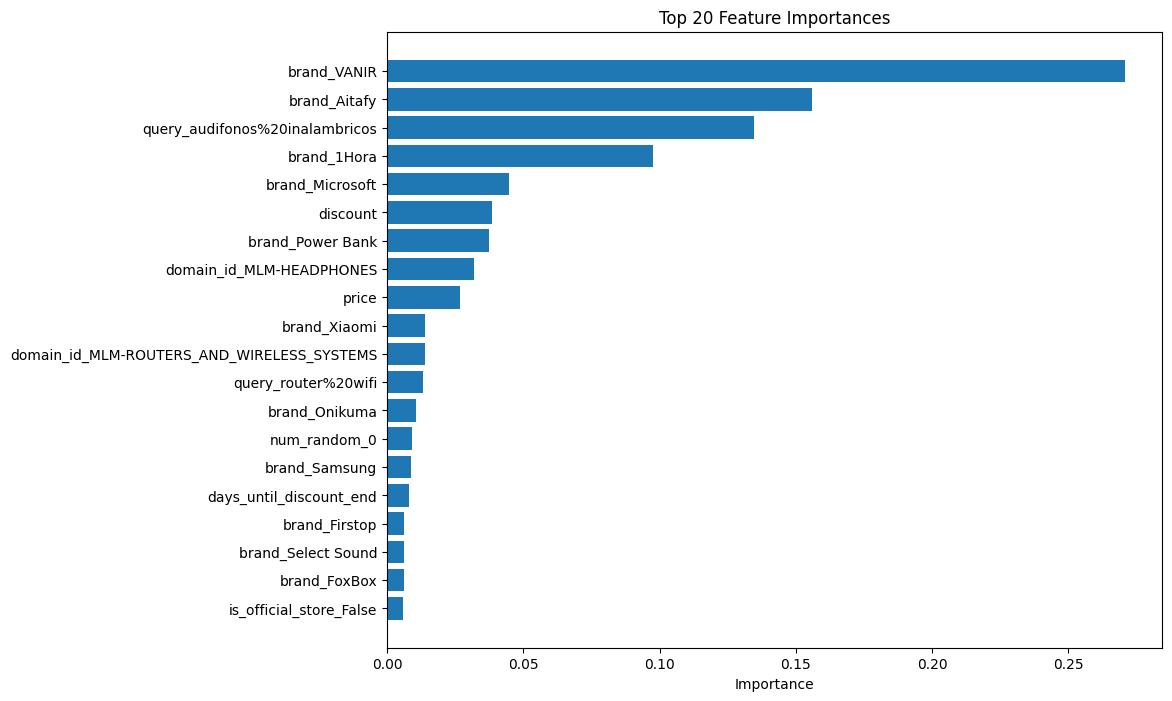

                                               Feature  Importance
0                                          brand_VANIR        0.27
1                                         brand_Aitafy        0.16
2                       query_audifonos%20inalambricos        0.13
3                                          brand_1Hora        0.10
4                                      brand_Microsoft        0.04
5                                             discount        0.04
6                                     brand_Power Bank        0.04
7                             domain_id_MLM-HEADPHONES        0.03
8                                                price        0.03
9                                         brand_Xiaomi        0.01
10          domain_id_MLM-ROUTERS_AND_WIRELESS_SYSTEMS        0.01
11                                 query_router%20wifi        0.01
12                                       brand_Onikuma        0.01
13                                        num_random_0        

In [49]:
# Llamar a la función con el pipeline entrenado y mostrar las 10 características más importantes
feature_importances_df = plot_and_get_feature_importances(rf_best_model, X_train, N=20)

# Mostrar el DataFrame completo con todas las características y sus importancias
print(feature_importances_df)

Elegiremos el mejor estimador, en este caso es el XGBoost que obtuvimos de haber hecho una optimización bayesiana

In [50]:
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'installment_quantity',
                                                   'ins...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [58]:
best_results["result"]["xgb_bayes"]

{'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 283}

In [65]:
# Supongamos que ya tienes estos parámetros de una búsqueda previa
xgb_params = best_results["result"]["xgb_bayes"]

# Configurar el modelo XGBoost con los mejores hiperparámetros
xgb_model = XGBRegressor(
    learning_rate=xgb_params['learning_rate'],
    max_depth=int(xgb_params['max_depth']),  
    min_child_weight=int(xgb_params['min_child_weight']),  
    n_estimators=int(xgb_params['n_estimators']), 
    random_state=42
)

# Actualizar el pipeline con el modelo configurado
xgb_pipeline.named_steps['model'] = xgb_model

# Entrenar el pipeline con los datos
xgb_pipeline.fit(X_train, y_train)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'installment_quantity',
                                                   'ins...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [62]:

best_model= xgb_pipeline.named_steps['model']

# Best features visualization

## Some features in the domain vs sold_quantity

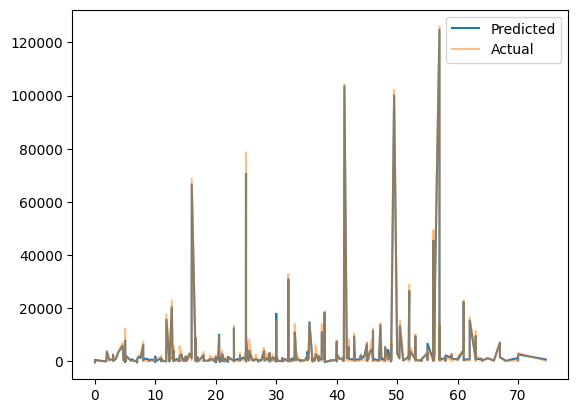

In [66]:
# Realizar predicciones usando el pipeline completo
bf = "discount"
domain = X_train[bf].sort_values().drop_duplicates()
domain_index = domain.index

# Predicciones con el pipeline completo, que incluye el preprocesamiento
y_hat = xgb_pipeline.predict(X_train.loc[domain_index])
y = y_train.loc[domain_index.values]

# Graficar los resultados
plt.plot(domain.values, y_hat, label='Predicted')
plt.plot(domain.values, y, alpha=0.5, label='Actual')
plt.legend()
plt.show()

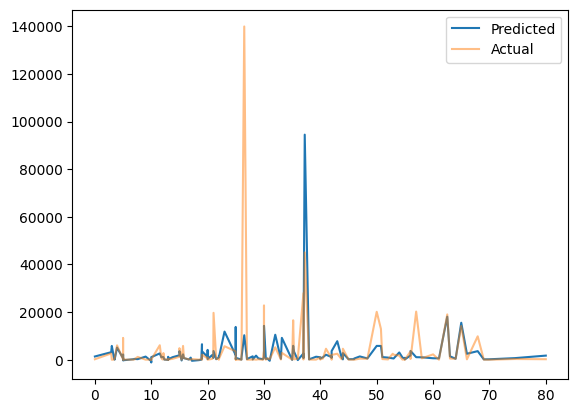

In [67]:
# Realizar predicciones usando el pipeline completo
bf = "discount"
domain = X_test[bf].sort_values().drop_duplicates()
domain_index = domain.index

# Predicciones con el pipeline completo, que incluye el preprocesamiento
y_hat = xgb_pipeline.predict(X_test.loc[domain_index])
y = y_test.loc[domain_index.values]

# Graficar los resultados
plt.plot(domain.values, y_hat, label='Predicted')
plt.plot(domain.values, y, alpha=0.5, label='Actual')
plt.legend()
plt.show()

## Shap for best model

In [70]:
model = xgb_pipeline.named_steps['model']
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

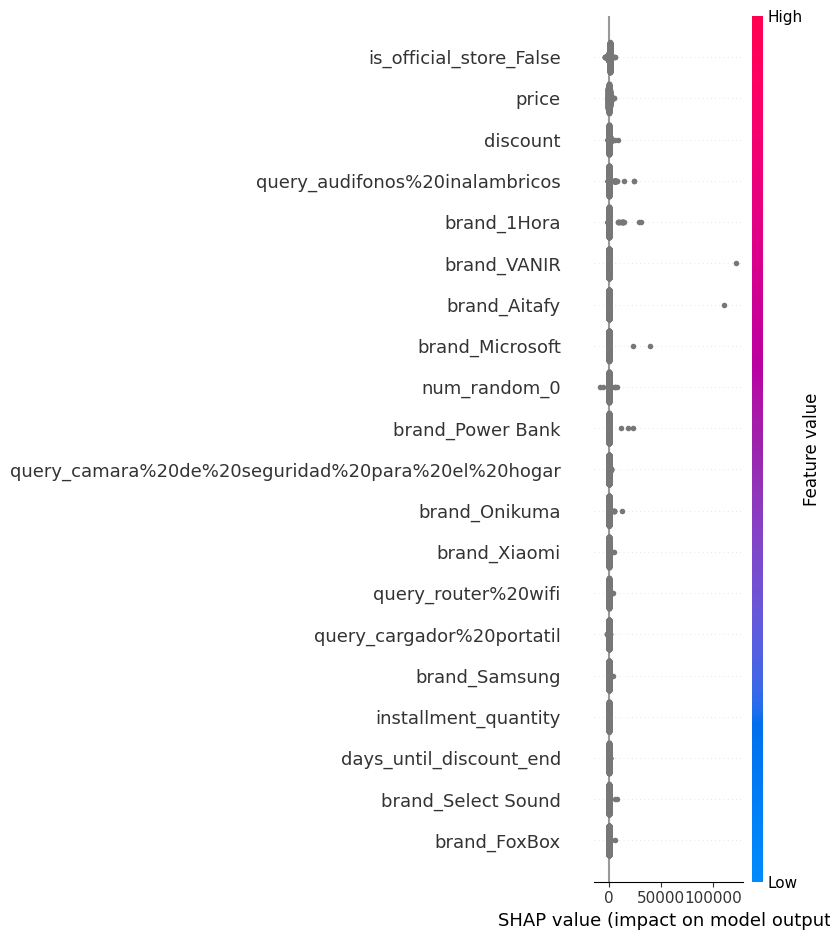

In [68]:
import shap

best_pipeline = xgb_grid_search.best_estimator_
explainer = shap.TreeExplainer(best_pipeline.named_steps['model'])

X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)


shap_values = explainer.shap_values(X_train_transformed,check_additivity=False)
num_quasinormal_features = best_pipeline.named_steps['preprocessor'].transformers_[0][2]
num_non_normal_features = best_pipeline.named_steps['preprocessor'].transformers_[1][2]
ohe = best_pipeline.named_steps['preprocessor'].transformers_[2][1]
cat_features = best_pipeline.named_steps['preprocessor'].transformers_[2][2]
ohe_features = ohe.get_feature_names_out(cat_features)
feature_names = np.concatenate([num_quasinormal_features, num_non_normal_features, ohe_features])
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

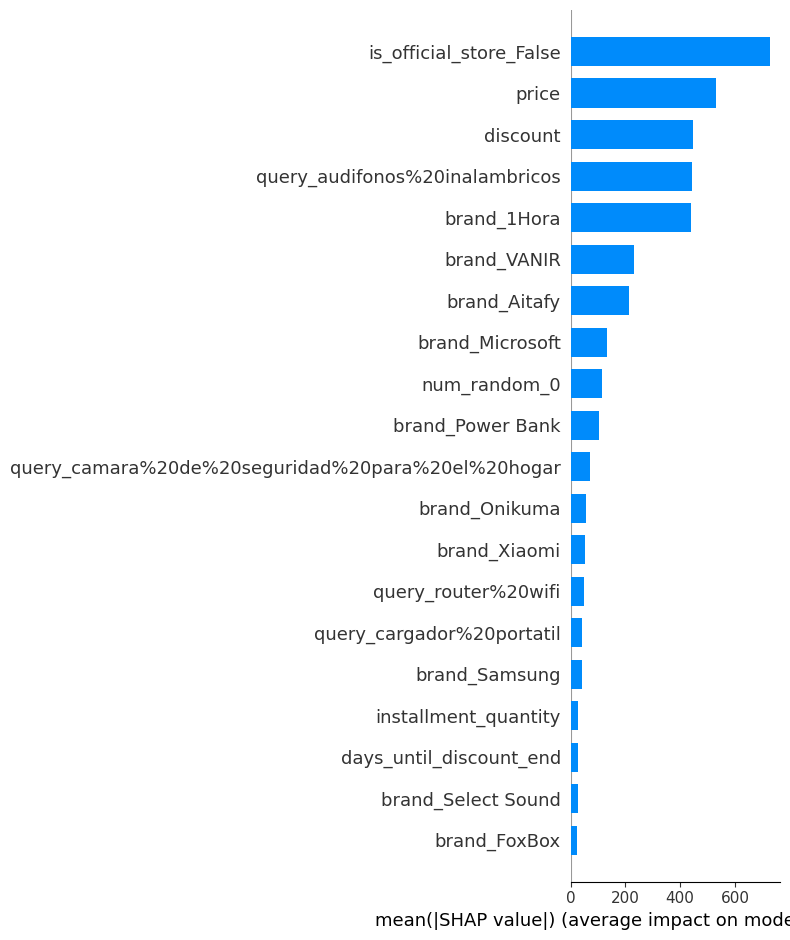

In [69]:
# Gráfico de Barras (Bar Plot)
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar")

# Guardar los resultados

In [56]:
import joblib

bayes_best_rf_model = RandomForestRegressor(**best_results["result"]["rf_bayes"])
bayes_best_xgb_model = XGBRegressor(**best_results["result"]["xgb_bayes"])
bayes_best_lgbm_model = LGBMRegressor(**best_results["result"]["xgb_bayes"])

joblib.dump(bayes_best_rf_model,   f'3{numero_de_experimento}_bayes_best_random_forest_model.pkl')
joblib.dump(bayes_best_xgb_model,  f'3{numero_de_experimento}_bayes_best_xgboost_model.pkl')
joblib.dump(bayes_best_lgbm_model, f'3{numero_de_experimento}_bayes_best_lightgbm_model.pkl')


joblib.dump(best_results["result"]["rf_gr"],   f'3{numero_de_experimento}_CV_best_random_forest_model.pkl')
joblib.dump(best_results["result"]["xgb_gr"],  f'3{numero_de_experimento}_CV_best_xgboost_model.pkl')
joblib.dump(best_results["result"]["lgbm_gr"], f'3{numero_de_experimento}_CV_best_lightgbm_model.pkl')

['32_CV_best_lightgbm_model.pkl']